# Modelling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import requests
import json
from pandas import json_normalize

import geopandas as gpd
from shapely.geometry import Point

import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster

import h3
from shapely.geometry import Polygon, box, Point  # Import Point from shapely.geometry

In [2]:
# Read the CSV file into a DataFrame
weekday_model = pd.read_csv('assets/processed_data/weekday_model.csv')

# Replace the column name 'Unnamed: 0' with 'h3_index'
weekday_model.columns = weekday_model.columns.str.replace('Unnamed: 0', 'h3_index')

# Set the index of the DataFrame to the second column
weekday_model.set_index(weekday_model.columns[0], inplace=True)

weekday_model.head()

1.0        3.0          7.0         9.0         10.0  \
h3_index                                                                
05:00       0.000000   0.000000    41.783394   11.236842   139.108974   
06:00     365.400000  23.500000   523.509506  351.523810   560.313830   
07:00      40.938776  20.600000  1003.231939  278.000000  1146.800633   
08:00      11.080357  12.894737  1285.225962  271.686047   933.769481   
09:00       6.201835  14.421053   563.418251   89.500000   269.614035   

                11.0        12.0         14.0        15.0        22.0  ...  \
h3_index                                                               ...   
05:00       0.000000    0.000000     0.000000   16.873016   33.237589  ...   
06:00     367.600000  233.937500  1164.000000  182.544379  164.885387  ...   
07:00      77.227273  101.600000   262.666667  246.440644  223.730382  ...   
08:00      28.830769    9.922330   175.000000  379.043062  259.165306  ...   
09:00       9.085106    5.725806    50.750000  203.561776   83.084123  ...   

               227.0       228.0       229.0        230.0     231.0  \
h3_index                                                              
05:00      22.184729   34.310030   12.617021   109.661738  0.000000   
06:00     169.484700  222.220877   92.960699   522.188433  0.375000   
07:00     192.854727  447.597173  189.516746  1162.903226  0.142857   
08:00     275.838736  496.104129  193.342222   977.573333  0.043478   
09:00     145.543829  325.310870  159.487654   547.469136  0.031250   

               234.0       235.0        242.0       243.0       246.0  
h3_index                                                               
05:00      36.077966   33.716418   187.909091    0.000000   20.940767  
06:00     185.143345  202.564706   995.879121  159.923077  176.416382  
07:00     339.136719  294.020833  1856.820225   95.833333  237.392857  
08:00     280.773381  360.847059  1241.363636   41.941176  263.730375  
09:00     156.789668  133.782875   612.234375   19.380952  103.253247  

[5 rows x 113 columns]

In [3]:
# Read the CSV file into a DataFrame
weekend_model = pd.read_csv('assets/processed_data/weekend_model.csv')

# Replace the column name 'Unnamed: 0' with 'h3_index'
weekend_model.columns = weekend_model.columns.str.replace('Unnamed: 0', 'h3_index')

# Set the index of the DataFrame to the second column
weekend_model.set_index(weekend_model.columns[0], inplace=True)

weekend_model.head()

1.0    3.0         7.0         9.0        10.0        11.0  \
h3_index                                                                     
05:00      0.000000    0.0   18.391667    5.600000   56.286765    0.000000   
06:00     87.875000   17.0  237.974684   52.900000  239.087591  794.000000   
07:00     85.538462   46.0  389.282353  513.625000  389.040323  141.166667   
08:00     27.580645  145.0  536.926829  248.750000  561.444444   65.250000   
09:00     39.920000   38.0  647.818182  133.758621  598.736842   62.000000   

                12.0   14.0        15.0        22.0  ...       227.0  \
h3_index                                             ...               
05:00       0.000000    0.0    8.610526   18.024390  ...   10.611801   
06:00     306.750000  367.0   90.500000   61.777778  ...   98.937008   
07:00     257.875000  195.5  146.959016   95.145455  ...  157.264706   
08:00      49.000000  114.0  242.705882  147.482517  ...  205.925676   
09:00      46.552632  359.0  267.514493  126.857143  ...  181.513453   

               228.0       229.0       230.0  231.0       234.0       235.0  \
h3_index                                                                      
05:00      22.793578    7.064516   51.910000    0.0   16.938356   26.576923   
06:00      96.579167   41.333333  189.830688    0.4   73.110092  203.785714   
07:00     181.813953   94.246154  402.786667    0.0  118.873786  169.454545   
08:00     257.366834  142.486486  447.304598    0.2  171.500000  359.115385   
09:00     237.724891  153.772152  506.174699    0.0  137.716667  280.312500   

               242.0       243.0       246.0  
h3_index                                      
05:00      71.949153    0.000000    7.568000  
06:00     332.463415  176.400000   79.275510  
07:00     643.093750  518.000000  139.141176  
08:00     922.259259  100.833333  179.684783  
09:00     854.250000  106.727273  169.884615  

[5 rows x 113 columns]

## Time Series Modeling

### Auto Arima Rolling Window

#### Weekdays

In [4]:
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import numpy as np

# Define window size
window_size = 3

# Define forecast horizon
forecast_horizon = 1

# Create an empty DataFrame to store predictions
predictions_df = pd.DataFrame(columns=weekday_model.columns)

# List to store RMSE values for each feature
rmse_values = []

# Iterate through the data using rolling window
for i in range(len(weekday_model) - window_size):
    # Print progress
    print(f"Processing window {i+1}/{len(weekday_model) - window_size}...")
    
    # Extract data within the window
    window_data = weekday_model.iloc[i:i+window_size]
    
    # Fit Auto ARIMA models for each feature
    arima_models = {}
    for feature in window_data.columns:
        model = auto_arima(window_data[feature], verbose=True)
        arima_models[feature] = model
    
    # Generate predictions for the next time step
    predictions = {}
    for feature, model in arima_models.items():
        forecast = model.predict(n_periods=forecast_horizon)
        predictions[feature] = forecast
    
    # Append predictions to the DataFrame with timestamp as index
    timestamp = weekday_model.index[i + window_size]
    predictions_df = pd.concat([predictions_df, pd.DataFrame(predictions, index=[timestamp])])

# Reset the index of the predictions DataFrame
predictions_df.reset_index(inplace=True)
predictions_df.rename(columns={'index': 'timestamp'}, inplace=True)

Processing window 1/16...
Processing window 2/16...
Processing window 3/16...
Processing window 4/16...
Processing window 5/16...
Processing window 6/16...
Processing window 7/16...
Processing window 8/16...
Processing window 9/16...
Processing window 10/16...
Processing window 11/16...
Processing window 12/16...
Processing window 13/16...
Processing window 14/16...
Processing window 15/16...
Processing window 16/16...


In [5]:
predictions_df.index = predictions_df['timestamp']
predictions_df = predictions_df.drop(columns = ['timestamp'])

In [6]:
predictions_df.shape

(16, 113)

In [7]:
weekday_actual = weekday_model[3:]
weekday_actual.shape

(16, 113)

In [8]:
# Calculate RMSE for each feature
rmse_values = []
for column in predictions_df.columns:
    squared_diff = (weekday_actual[column] - predictions_df[column]) ** 2
    mse = squared_diff.mean()
    rmse_values.append(np.sqrt(mse))

# Average out the RMSE values
average_rmse = np.mean(rmse_values)

print("Average RMSE across all features:", average_rmse)

Average RMSE across all features: 167.73634445518553


In [9]:
df = weekday_model.iloc[5:8]

In [10]:
df

1.0         3.0         7.0         9.0        10.0  \
h3_index                                                              
10:00      9.375000   25.363636  245.382653   43.971660  197.793684   
11:00     16.250000   31.785714  270.469697   90.751634  188.504310   
12:00     52.454545  154.666667  352.293413  195.463158  269.398810   

                11.0       12.0        14.0        15.0        22.0  ...  \
h3_index                                                             ...   
10:00      27.717949   6.993103   69.750000  100.325452   62.763789  ...   
11:00      73.000000  16.024390   82.333333   87.304079   84.579276  ...   
12:00     180.909091  55.937500  164.500000  101.457931  122.020772  ...   

               227.0       228.0      229.0       230.0     231.0      234.0  \
h3_index                                                                       
10:00      67.542301  205.198758  97.425000  377.759259  0.052632  95.532468   
11:00      79.362923  129.641168  82.424242  275.022869  0.138889  92.130000   
12:00     124.631873  144.333811  90.783465  255.957968  0.064516  92.242038   

               235.0       242.0      243.0      246.0  
h3_index                                                
10:00      77.083507  534.045455  21.603774  64.756364  
11:00     101.380457  346.477477  39.714286  57.471910  
12:00     188.175258  348.136752  17.384615  88.877083  

[3 rows x 113 columns]

In [11]:
model = auto_arima(df['3.0'])

forecast = model.predict(n_periods=1)

In [12]:
forecast

2024-06-18 13:00:00    70.605339
Freq: H, dtype: float64

In [13]:
predictions_df['3.0']

timestamp
08:00     14.700000
09:00     18.998246
10:00     15.971930
11:00     17.559809
12:00     23.856801
13:00     70.605339
14:00     93.198413
15:00    121.888889
16:00    118.809524
17:00    241.595238
18:00    591.642857
19:00    667.833333
20:00    695.166667
21:00    466.500000
22:00    352.444444
23:00      0.000000
Name: 3.0, dtype: float64

#### Weekends

In [14]:
# Define window size
window_size = 3

# Define forecast horizon
forecast_horizon = 1

# Create an empty DataFrame to store predictions
weekend_predictions_df = pd.DataFrame(columns=weekend_model.columns)

# Iterate through the data using rolling window
for i in range(len(weekend_model) - window_size):
    # Print progress
    print(f"Processing window {i+1}/{len(weekend_model) - window_size}...")
    
    # Extract data within the window
    window_data = weekend_model.iloc[i:i+window_size]
    
    # Fit Auto ARIMA models for each feature
    arima_models = {}
    for feature in window_data.columns:
        model = auto_arima(window_data[feature], verbose=True)
        arima_models[feature] = model
    
    # Generate predictions for the next time step
    predictions = {}
    for feature, model in arima_models.items():
        forecast = model.predict(n_periods=forecast_horizon)
        predictions[feature] = forecast
    
    # Append predictions to the DataFrame with timestamp as index
    timestamp = weekday_model.index[i + window_size]
    weekend_predictions_df = pd.concat([weekend_predictions_df, pd.DataFrame(predictions, index=[timestamp])])

# Reset the index of the predictions DataFrame
weekend_predictions_df.reset_index(inplace=True)
weekend_predictions_df.rename(columns={'index': 'timestamp'}, inplace=True)

Processing window 1/16...
Processing window 2/16...
Processing window 3/16...
Processing window 4/16...
Processing window 5/16...
Processing window 6/16...
Processing window 7/16...
Processing window 8/16...
Processing window 9/16...
Processing window 10/16...
Processing window 11/16...
Processing window 12/16...


C:\Users\IINDR\miniconda3\envs\dsi-sg\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Processing window 13/16...


C:\Users\IINDR\miniconda3\envs\dsi-sg\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\IINDR\miniconda3\envs\dsi-sg\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Processing window 14/16...


C:\Users\IINDR\miniconda3\envs\dsi-sg\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\IINDR\miniconda3\envs\dsi-sg\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Processing window 15/16...


C:\Users\IINDR\miniconda3\envs\dsi-sg\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\IINDR\miniconda3\envs\dsi-sg\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Processing window 16/16...


C:\Users\IINDR\miniconda3\envs\dsi-sg\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\IINDR\miniconda3\envs\dsi-sg\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


In [15]:
weekend_predictions_df.head()

timestamp        1.0         3.0         7.0         9.0        10.0  \
0     08:00  57.804487   21.000000  215.216234    0.000000  228.138226   
1     09:00  66.998036   69.333333  388.061289  363.883642  396.524119   
2     10:00  51.013036  150.018658  524.675788  298.711207  516.407203   
3     11:00  50.472437   71.281333  595.874843  194.730146  562.742247   
4     12:00  84.987222   80.714725  657.143959  185.025601  540.955681   

         11.0        12.0        14.0        15.0  ...       227.0  \
0  696.864472  188.208333  187.500000   82.023181  ...   88.937838   
1  333.472222  204.541667  225.500000  160.054966  ...  154.042463   
2   89.472222  117.809211  222.833333  219.059797  ...  181.567945   
3   65.130952   52.920322  198.111111  257.542276  ...  197.589867   
4  115.825397   85.162746  149.495871  256.067518  ...  200.995502   

        228.0       229.0       230.0     231.0       234.0       235.0  \
0  100.395566   47.548001  214.842451  0.000000   69.640745  133.272394   
1  178.586651   92.688658  346.640651  0.200000  121.161293  244.118548   
2  225.635226  130.168264  452.088654  0.000000  160.360088  269.627477   
3  245.247025  152.914916  491.417434  0.243137  153.651802  317.890103   
4  228.558331  144.515166  506.088714  0.000000  138.799498  375.838821   

        242.0       243.0       246.0  
0  349.168772  231.466667   75.328229  
1  632.605475  562.633515  132.700490  
2  806.534336  241.853535  162.903525  
3  764.176698  110.368687  180.455825  
4  652.290278  121.240084  205.508689  

[5 rows x 114 columns]

In [16]:
weekend_predictions_df.index = weekend_predictions_df['timestamp']
weekend_predictions_df = weekend_predictions_df.drop(columns = ['timestamp'])

In [17]:
weekend_actual = weekend_model[3:]
weekend_actual.shape

(16, 113)

In [18]:
# Calculate RMSE for each feature
weekend_rmse_values = []
for column in weekend_predictions_df.columns:
    squared_diff = (weekend_actual[column] - weekend_predictions_df[column]) ** 2
    mse = squared_diff.mean()
    weekend_rmse_values.append(np.sqrt(mse))

# Average out the RMSE values
weekend_average_rmse = np.mean(weekend_rmse_values)

print("Average RMSE across all features:", weekend_average_rmse)

Average RMSE across all features: 119.73527332121564


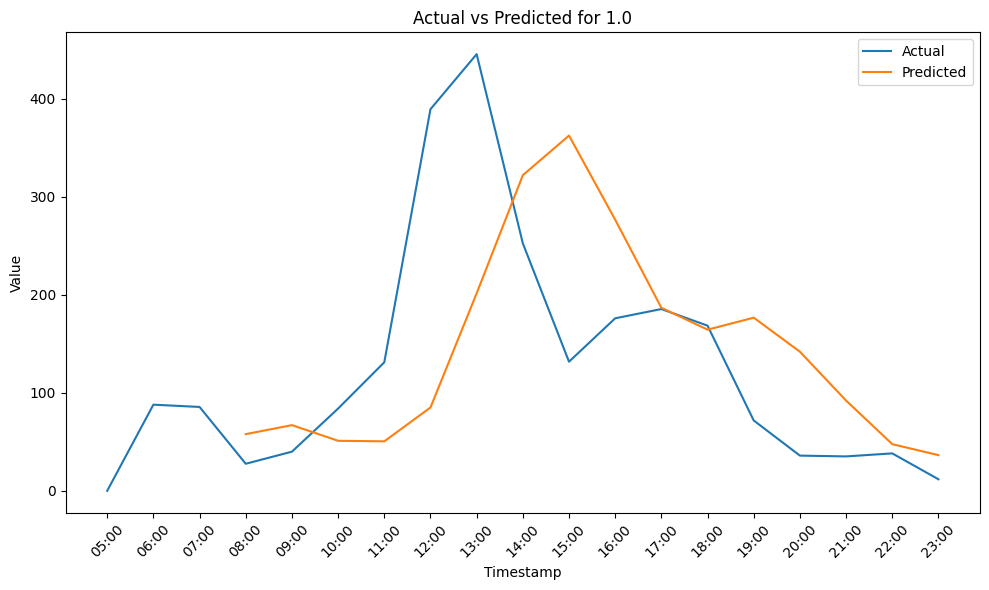

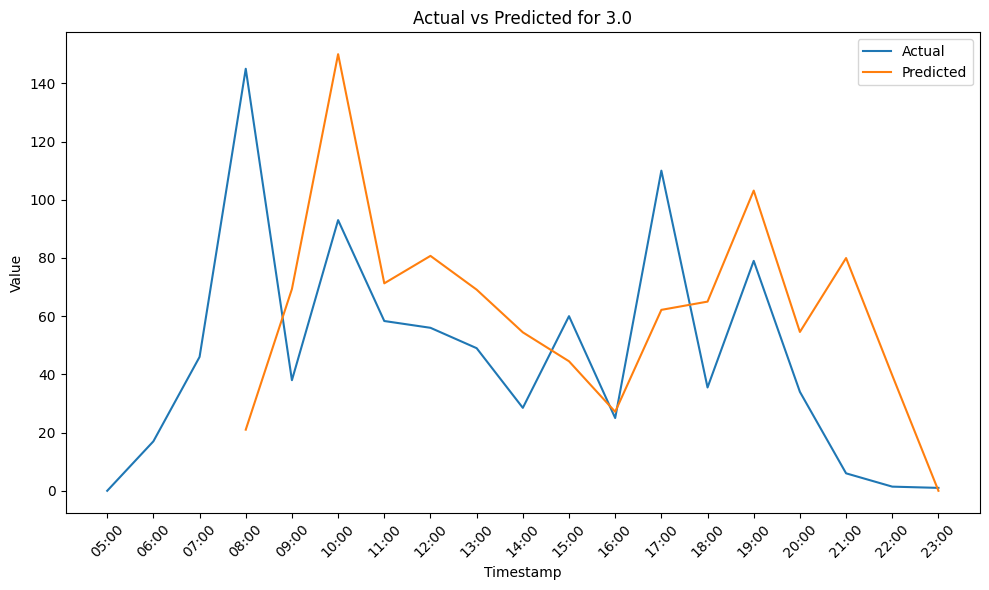

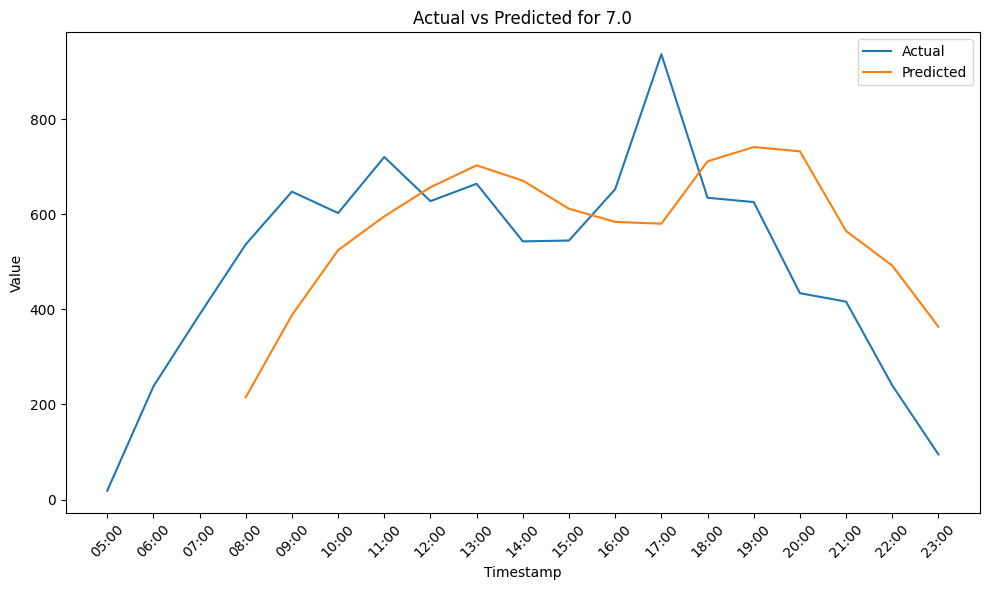

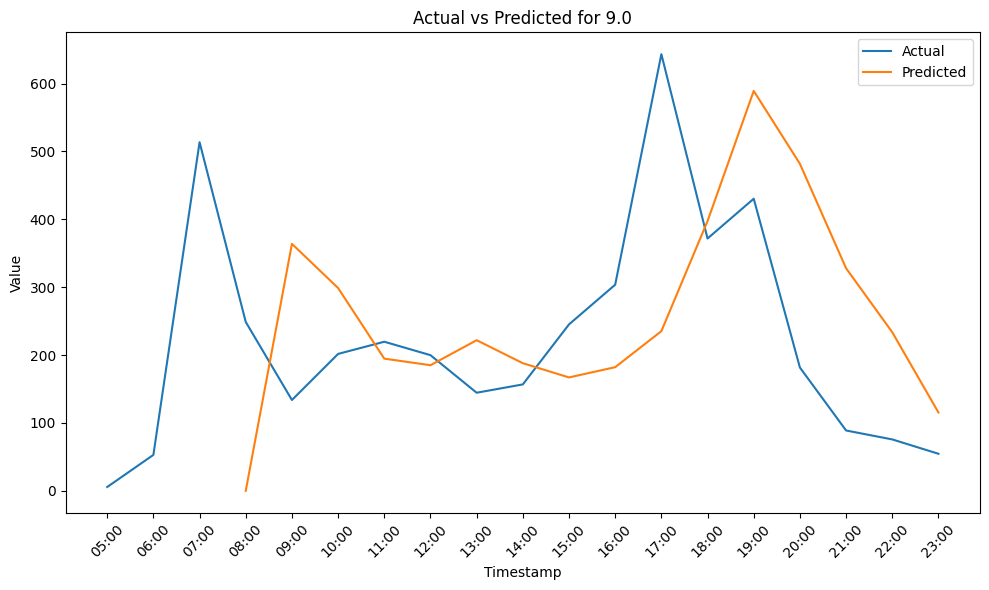

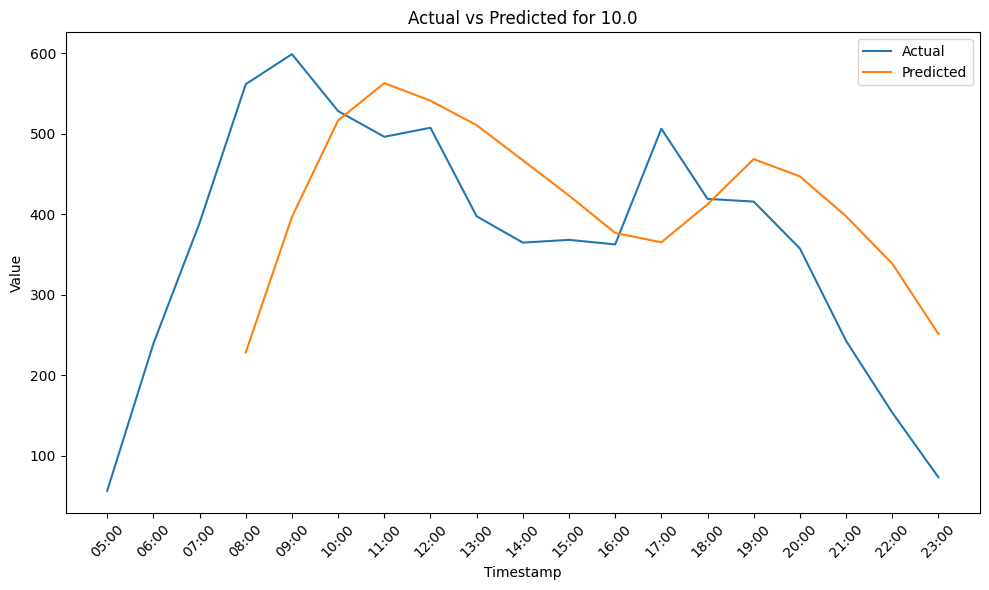

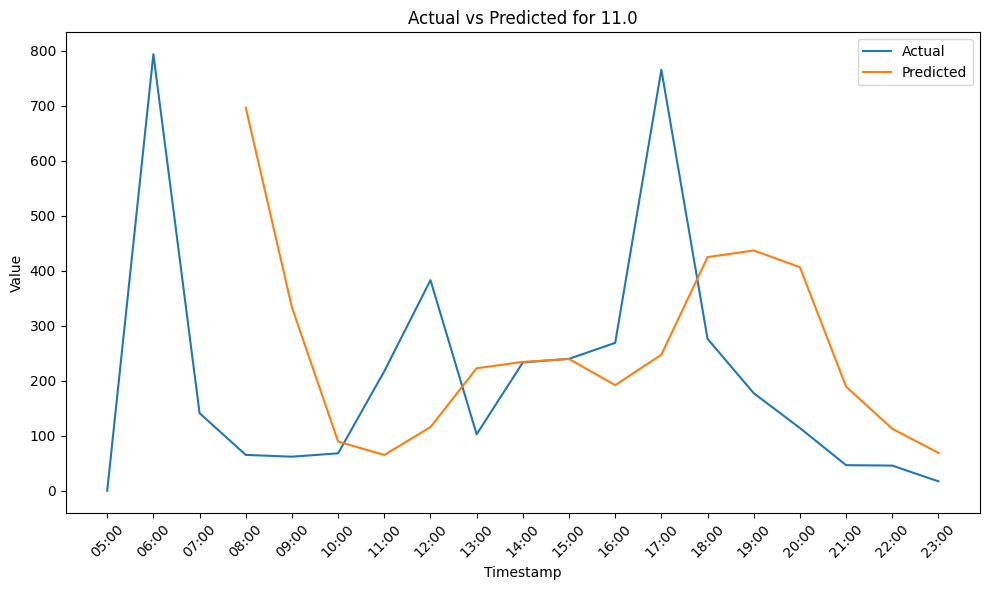

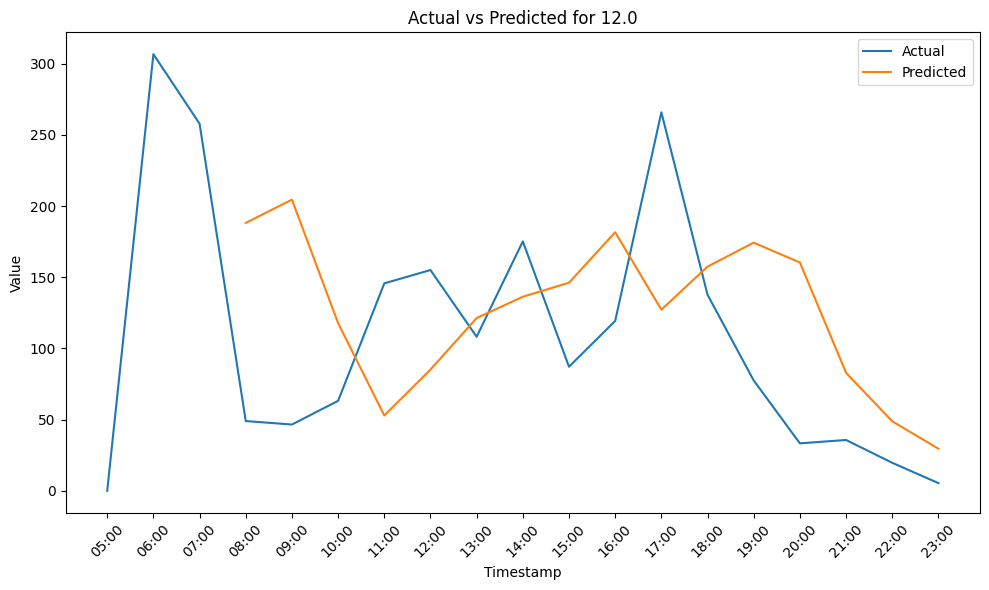

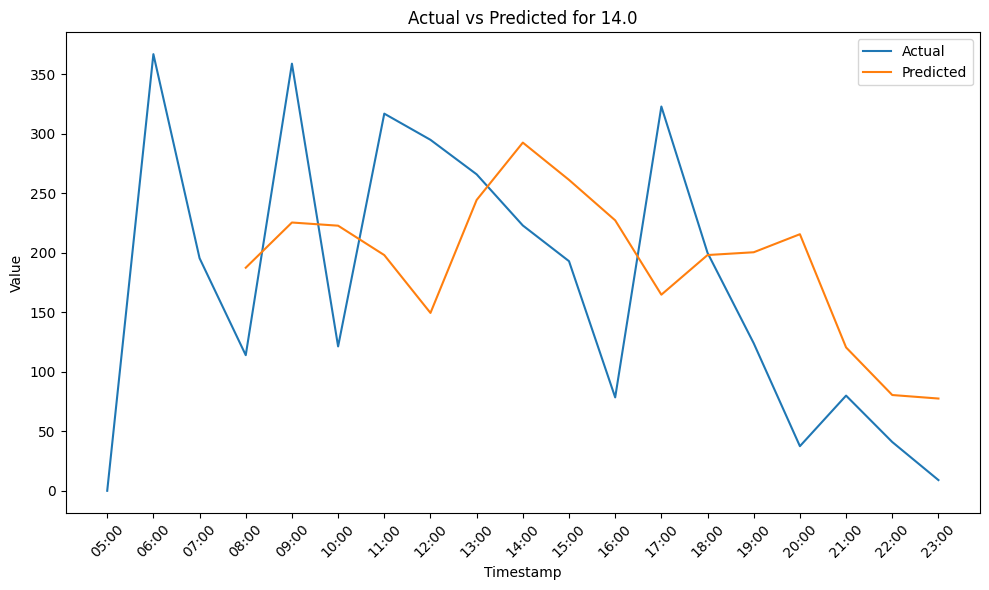

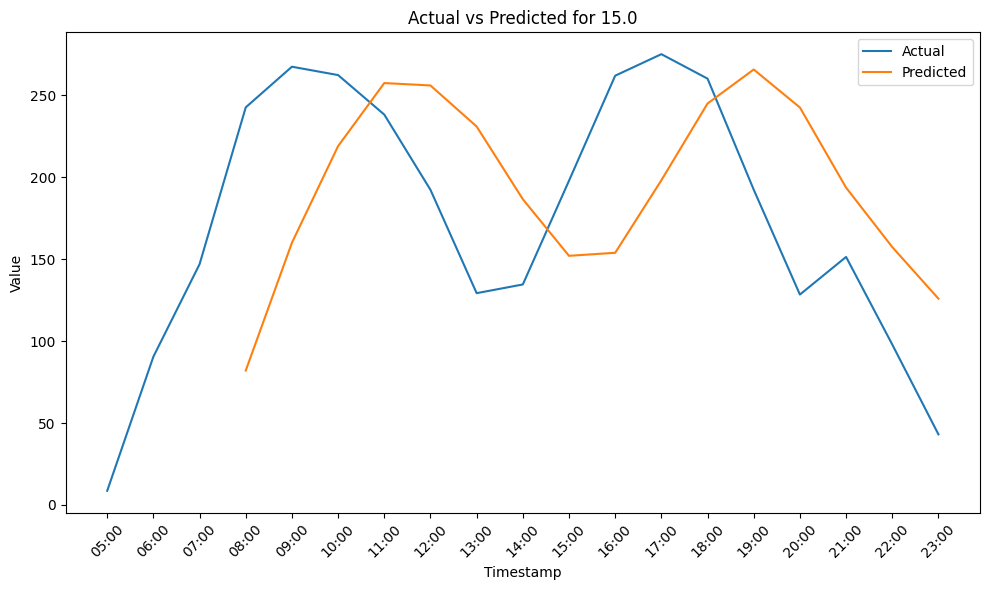

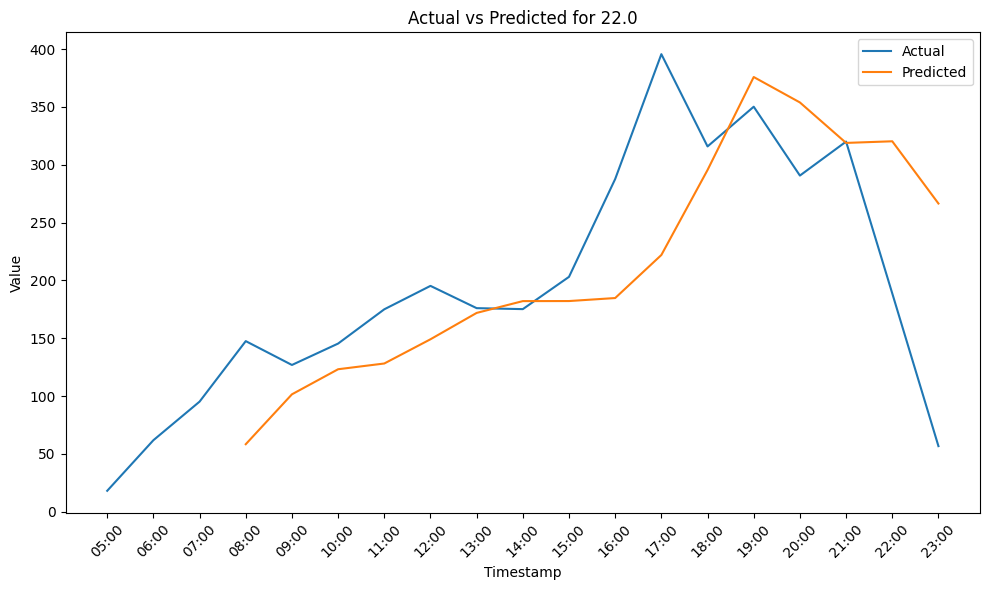

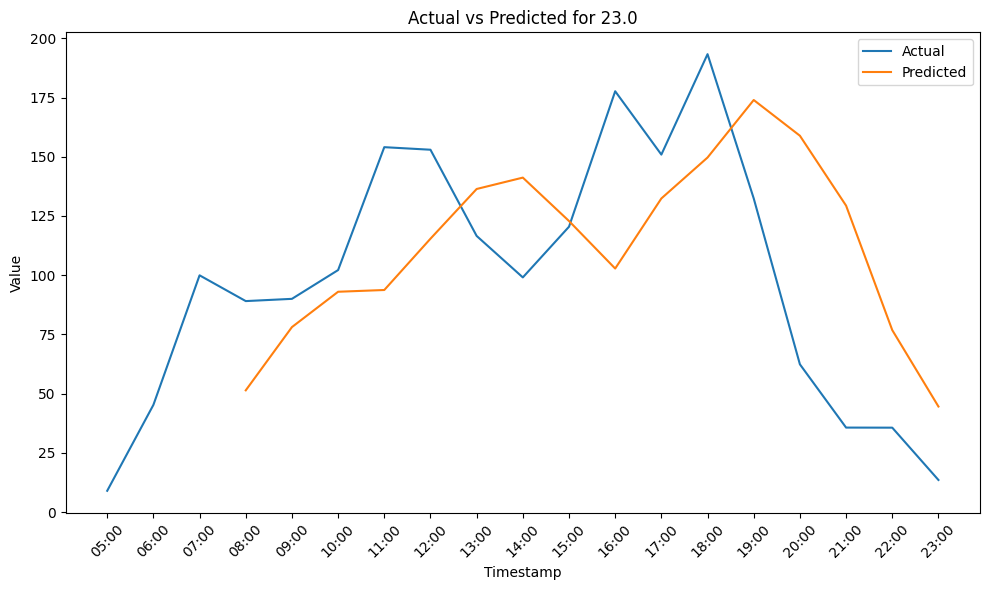

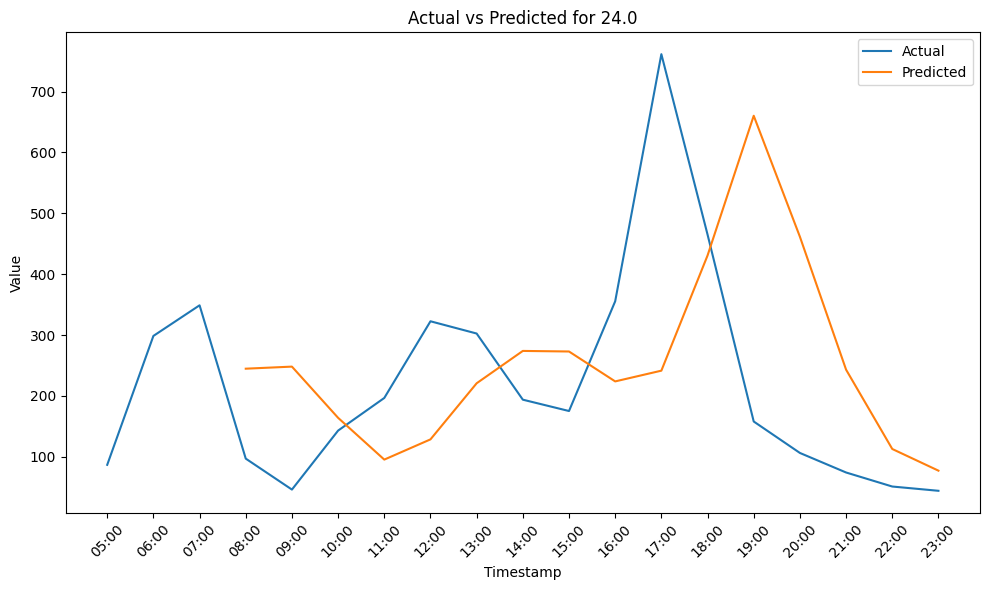

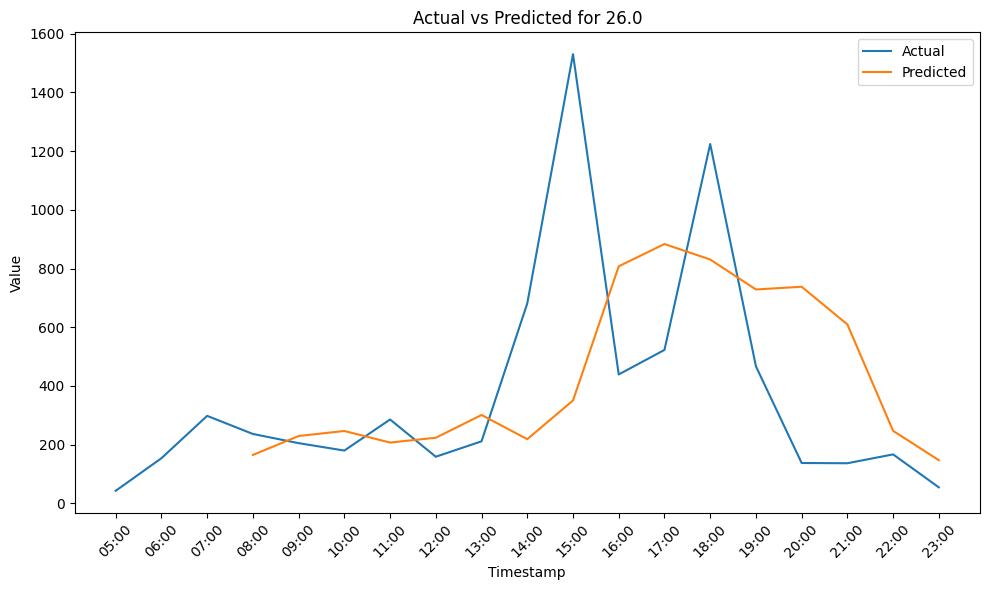

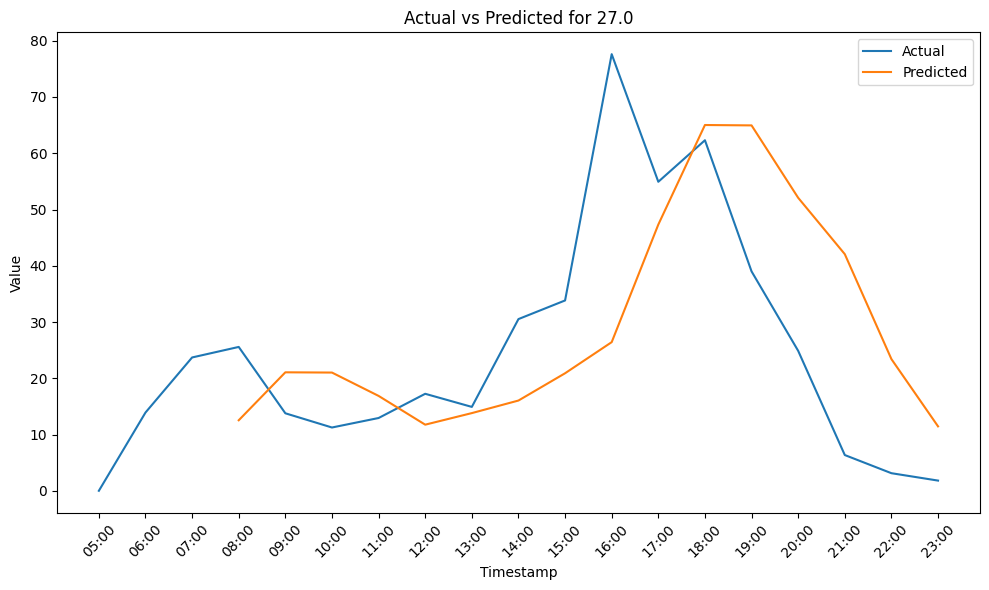

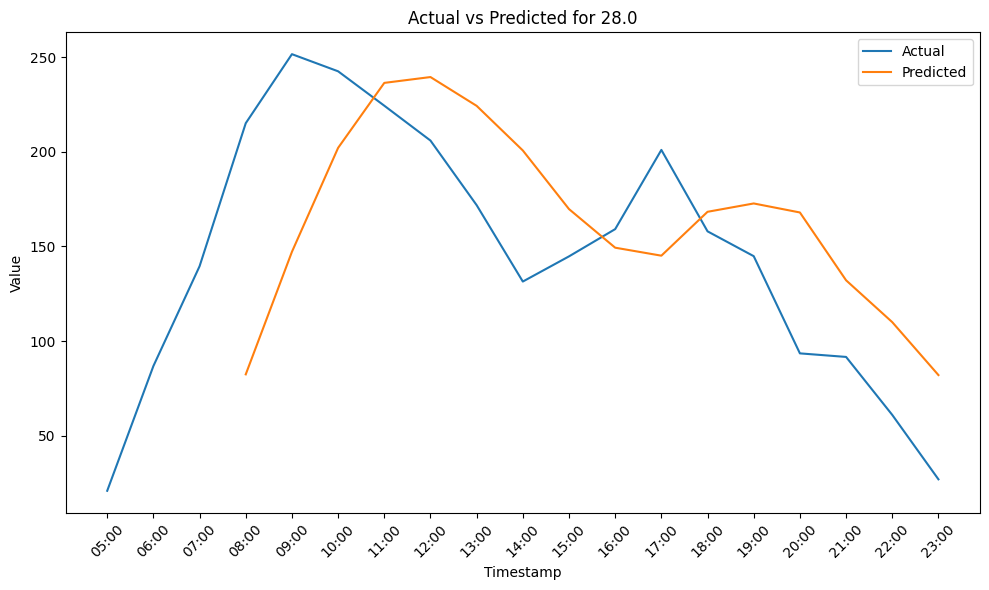

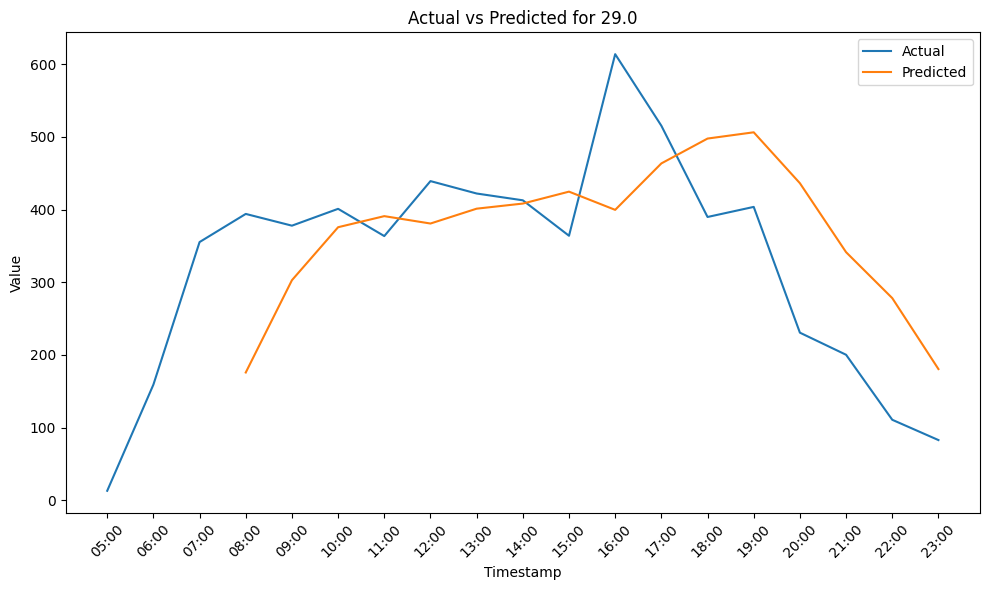

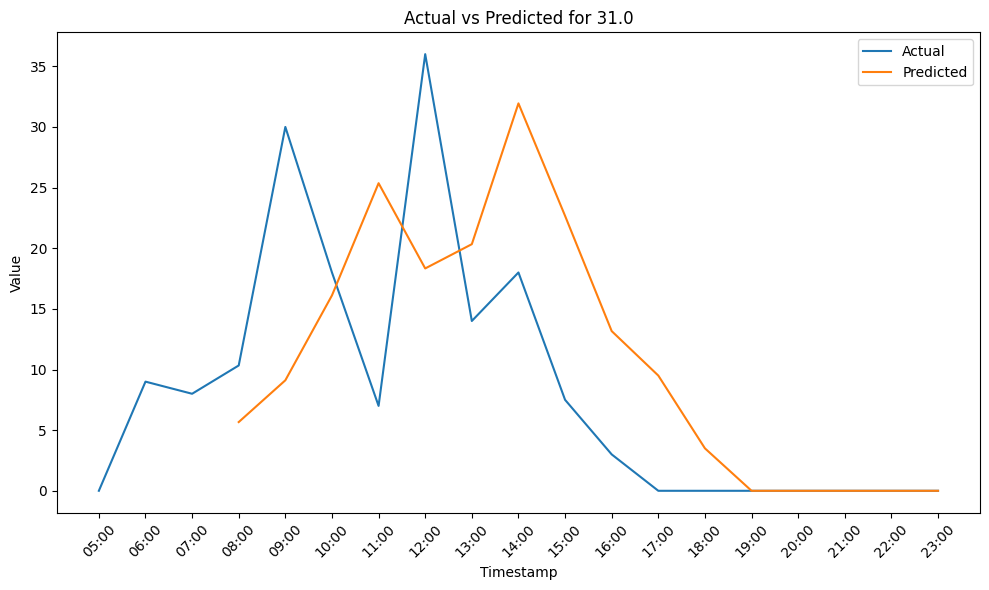

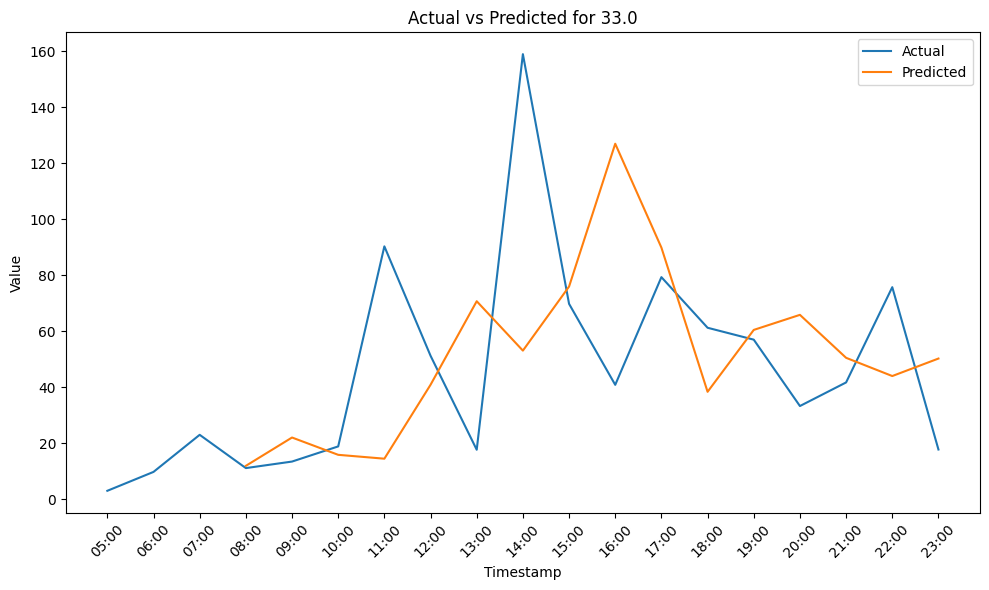

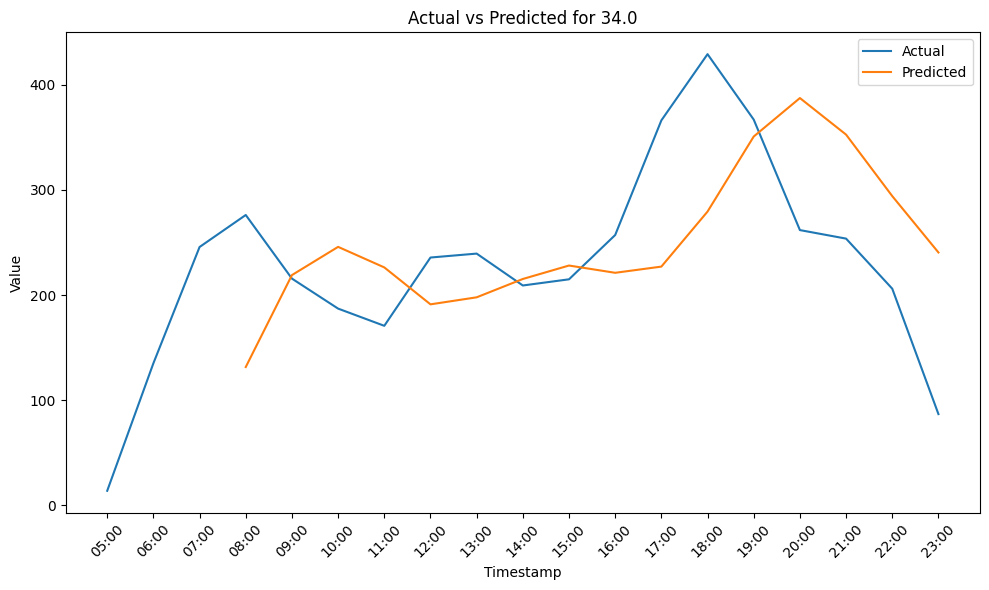

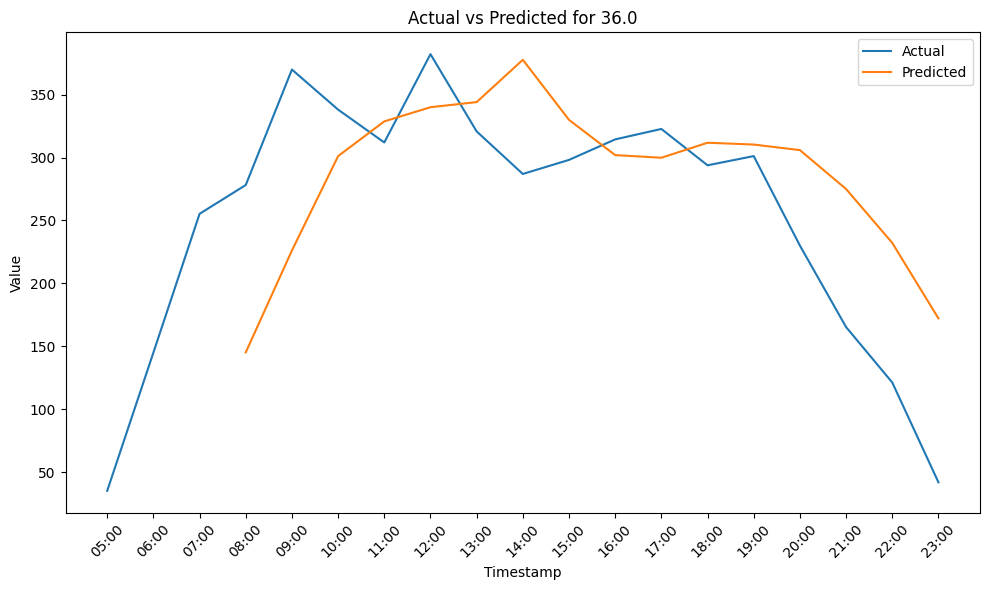

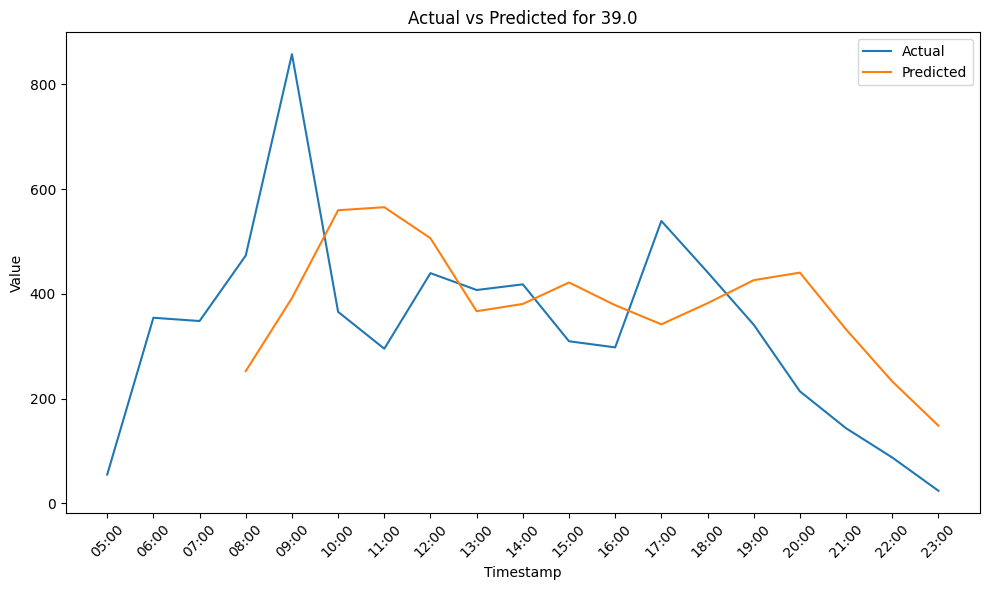

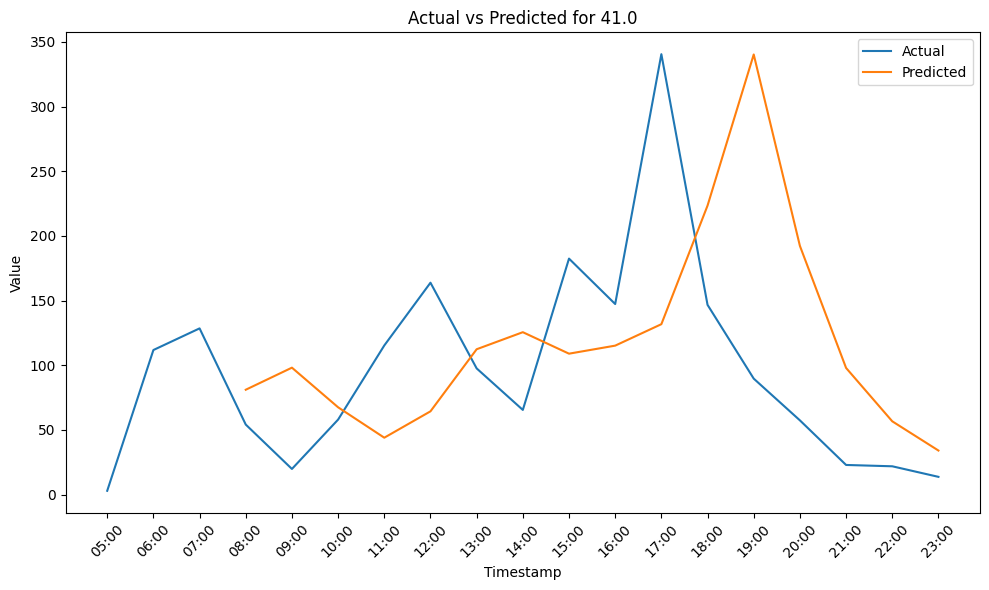

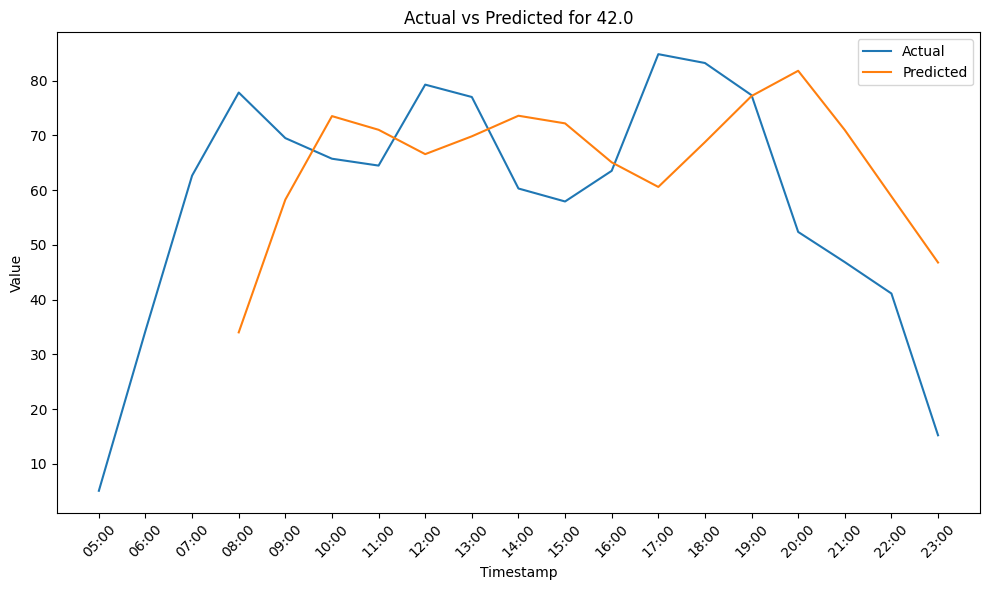

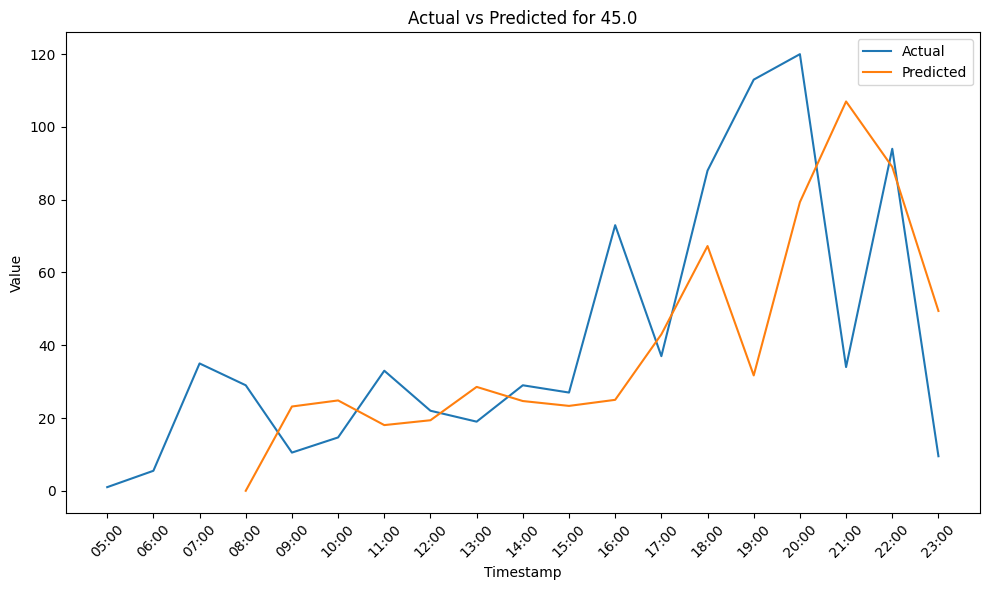

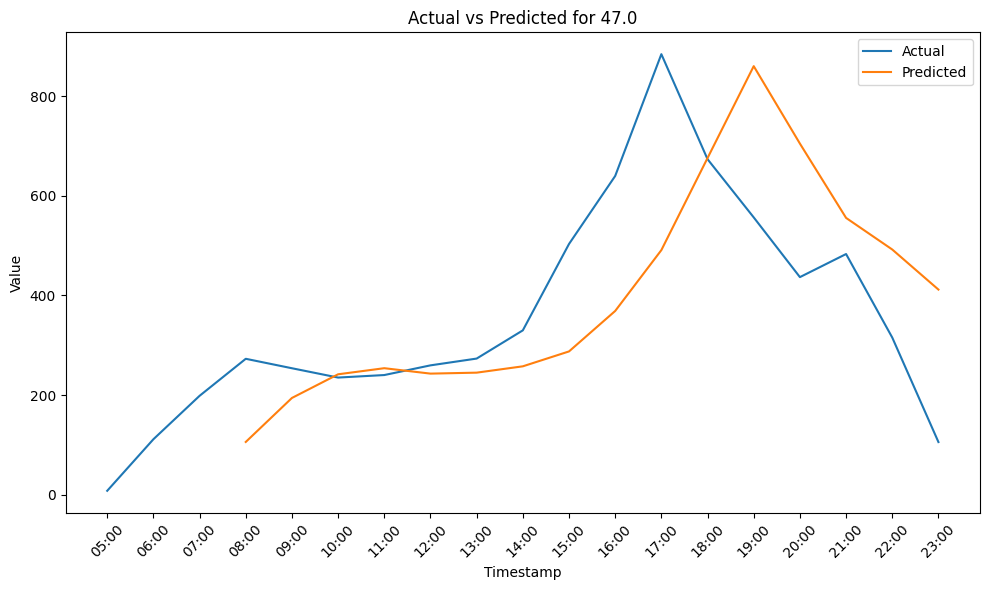

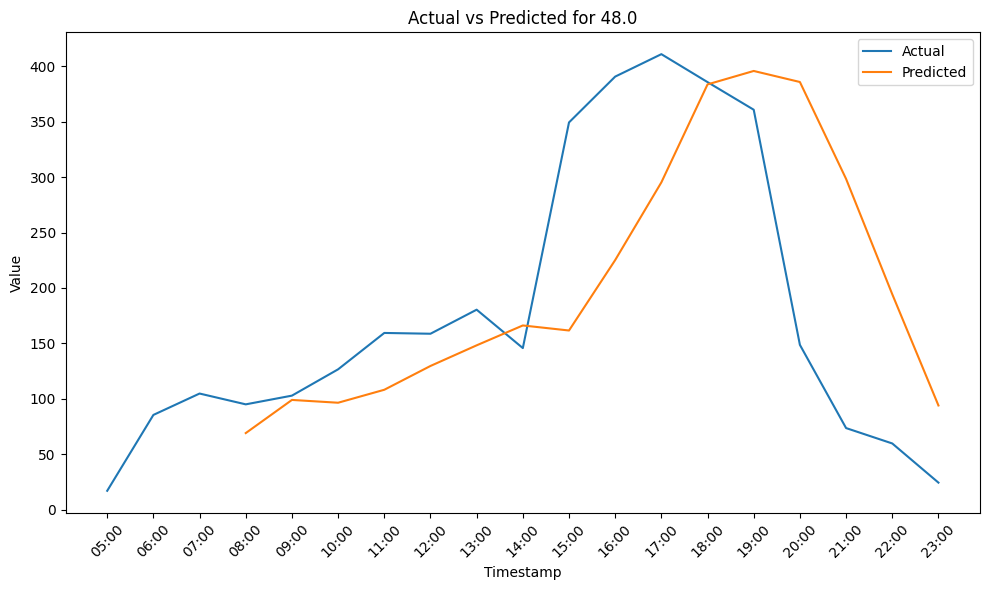

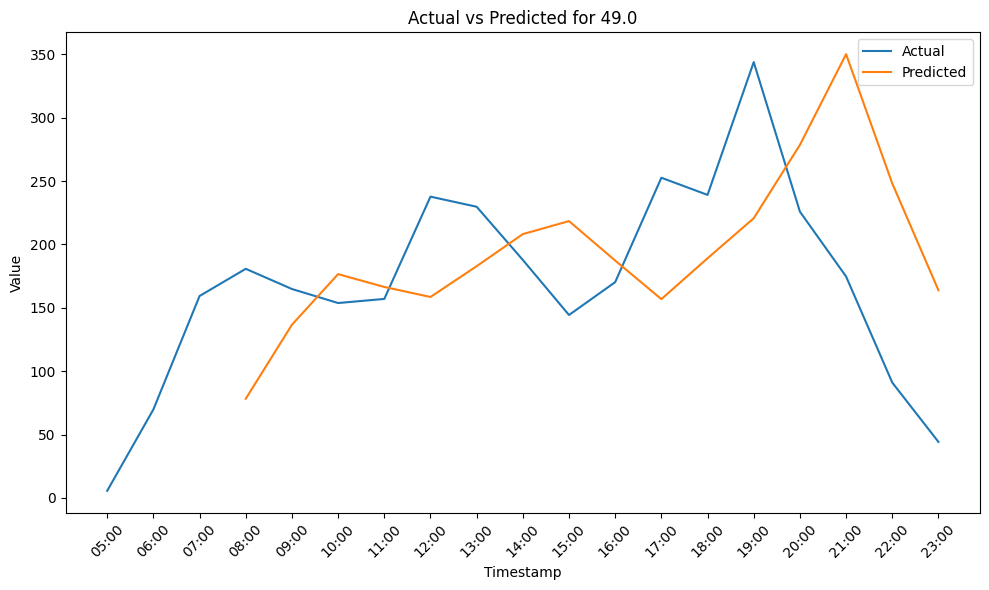

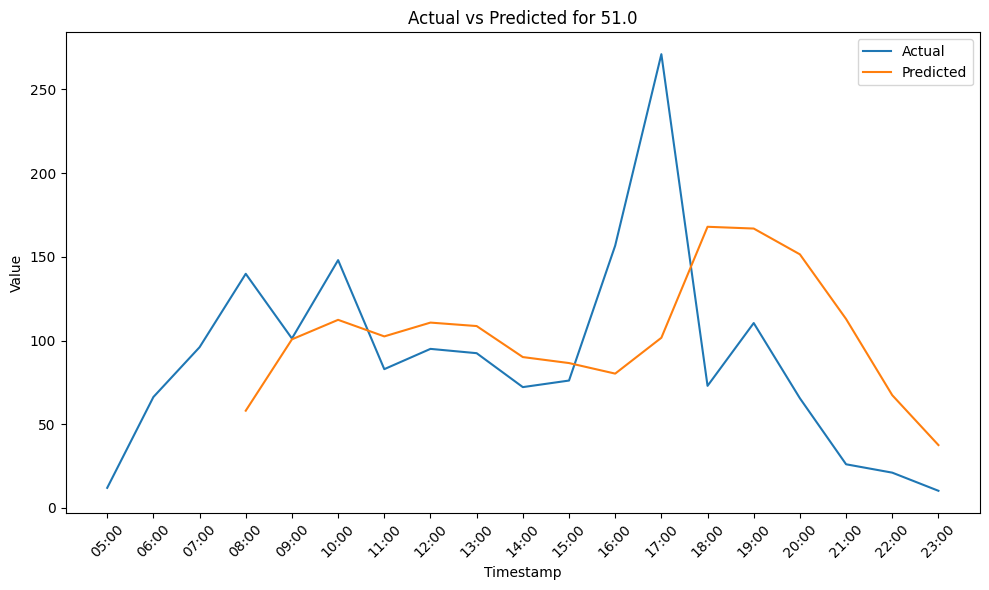

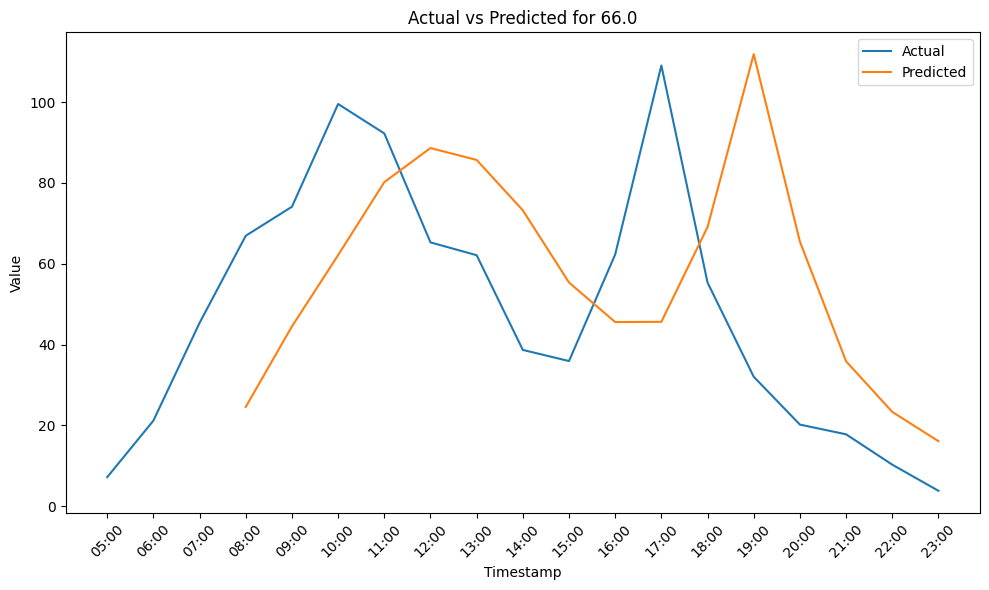

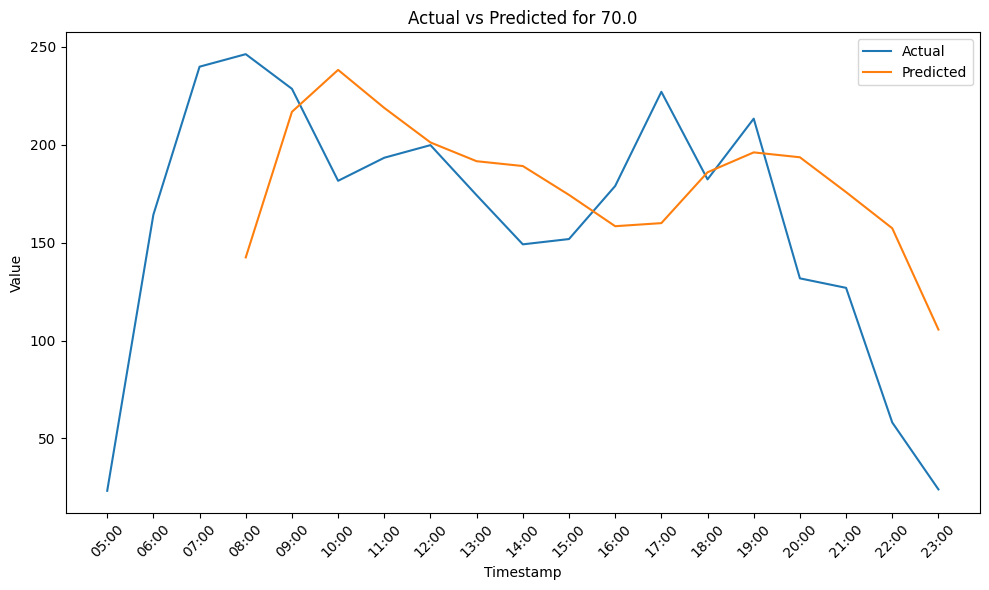

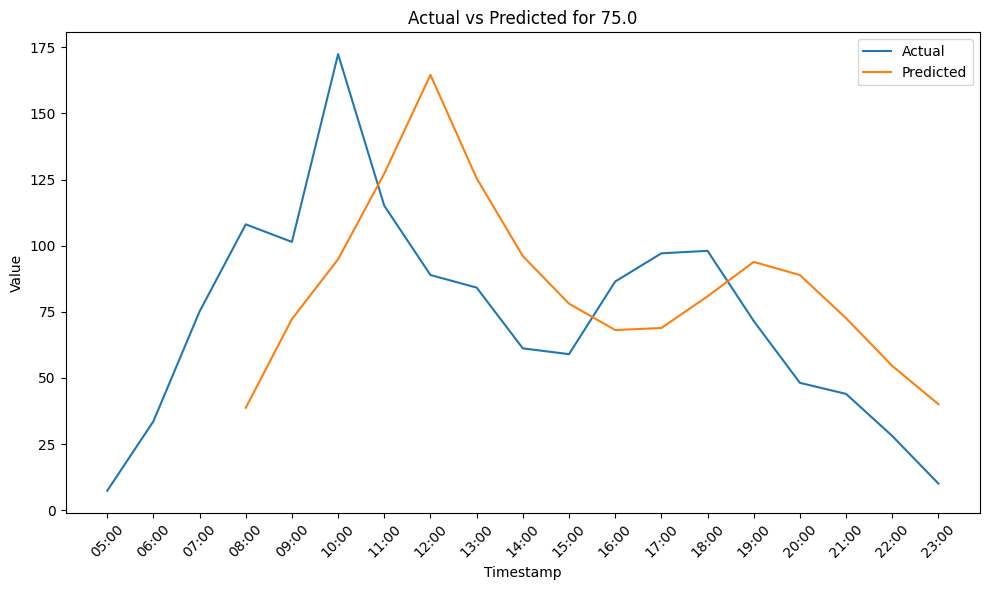

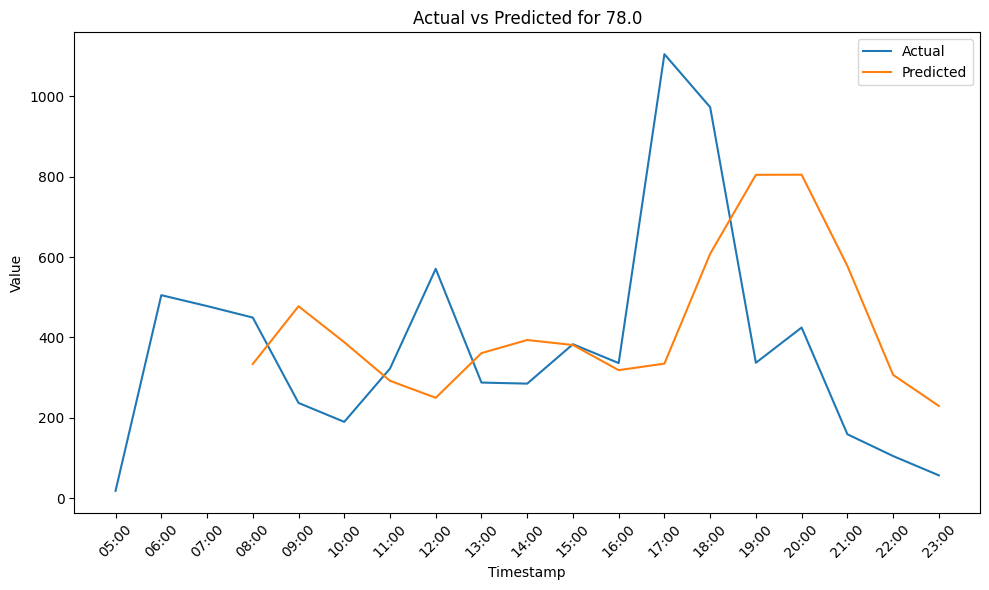

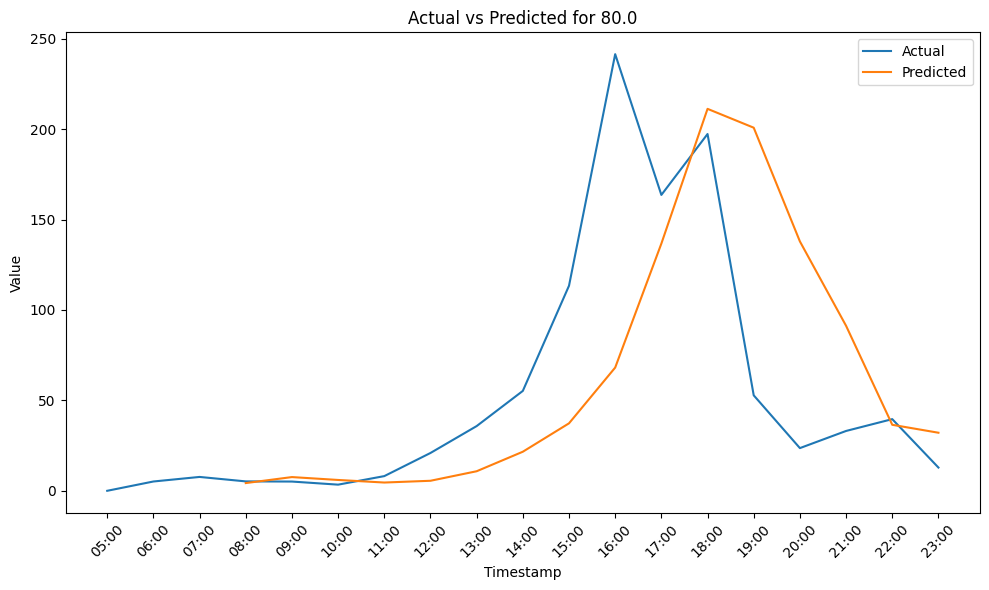

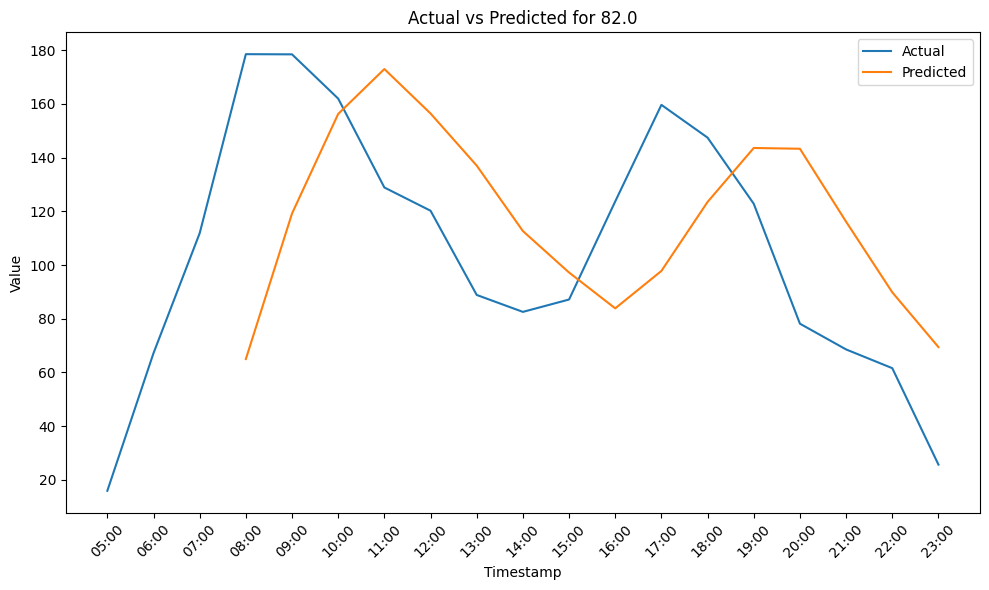

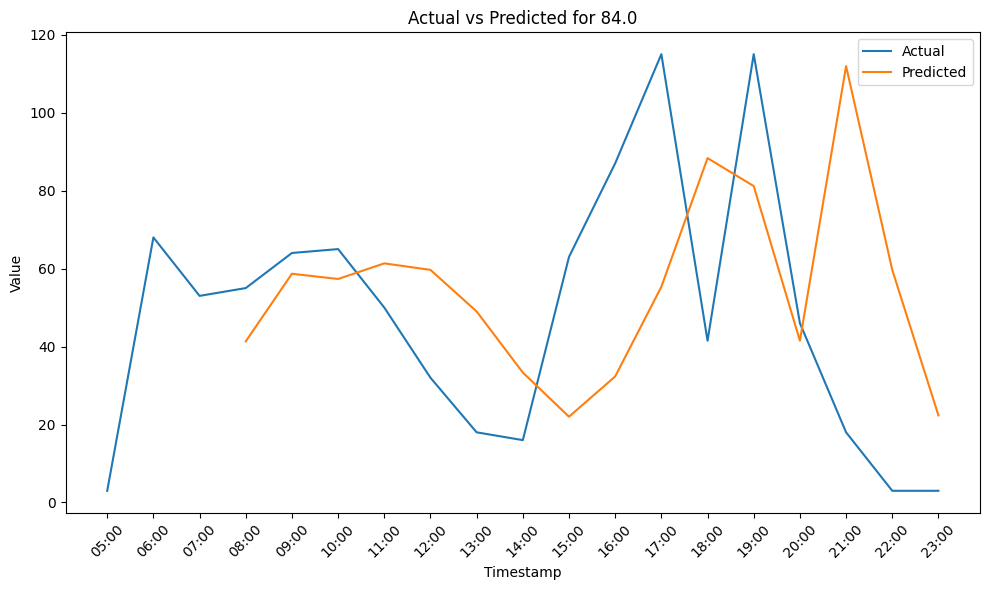

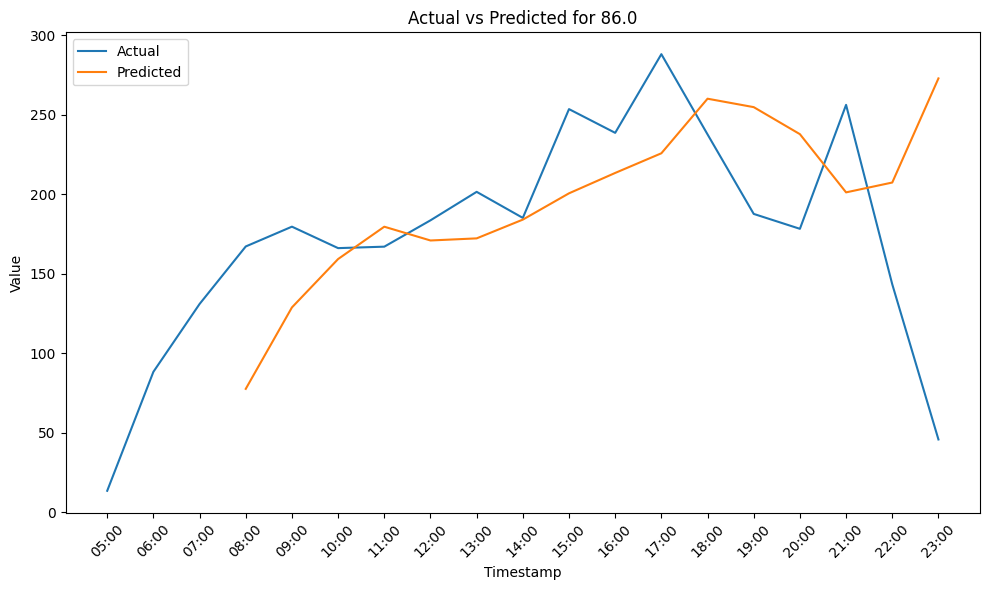

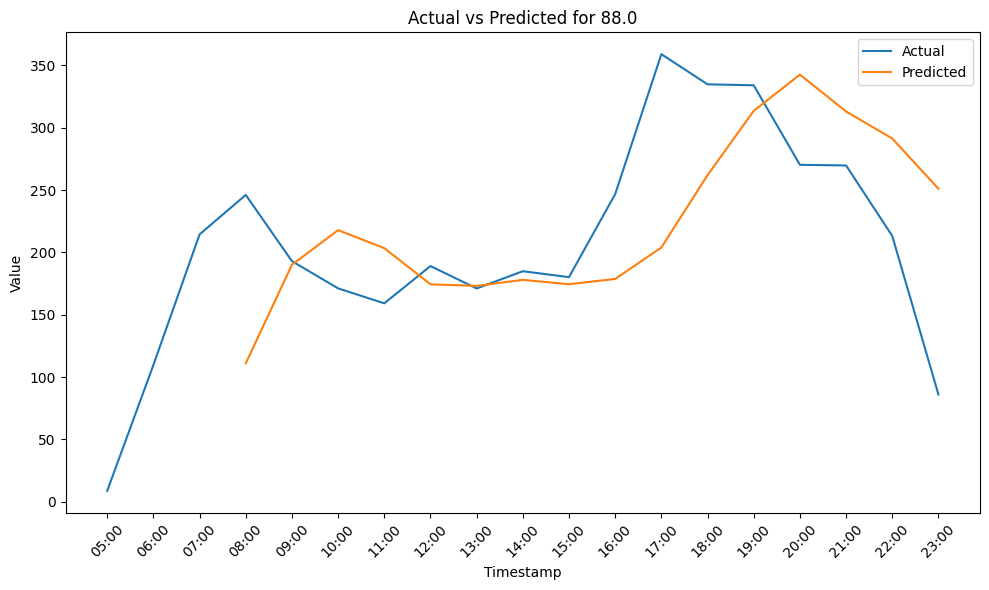

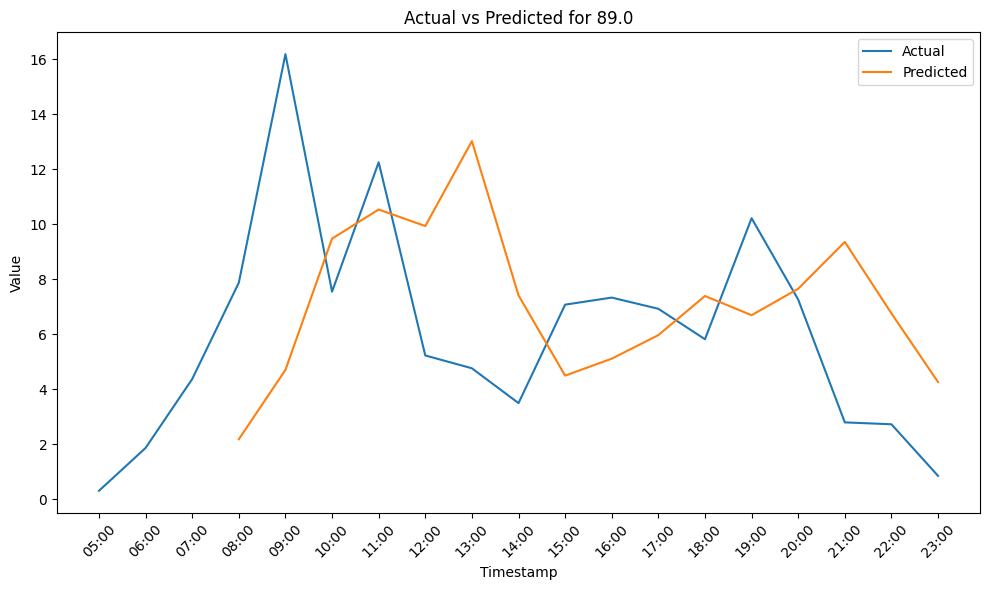

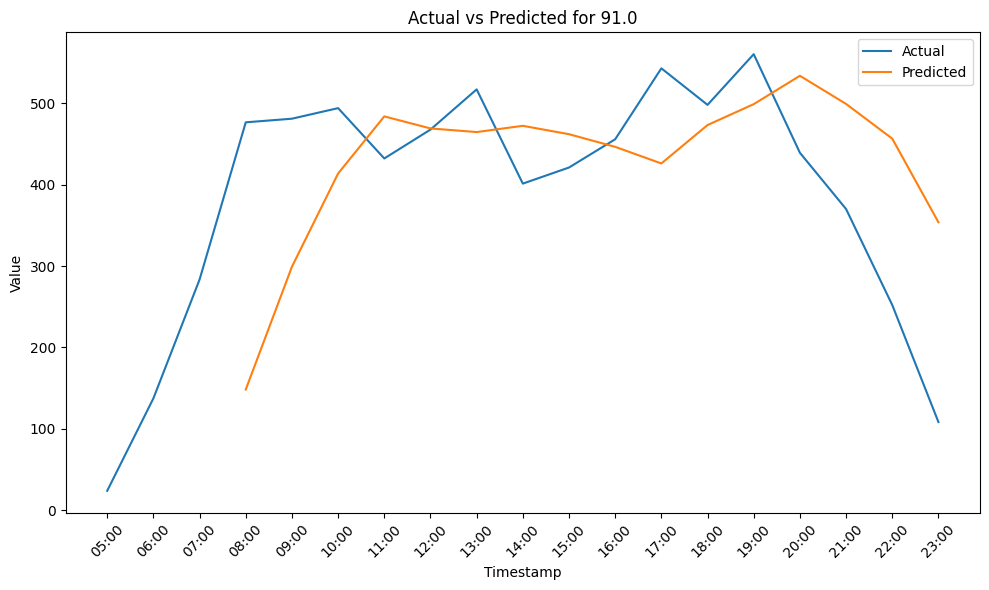

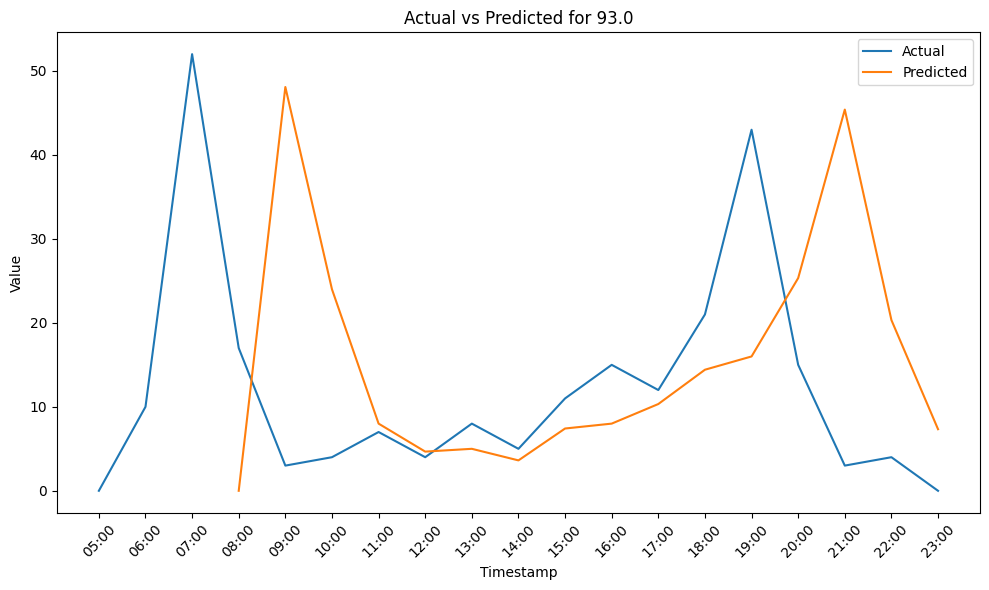

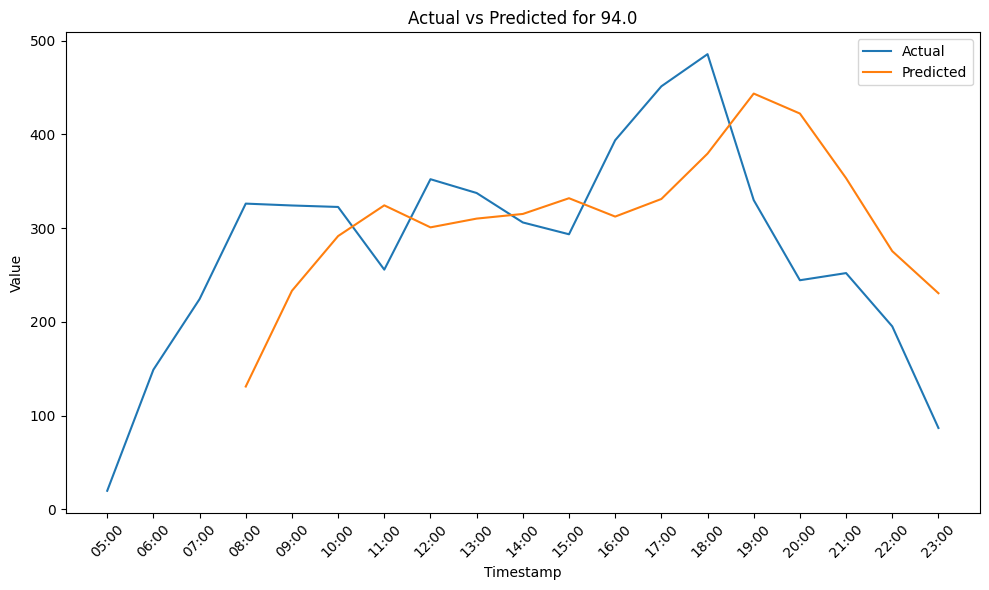

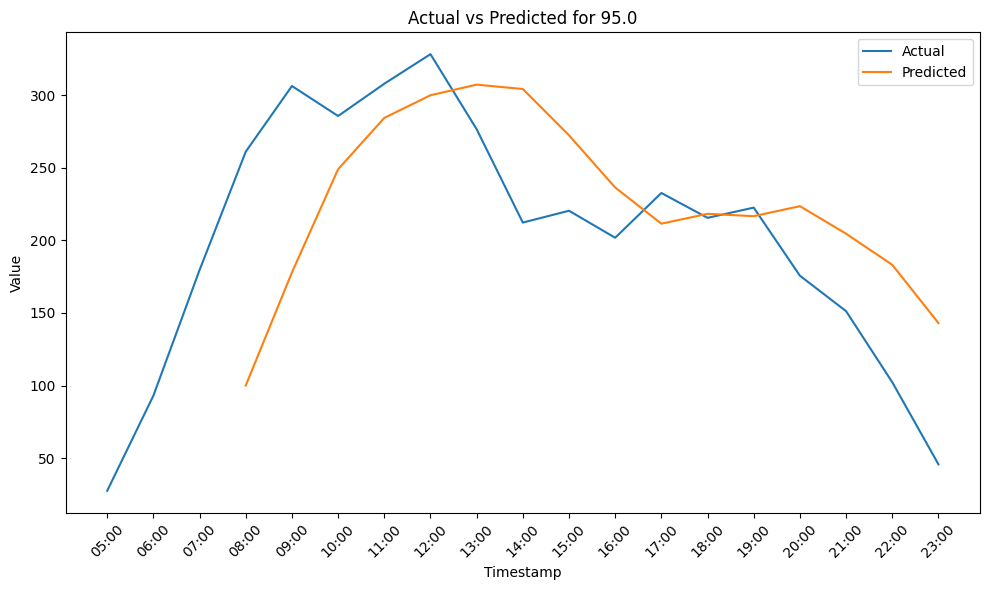

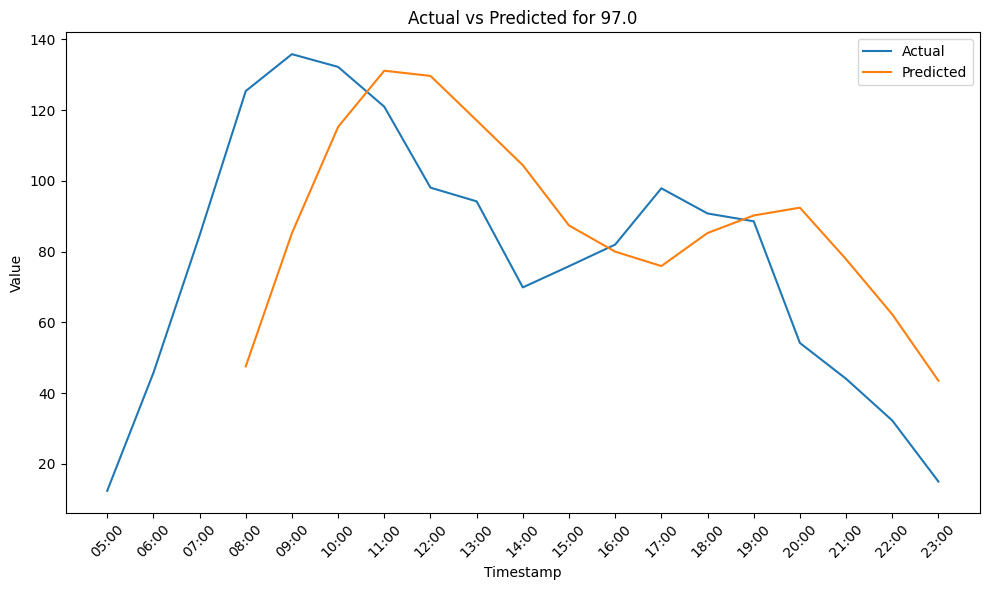

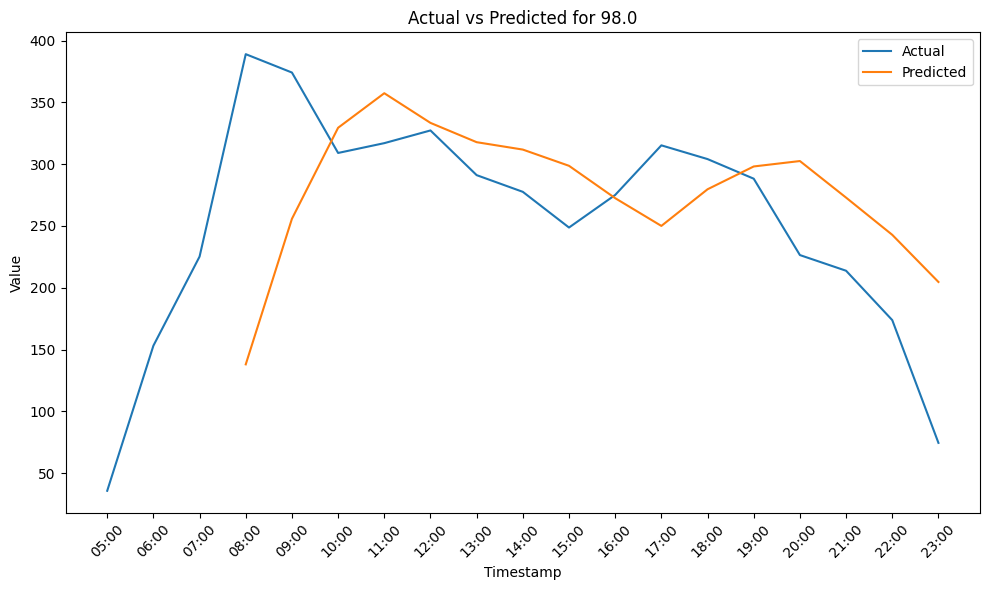

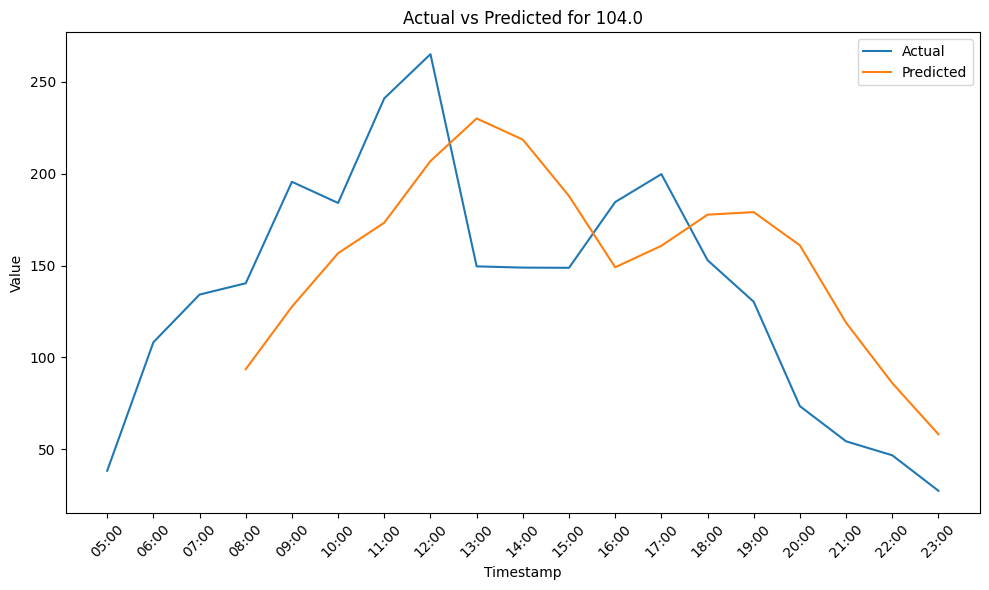

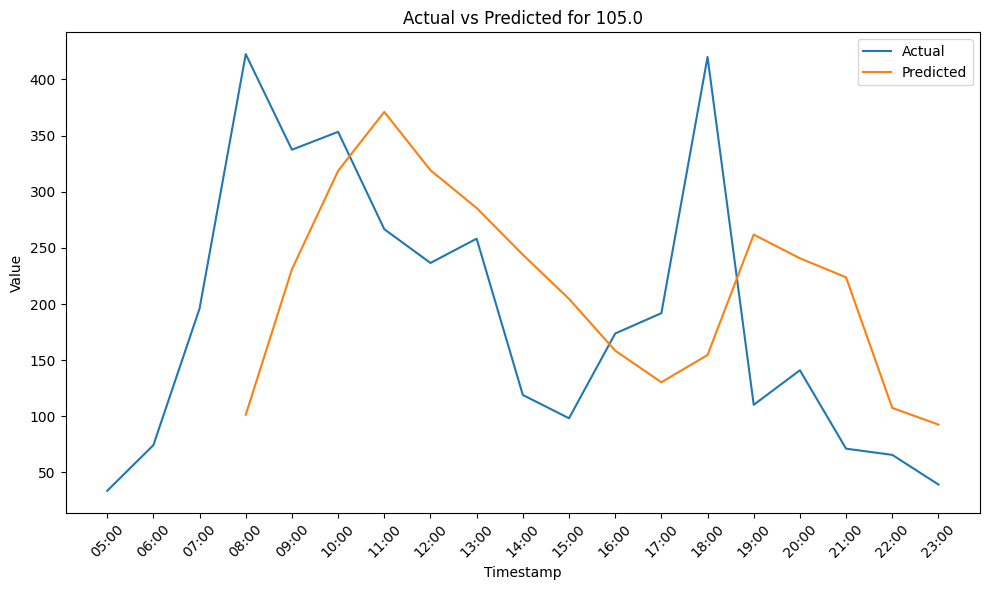

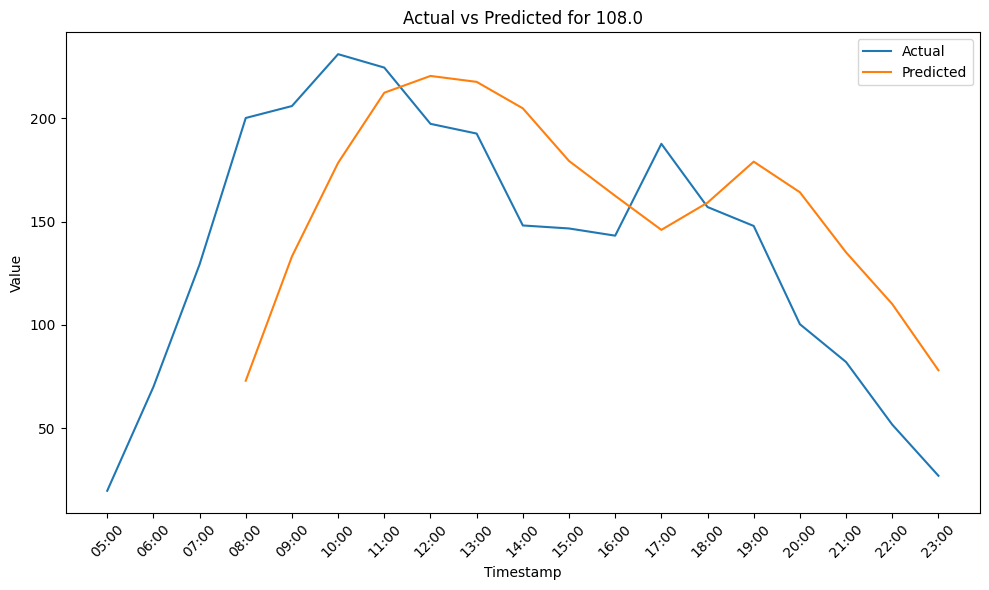

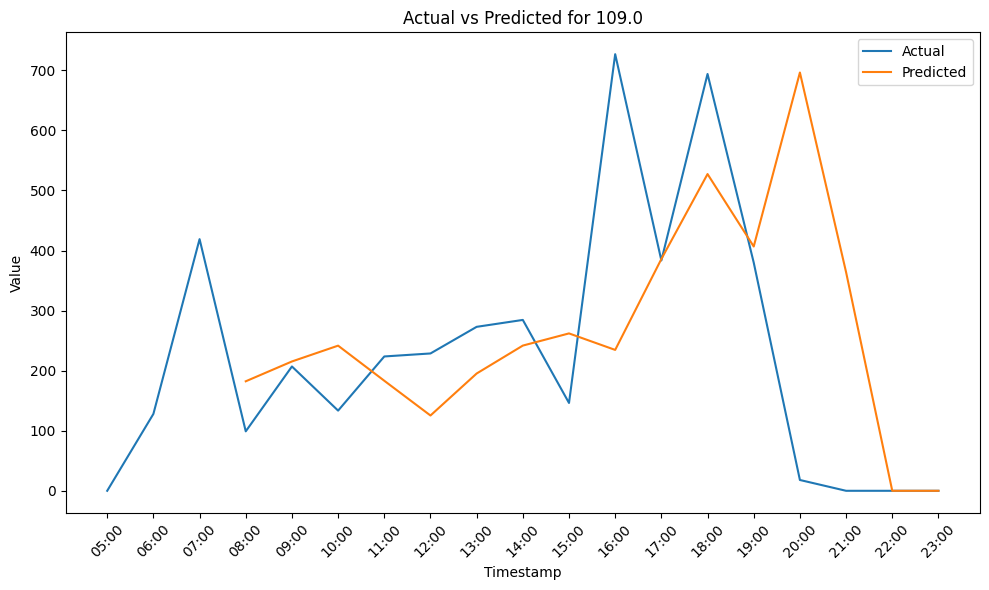

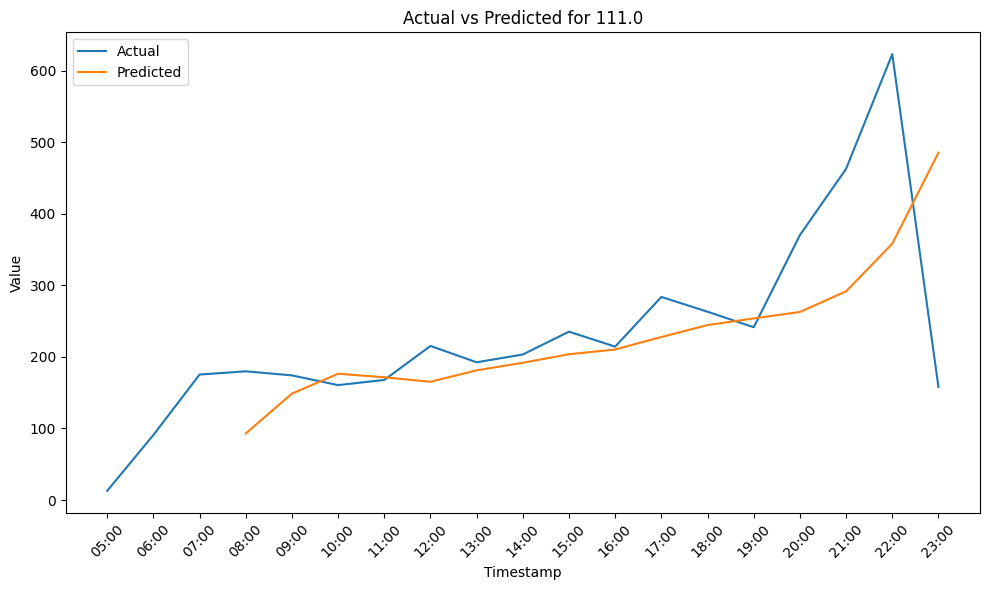

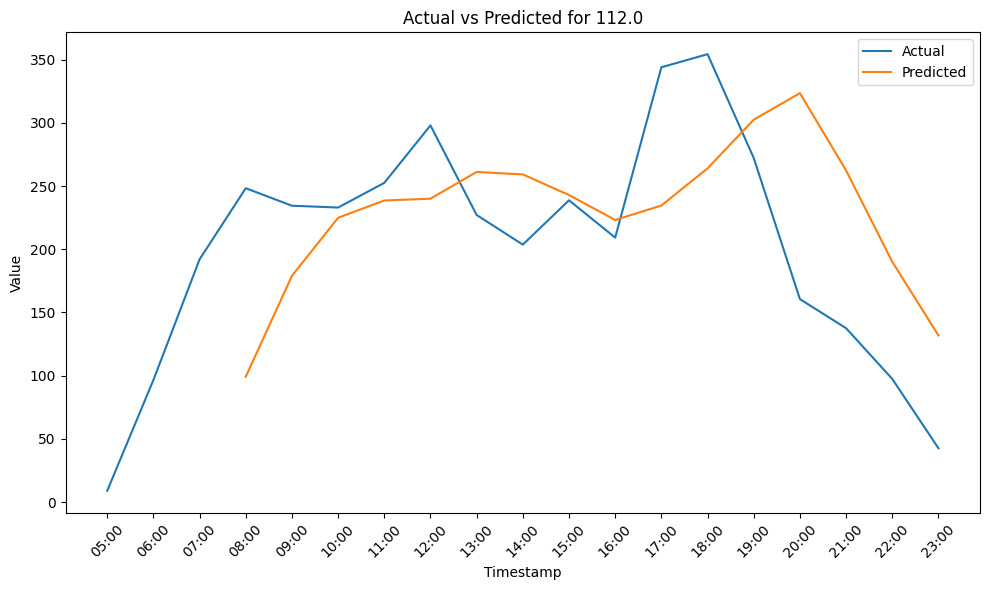

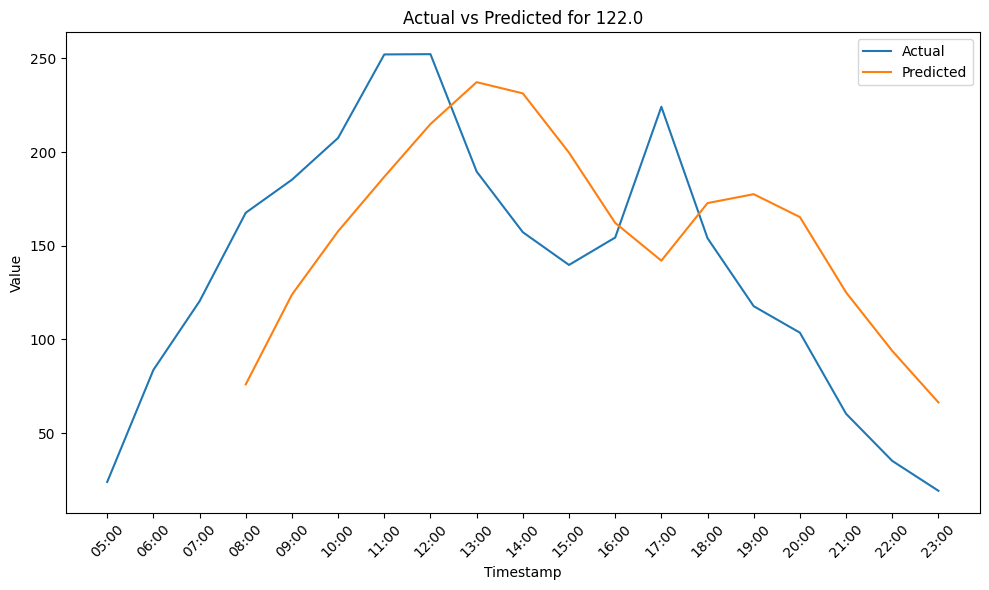

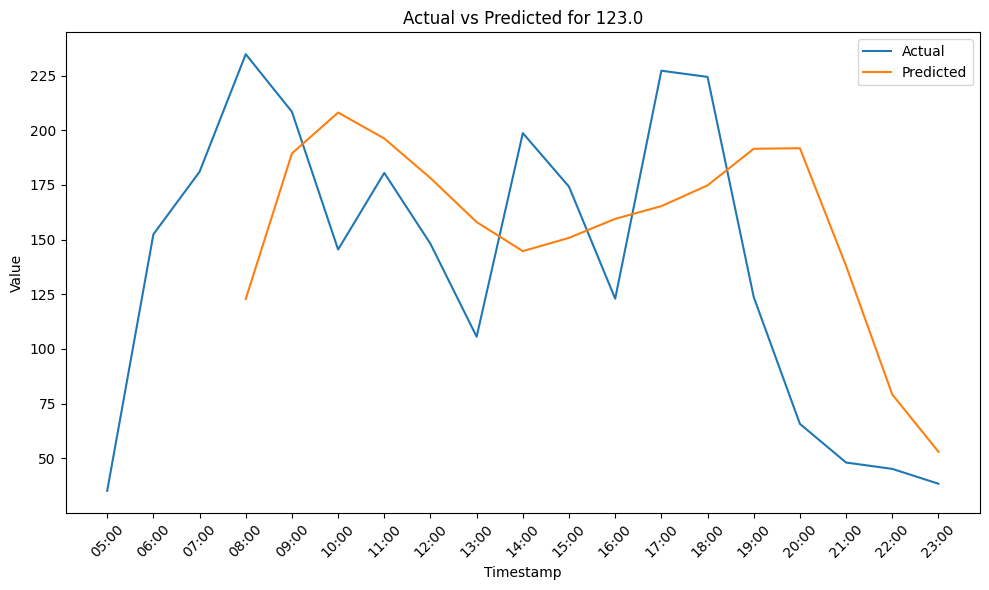

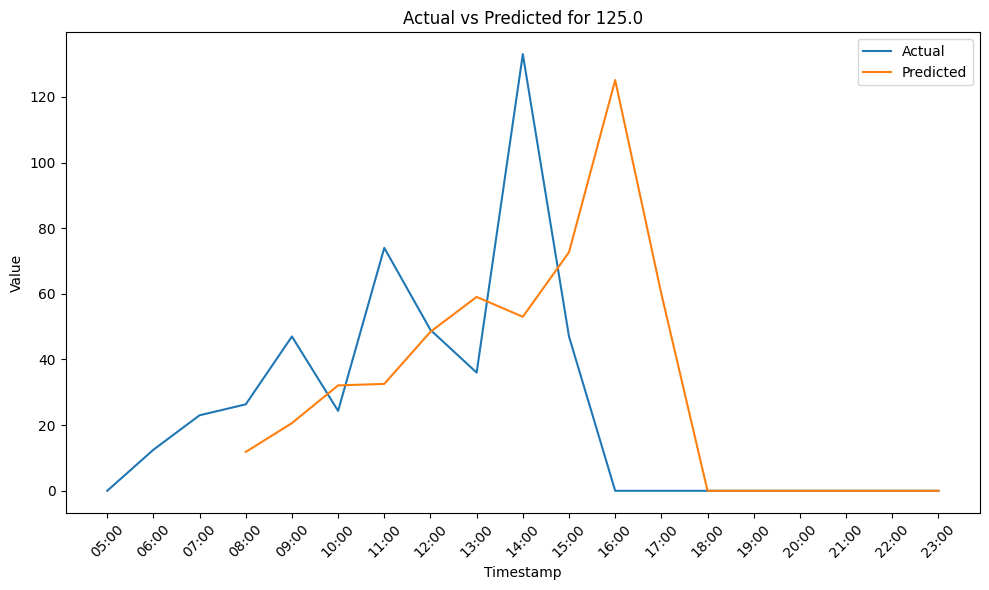

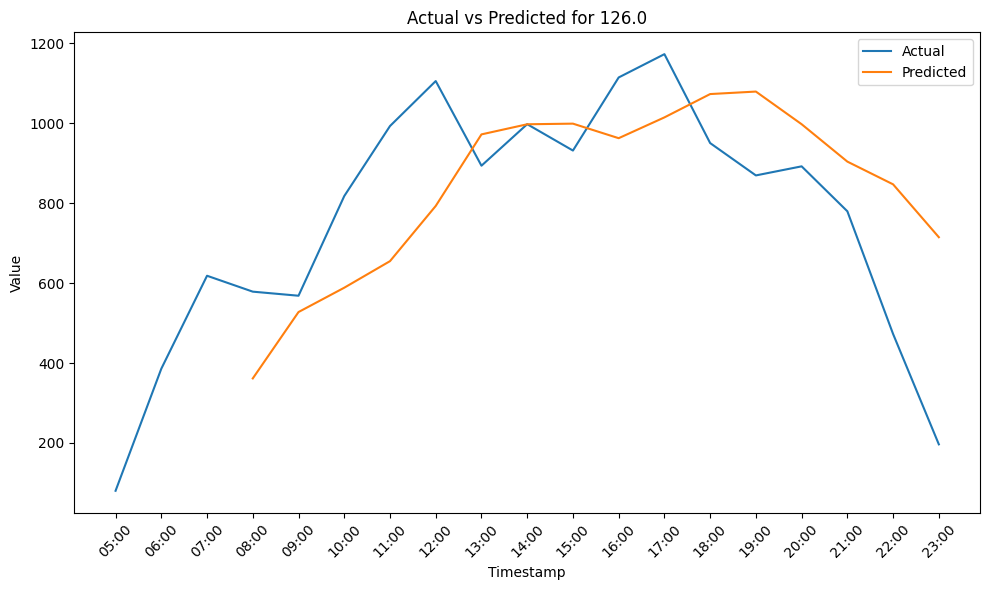

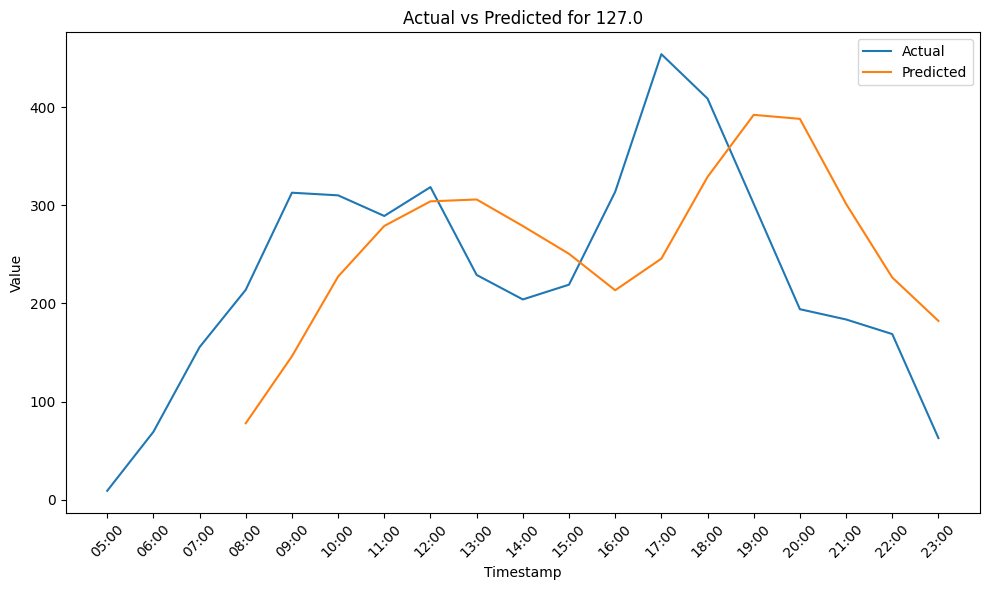

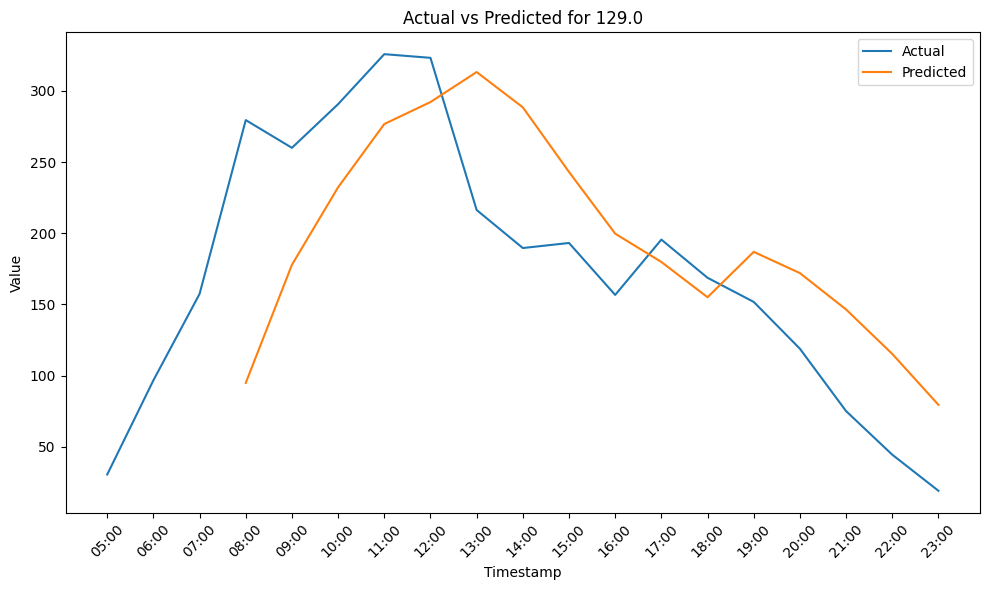

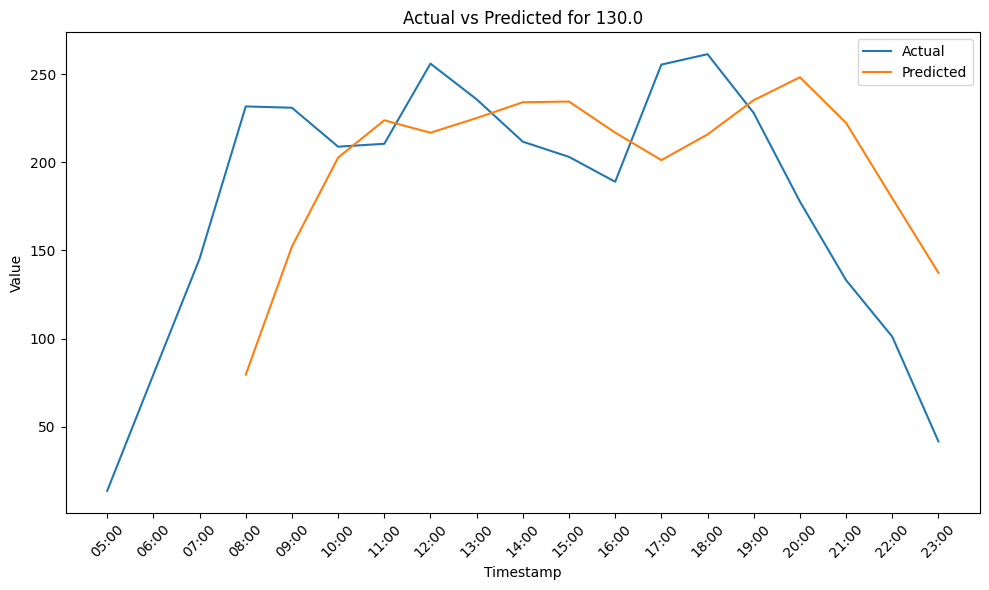

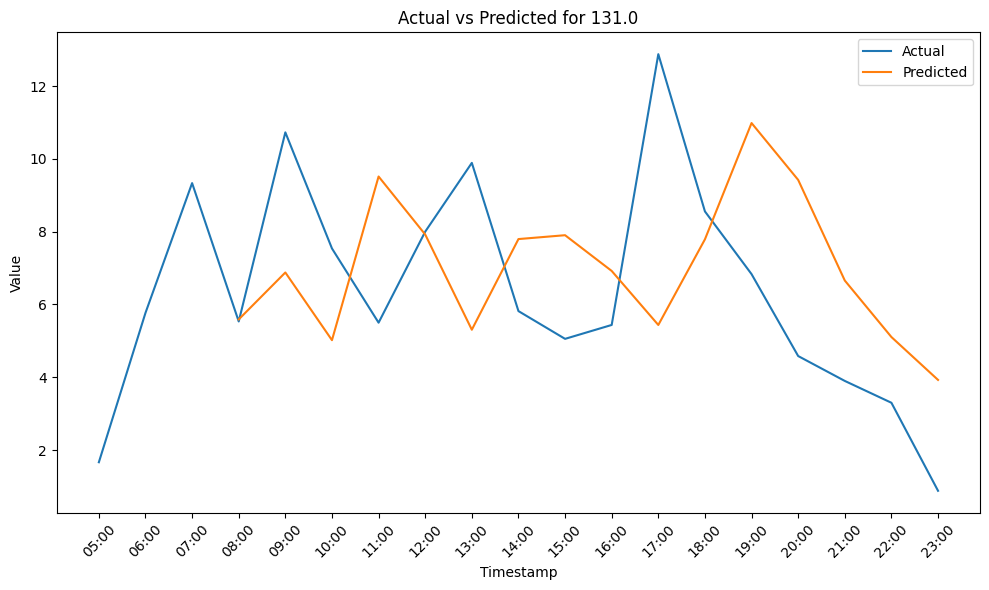

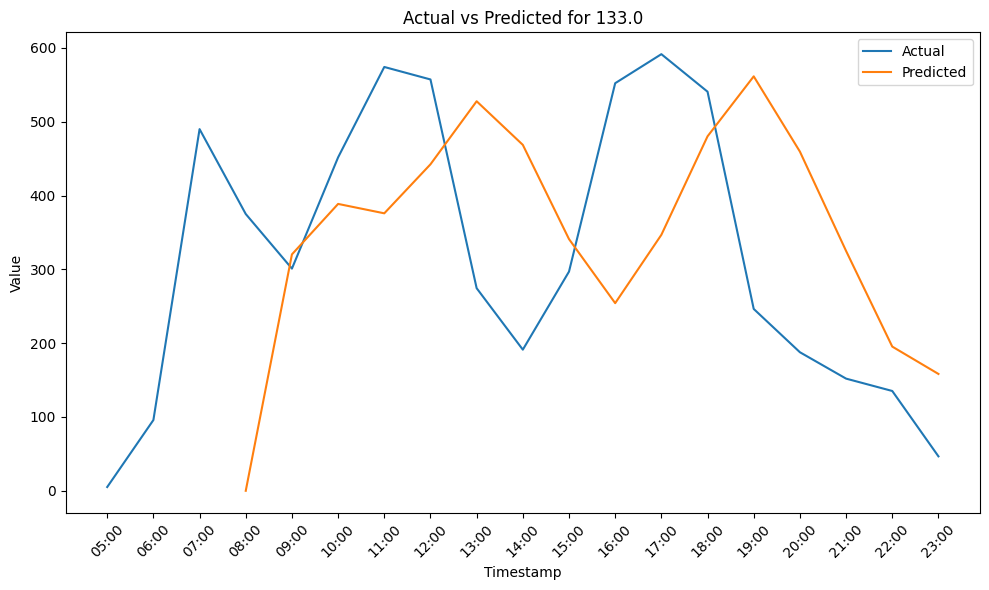

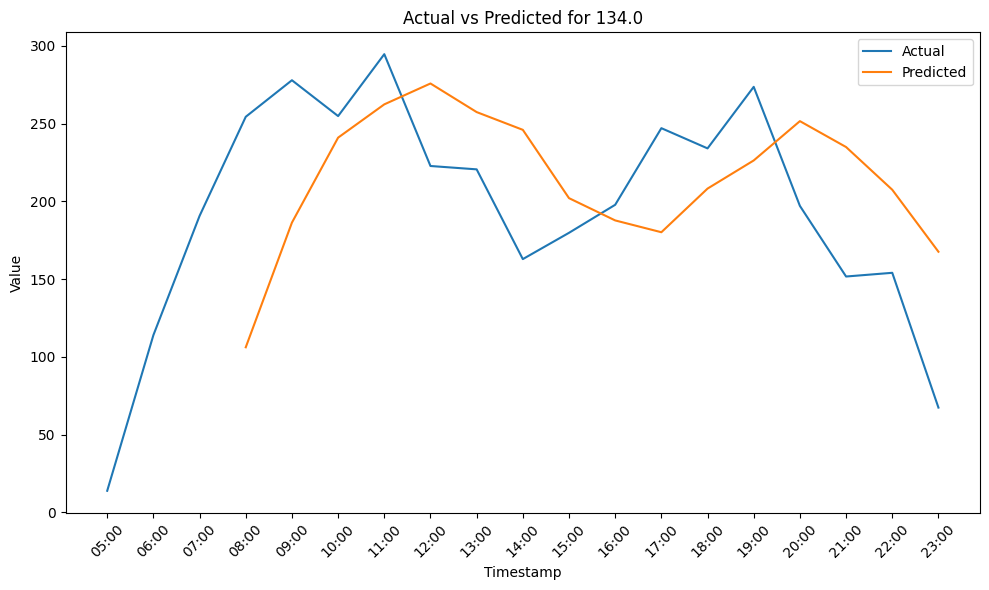

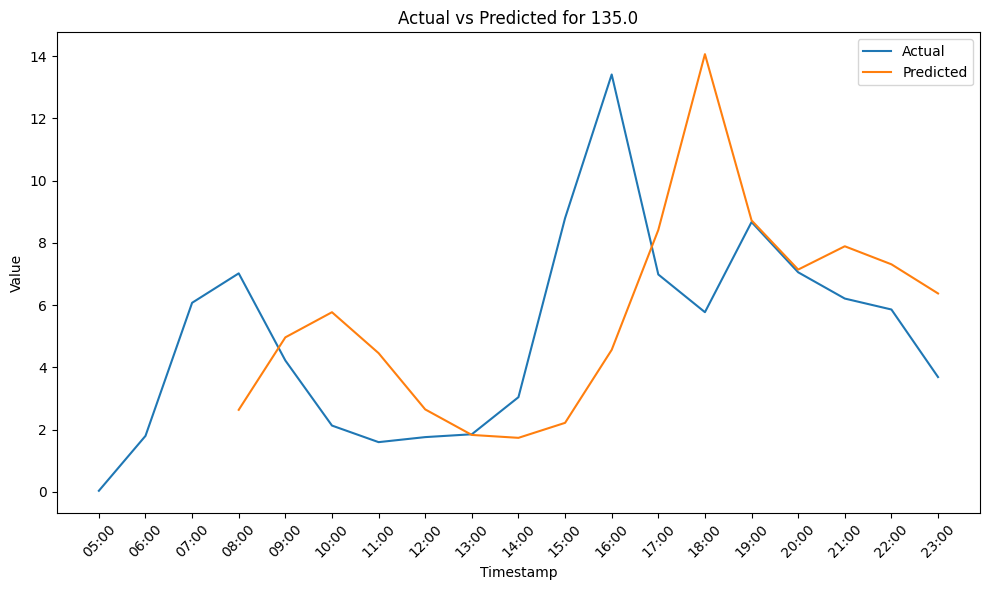

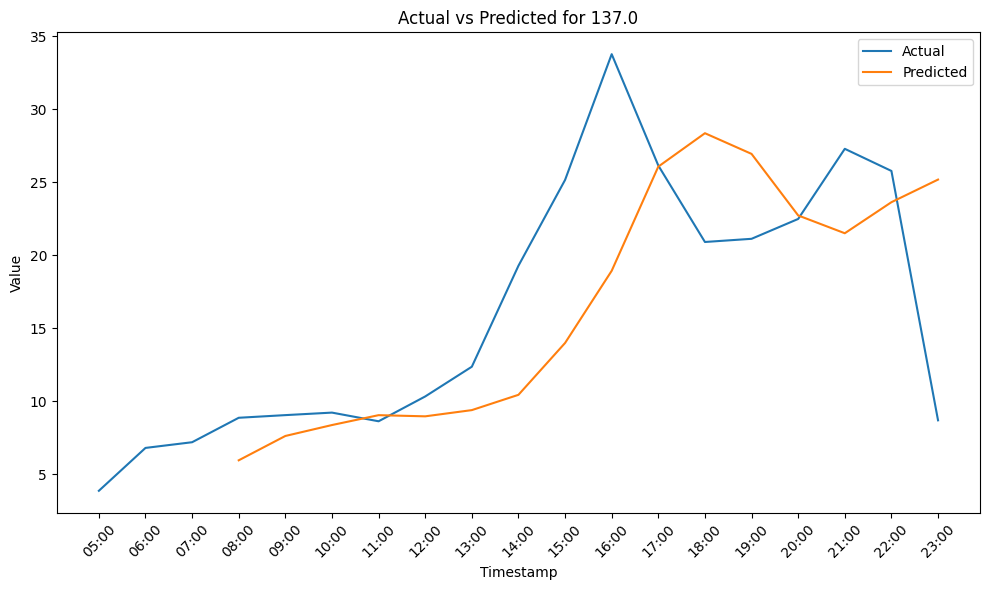

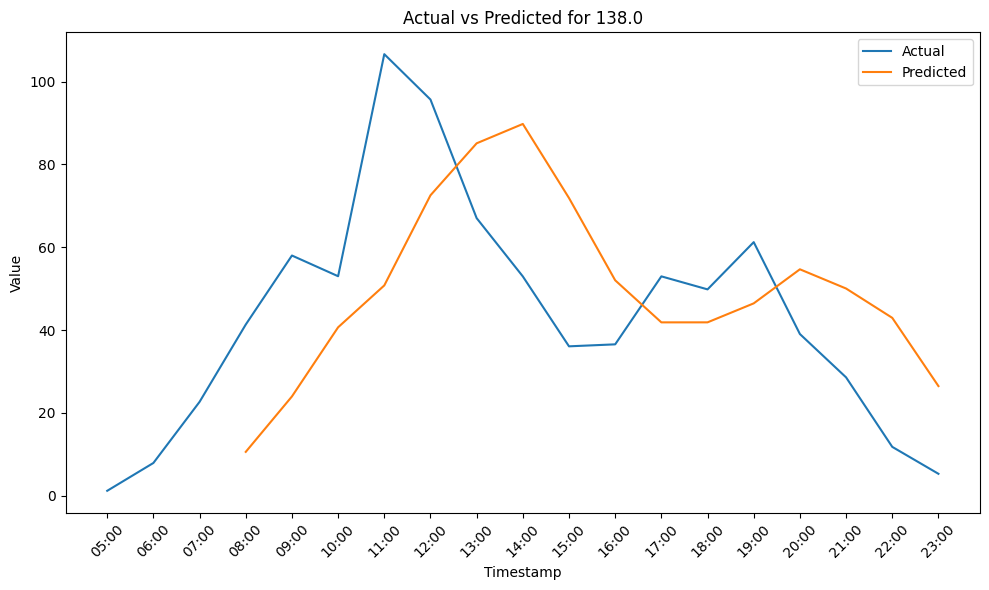

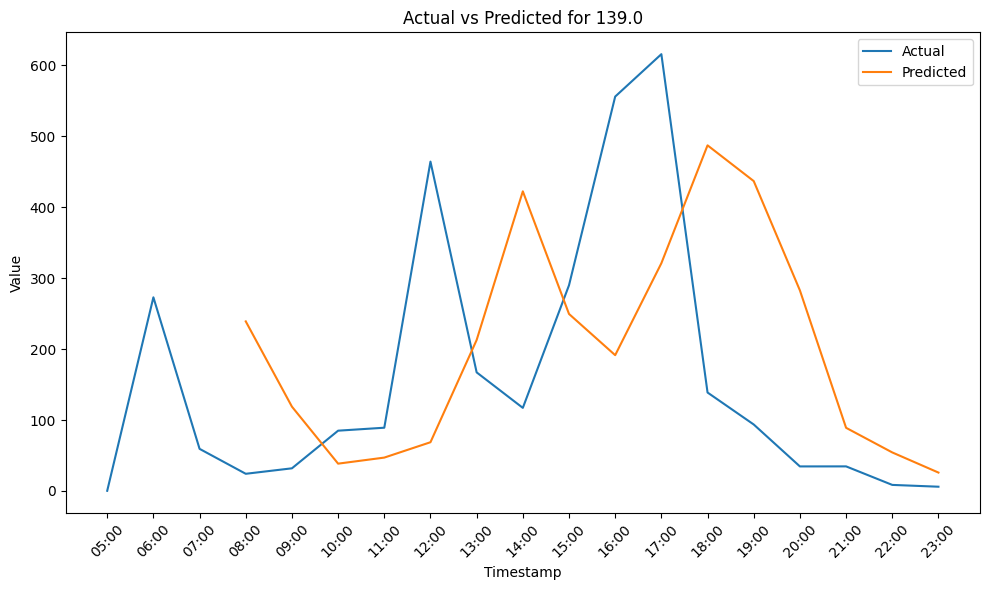

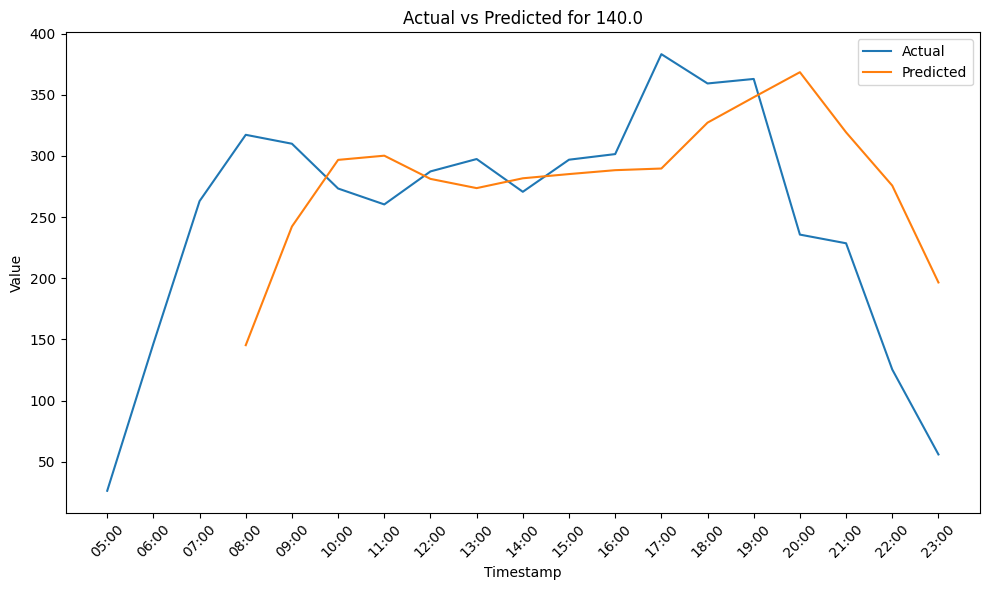

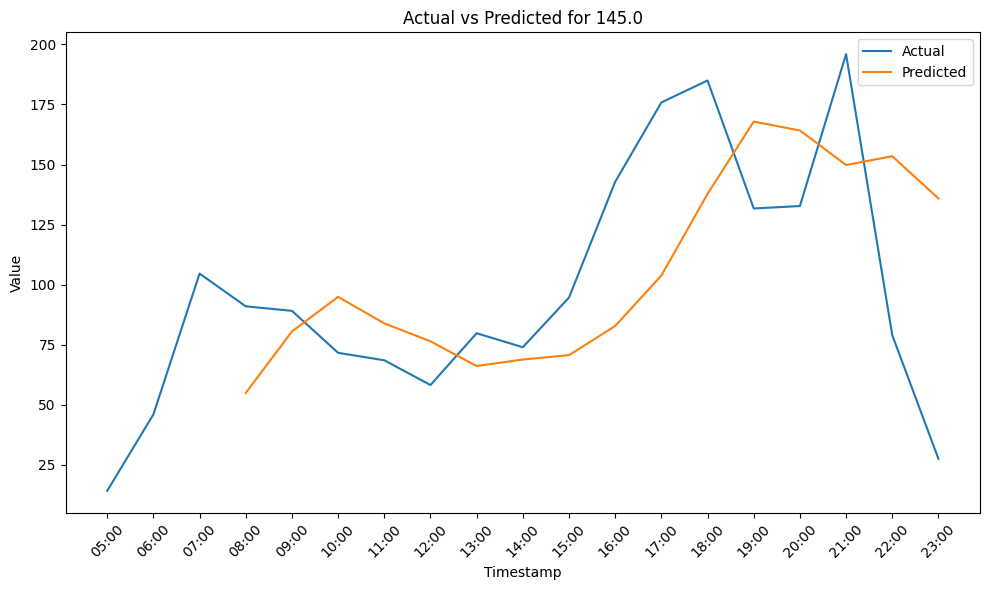

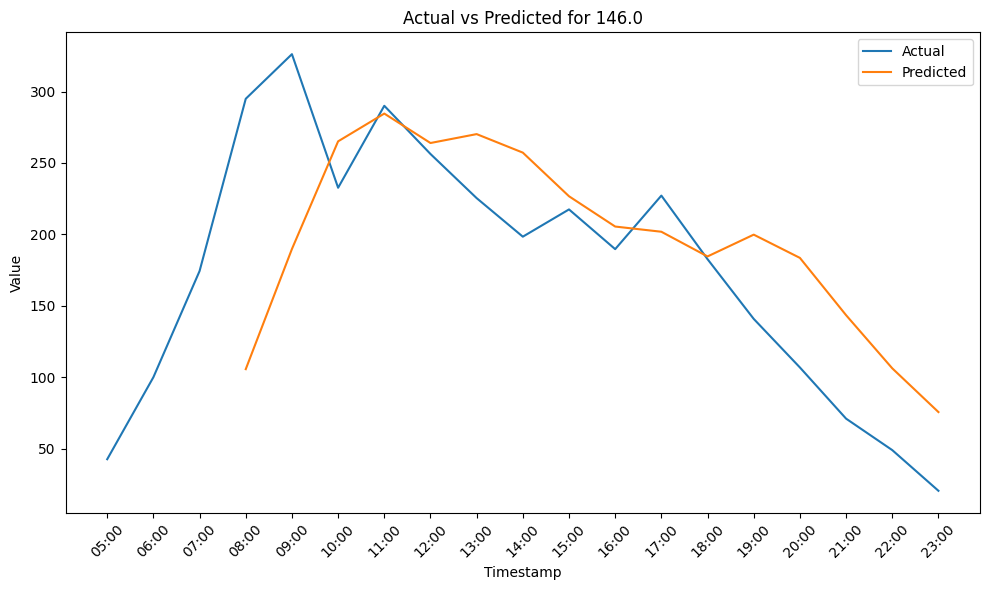

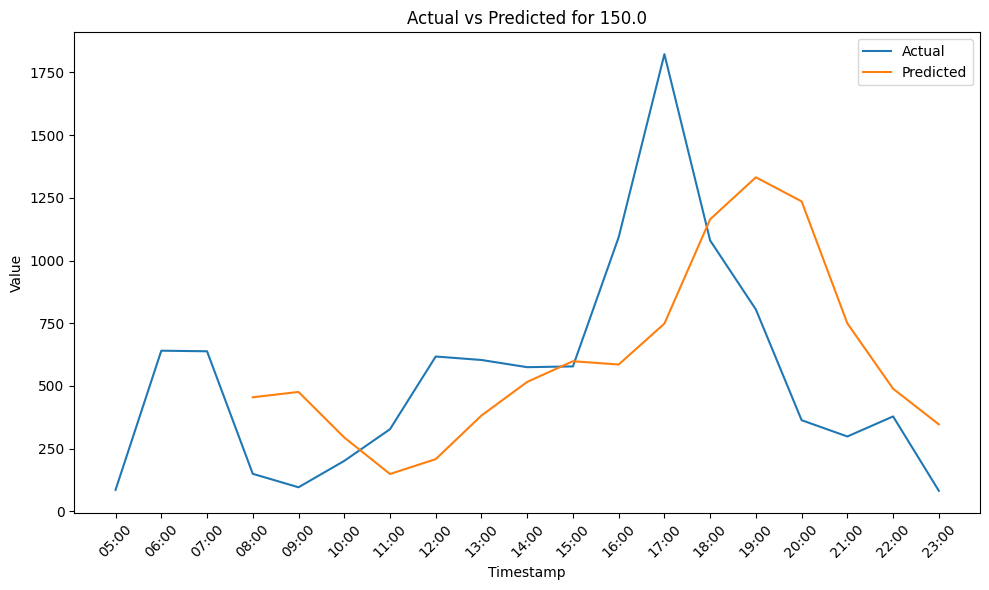

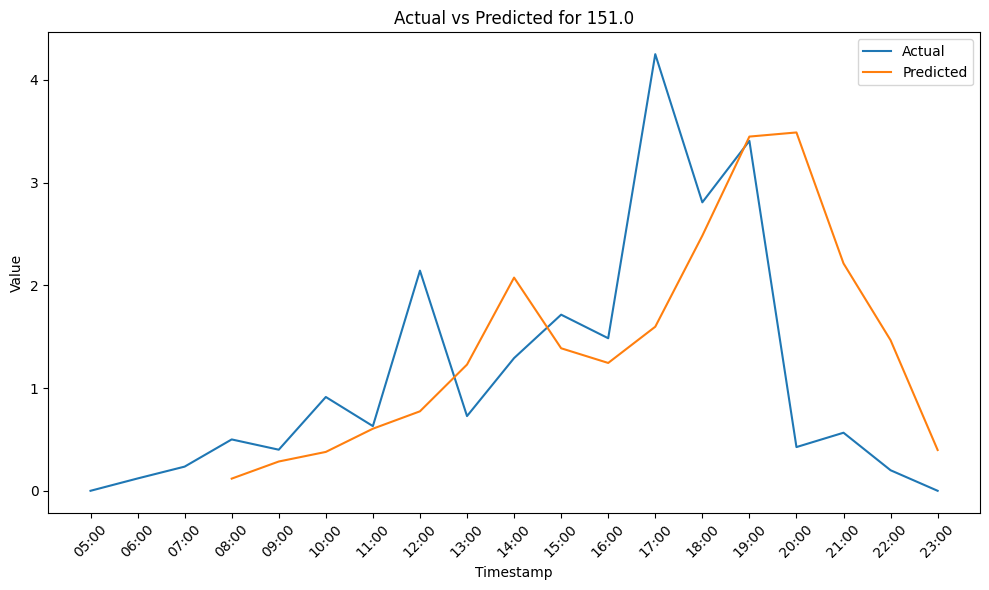

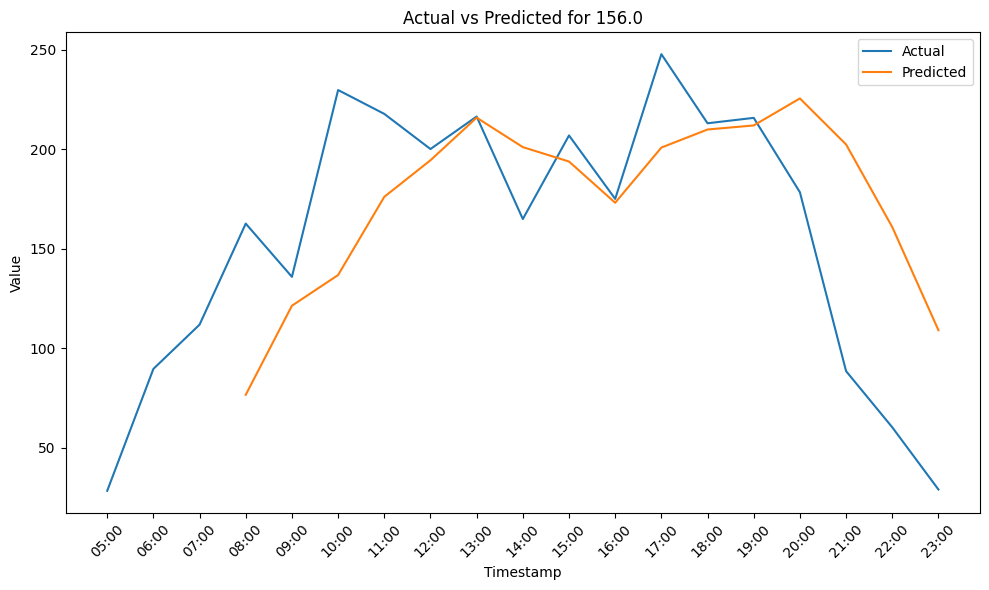

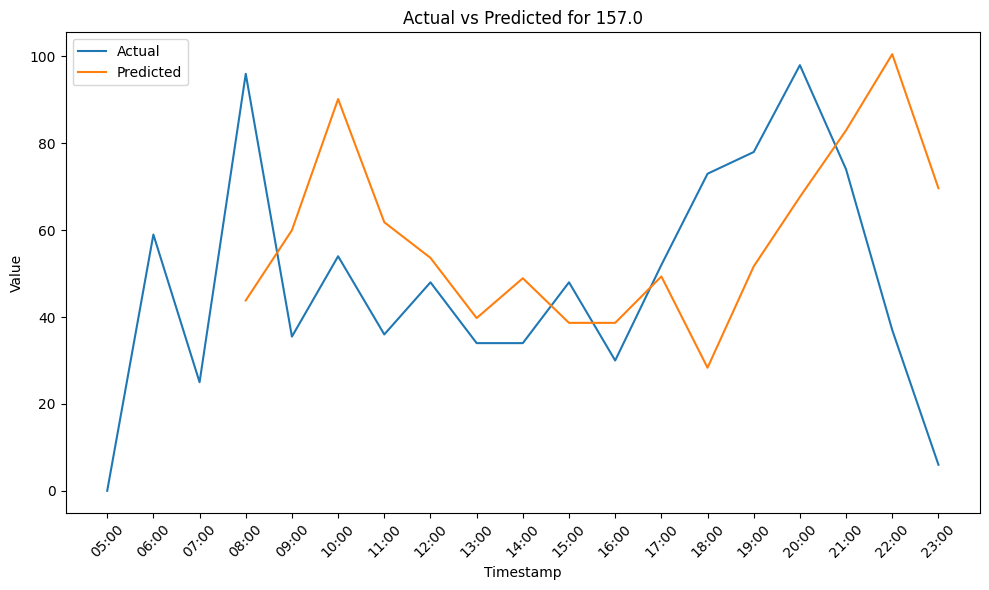

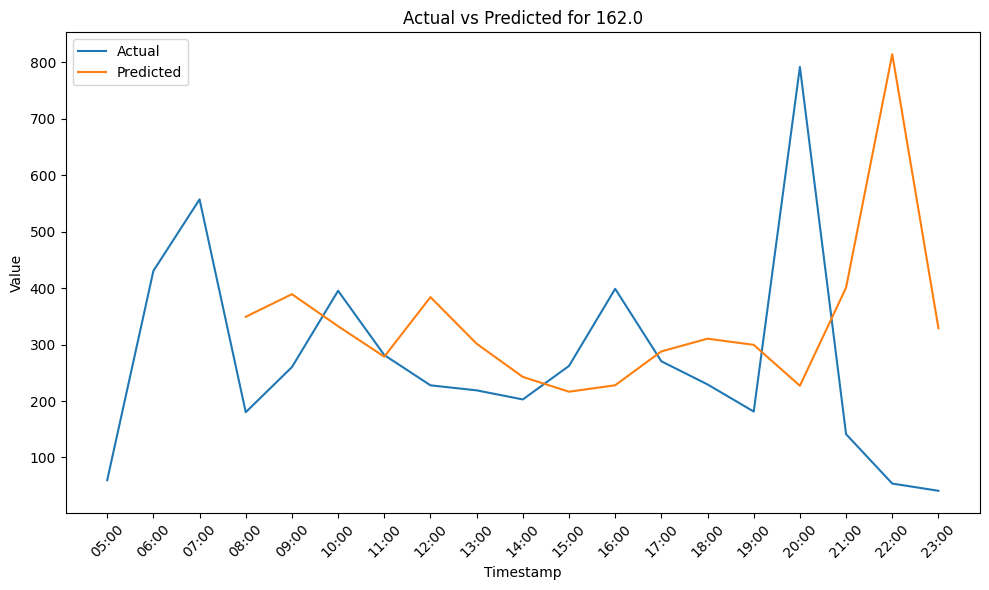

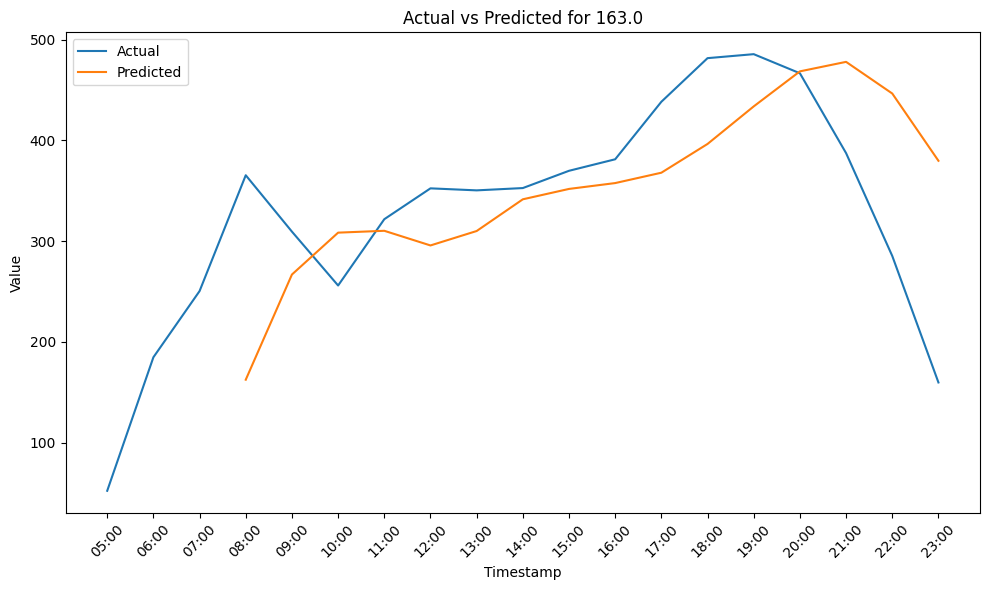

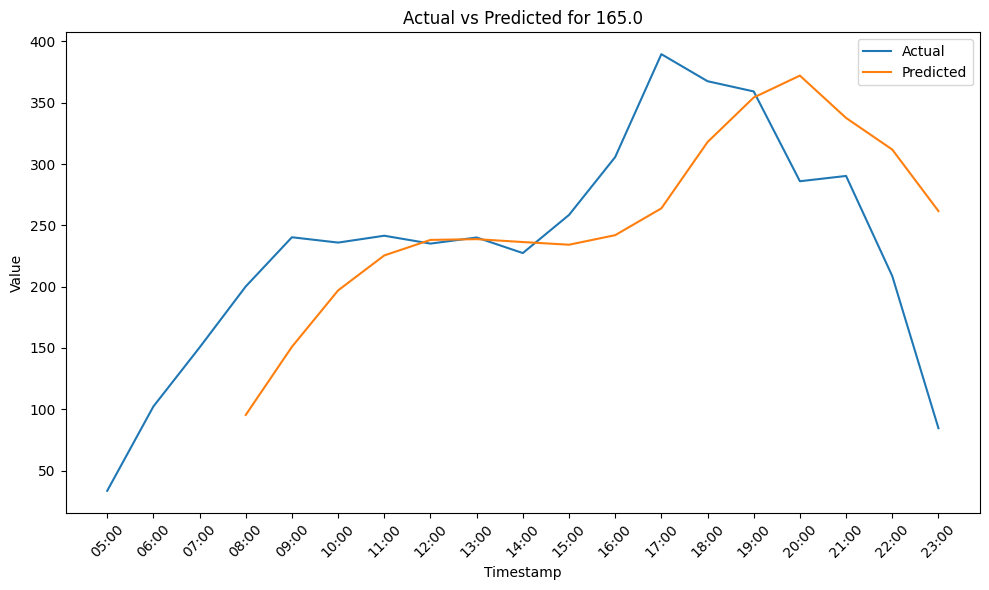

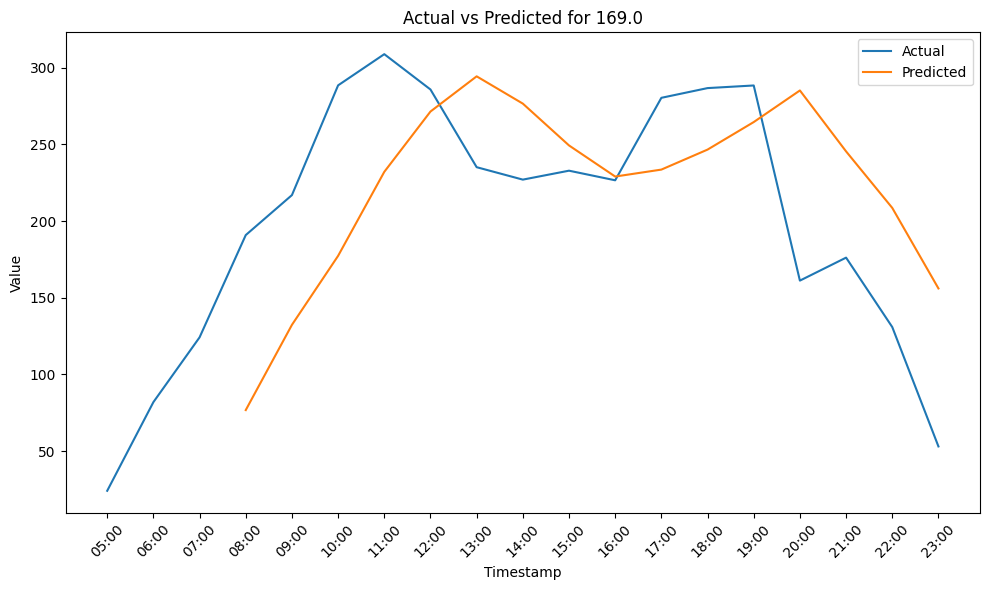

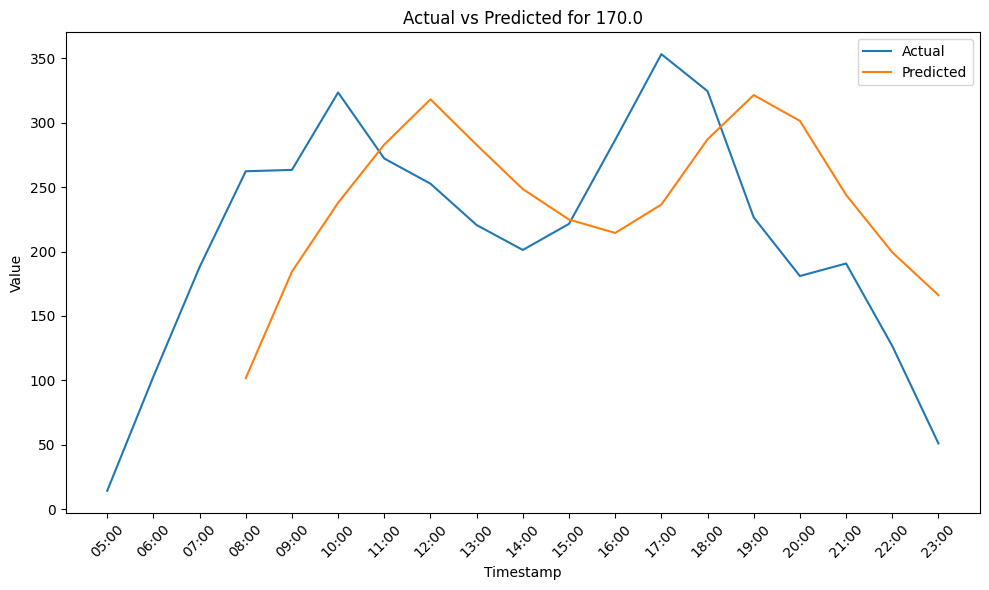

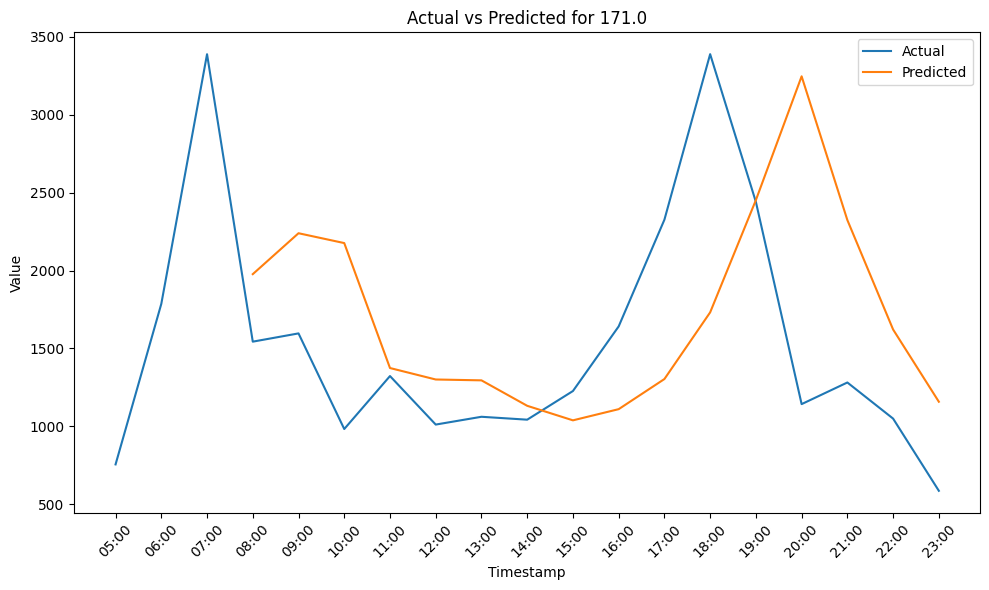

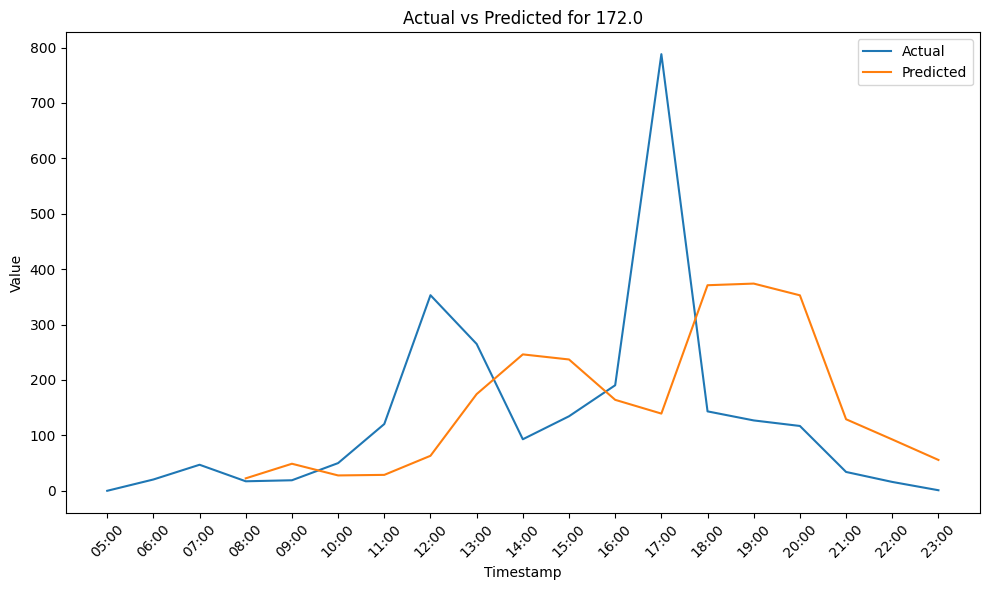

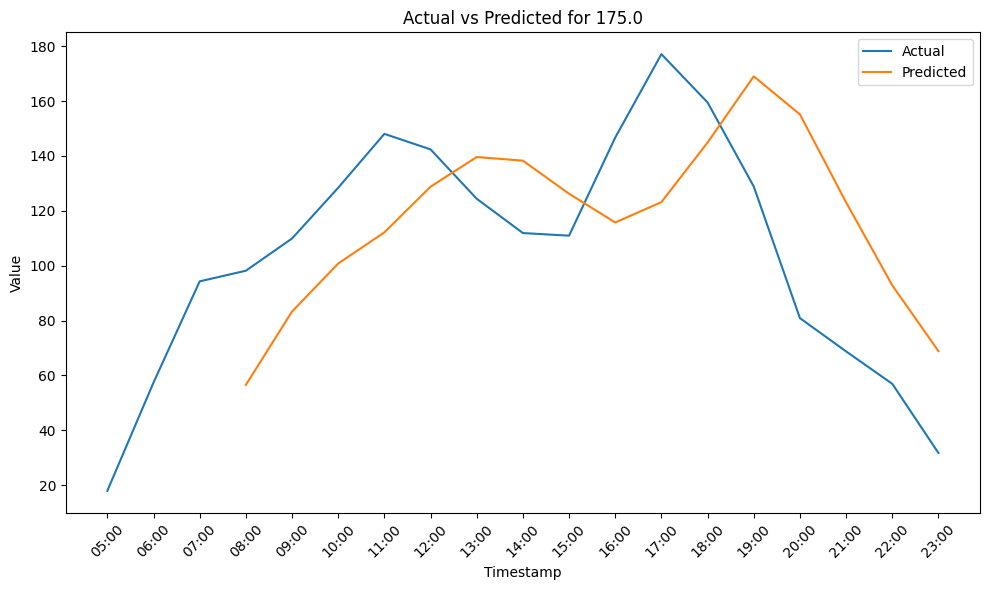

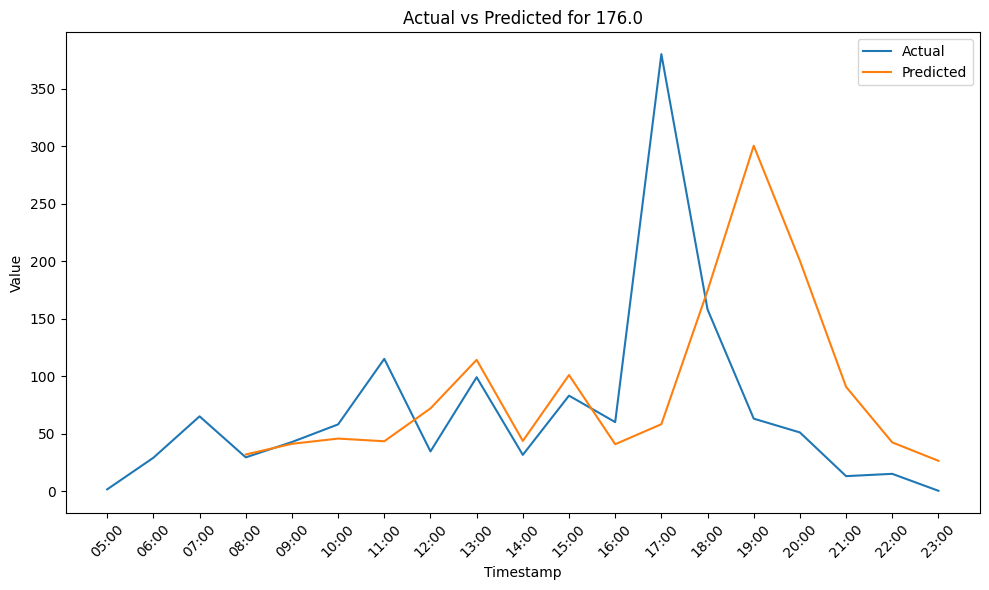

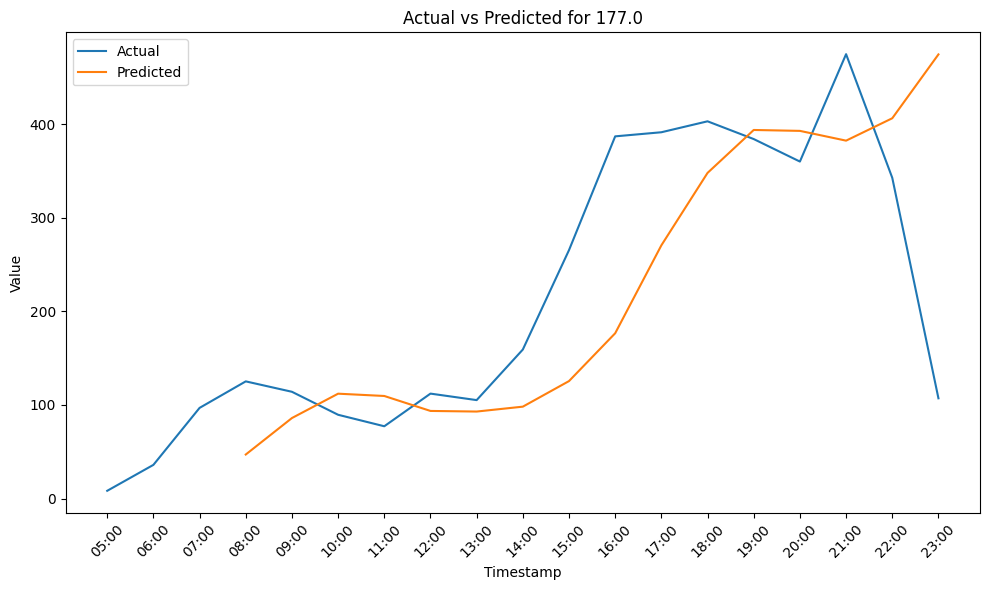

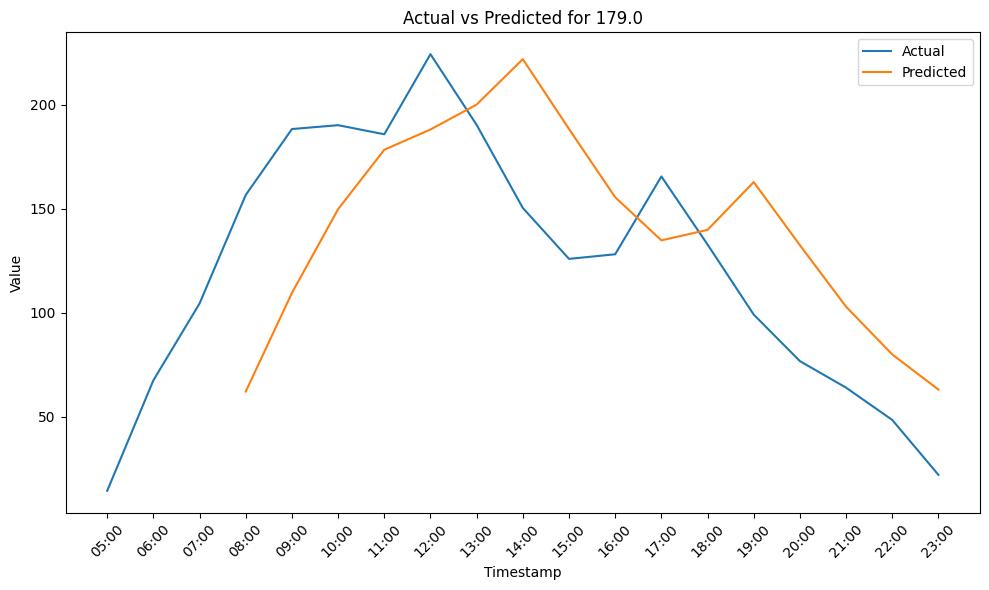

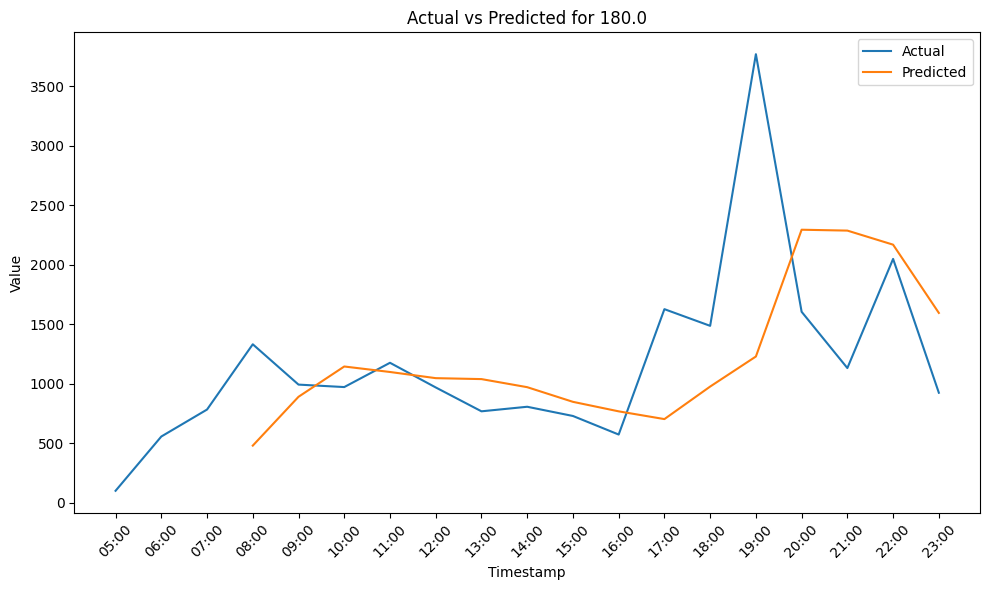

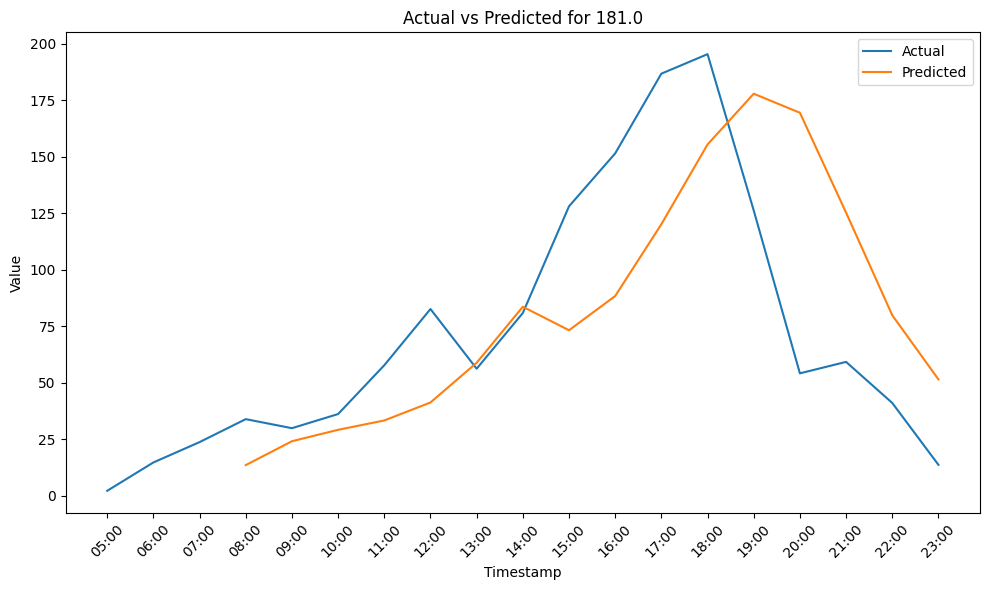

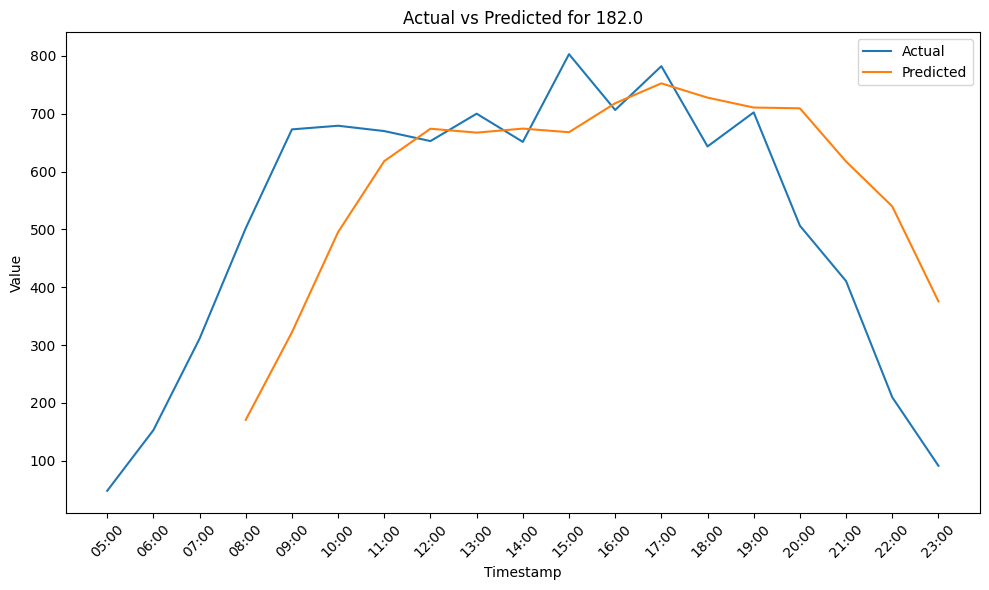

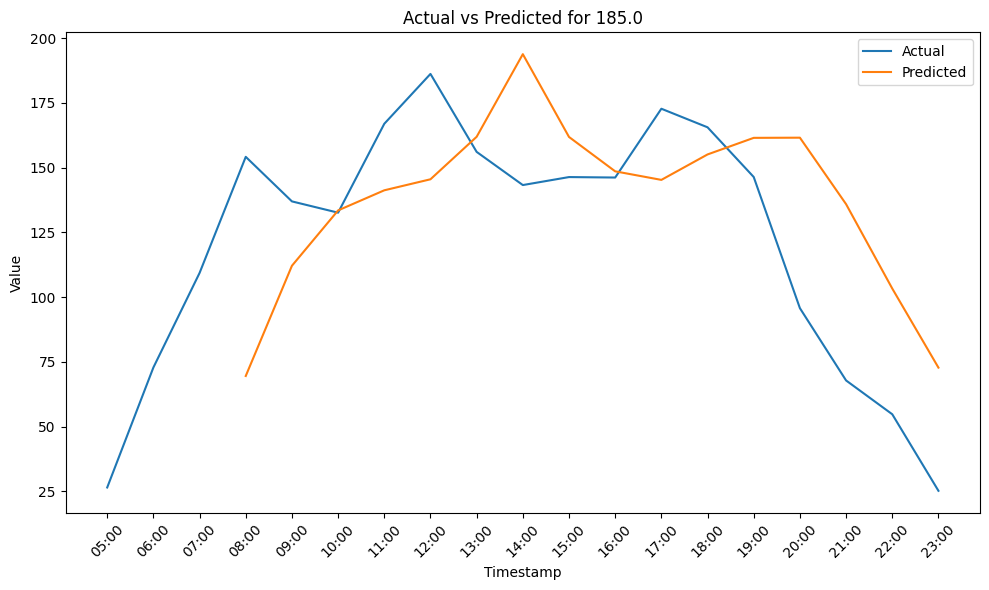

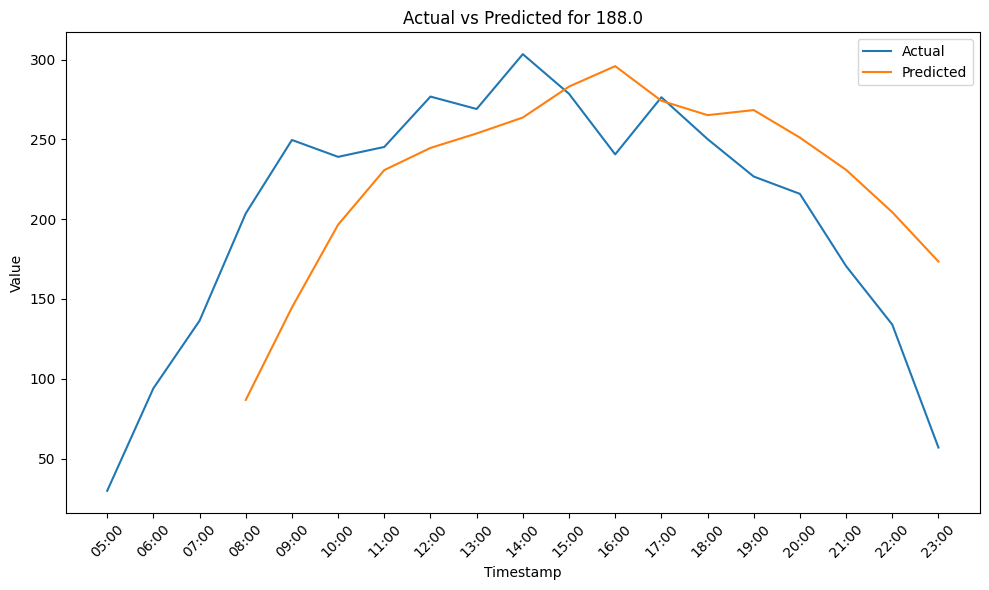

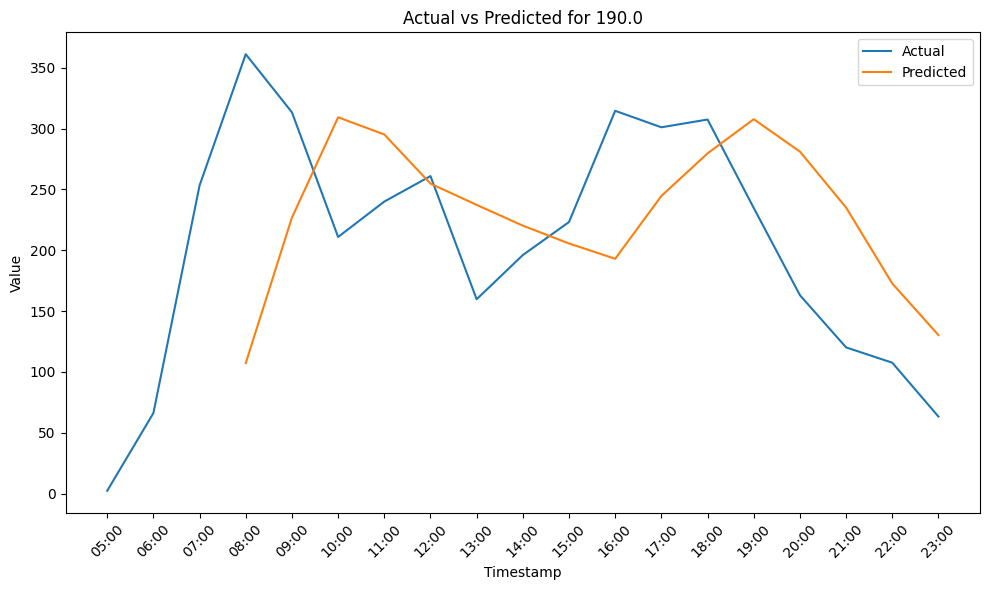

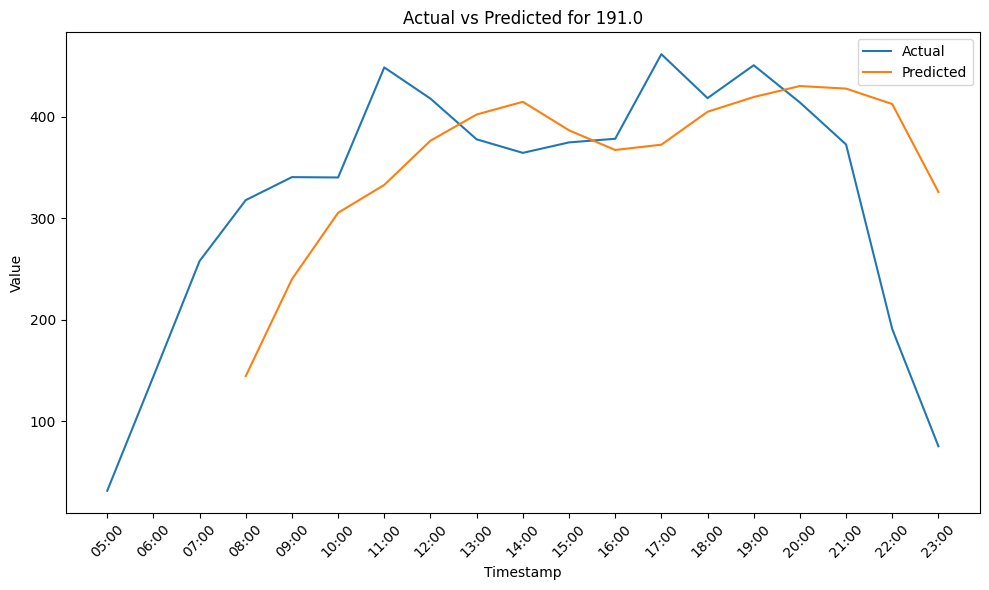

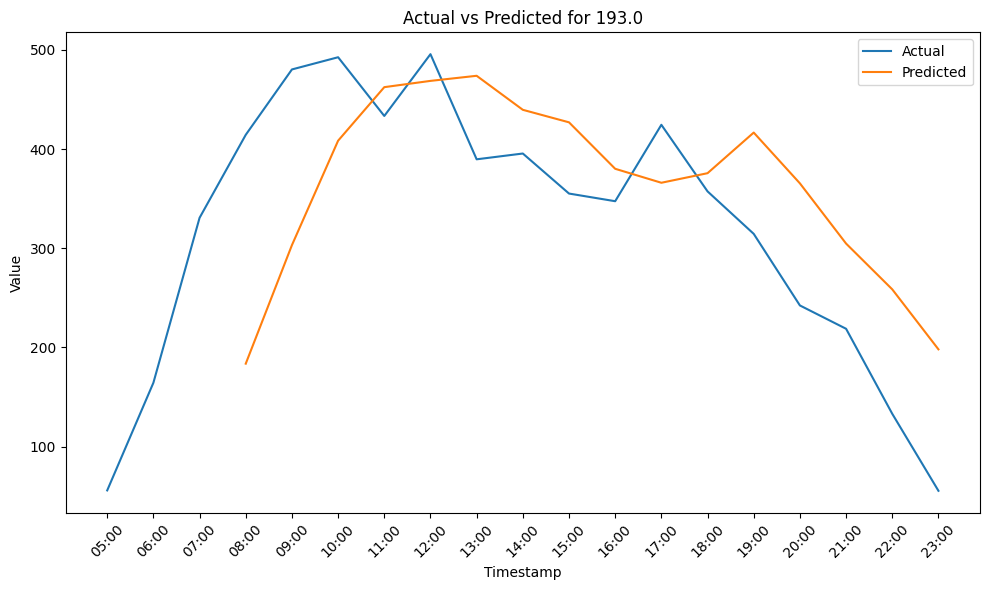

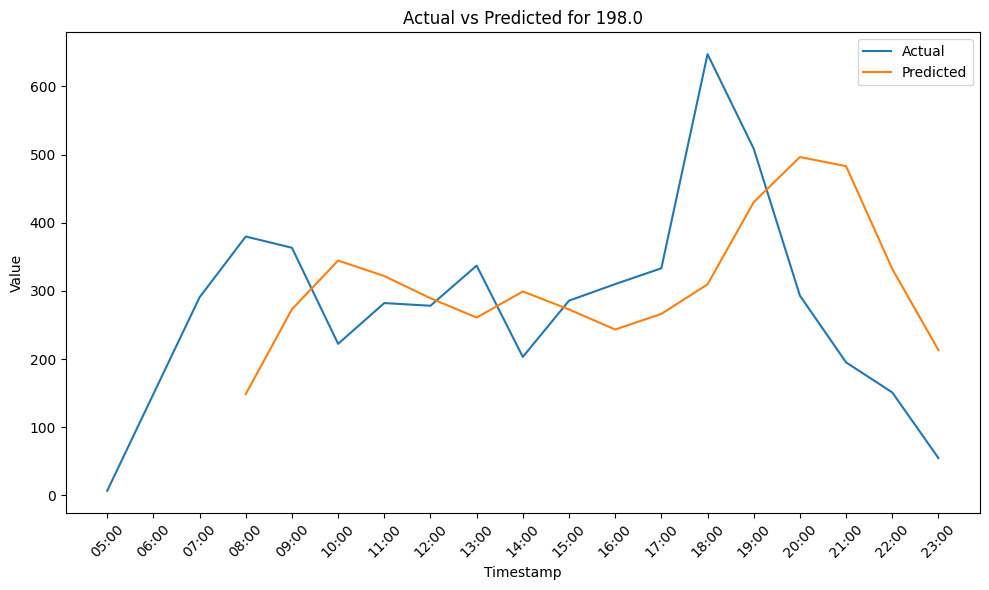

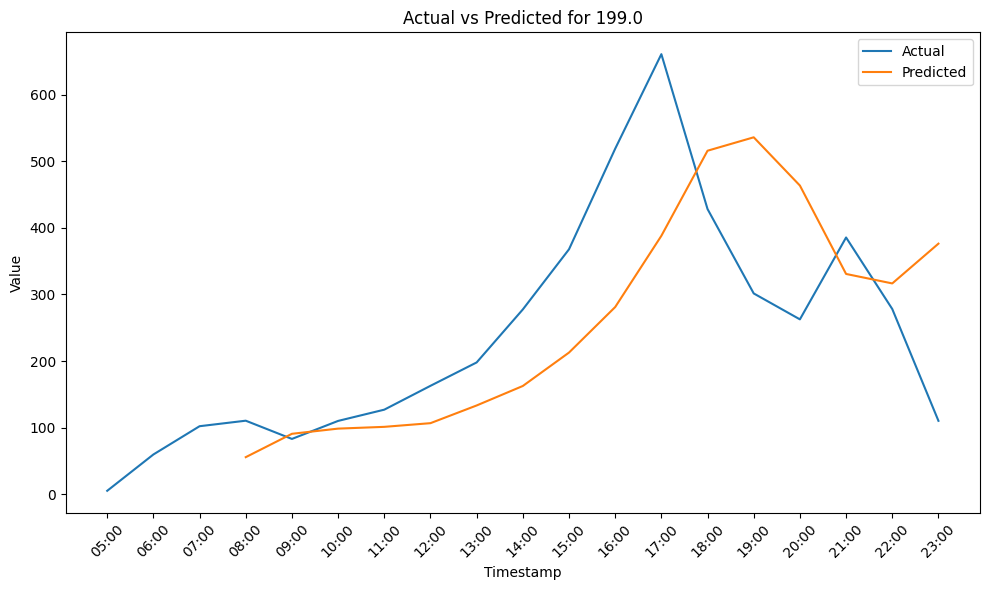

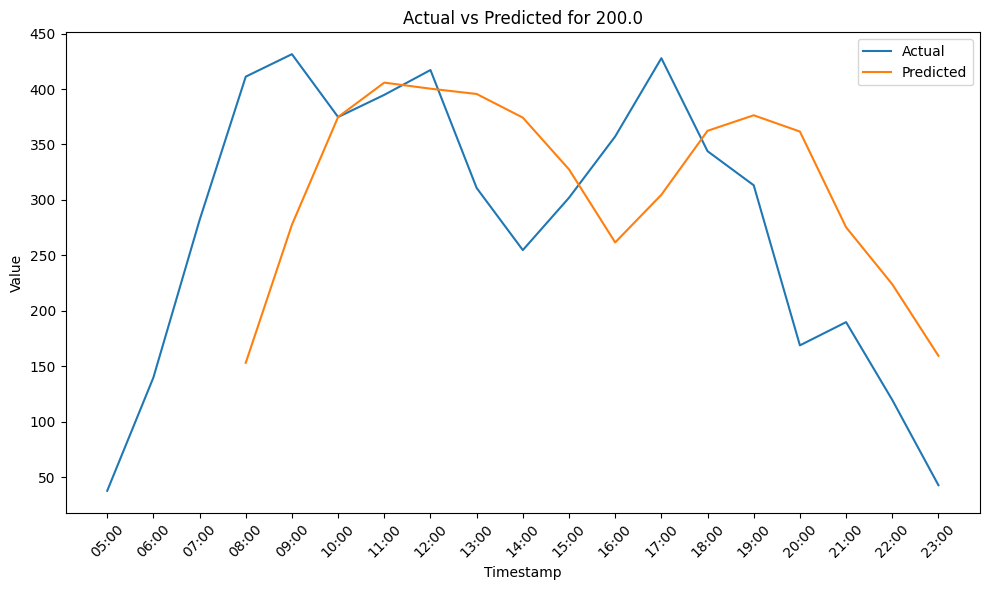

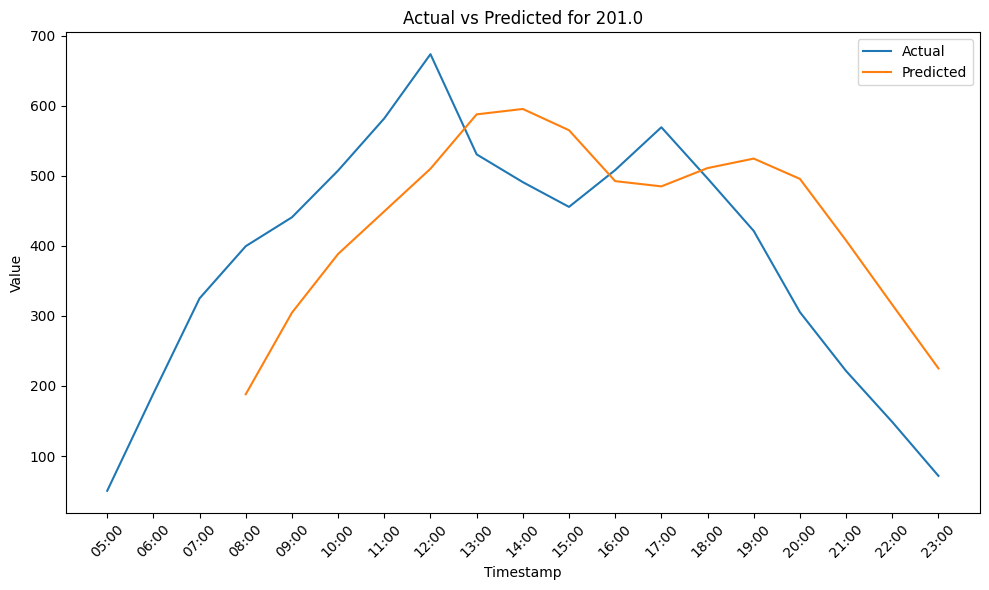

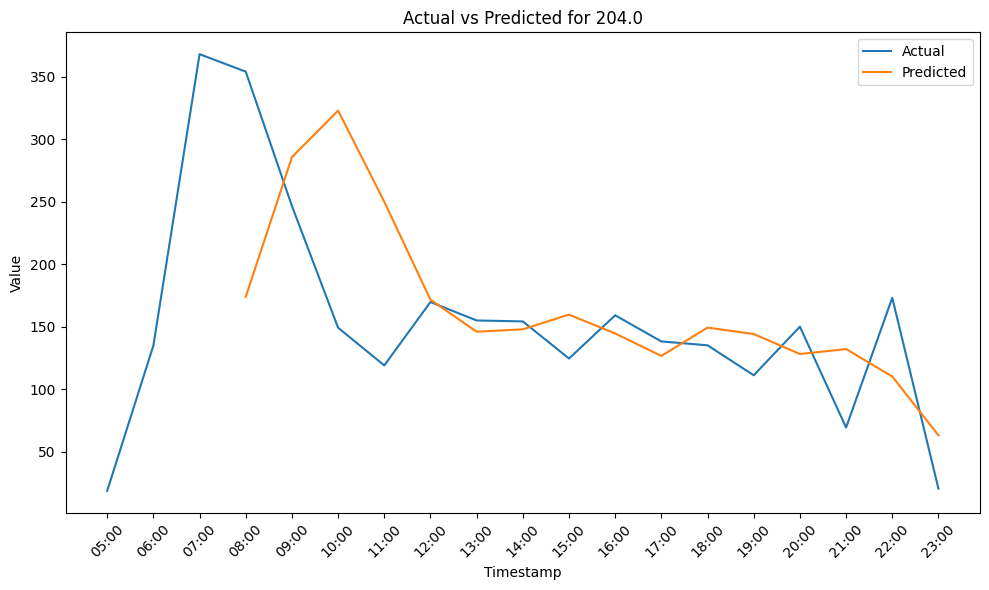

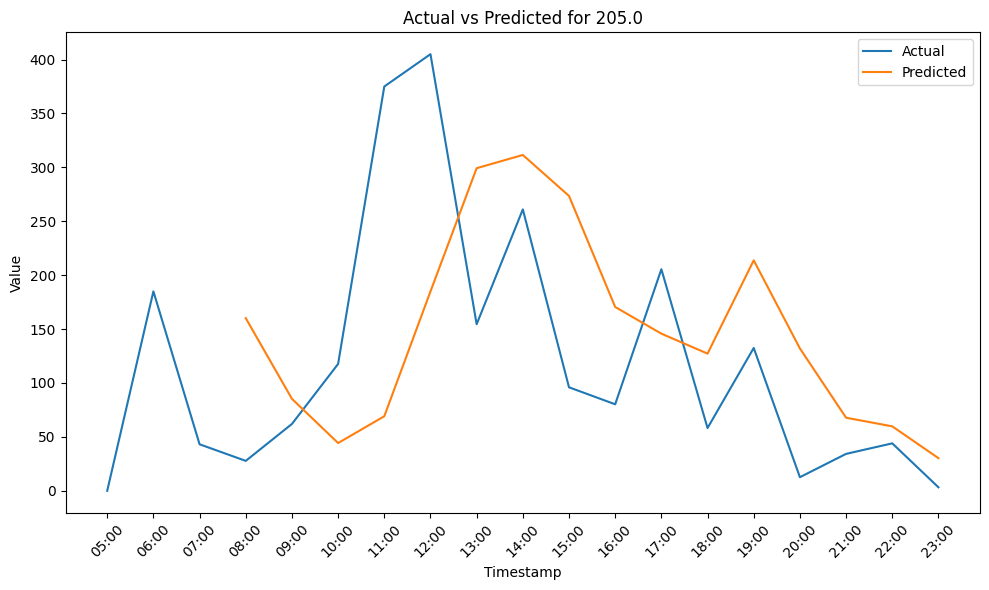

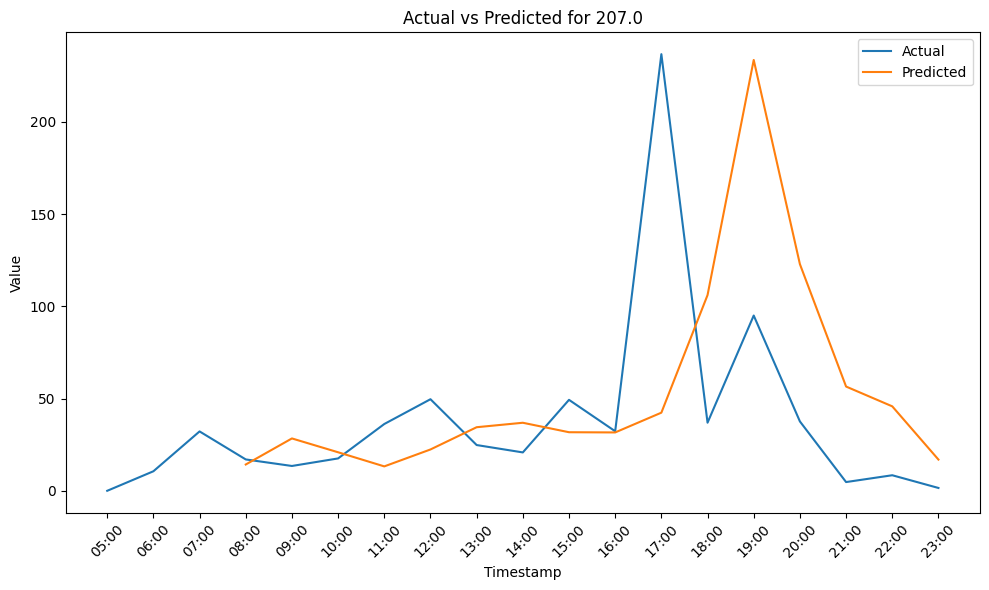

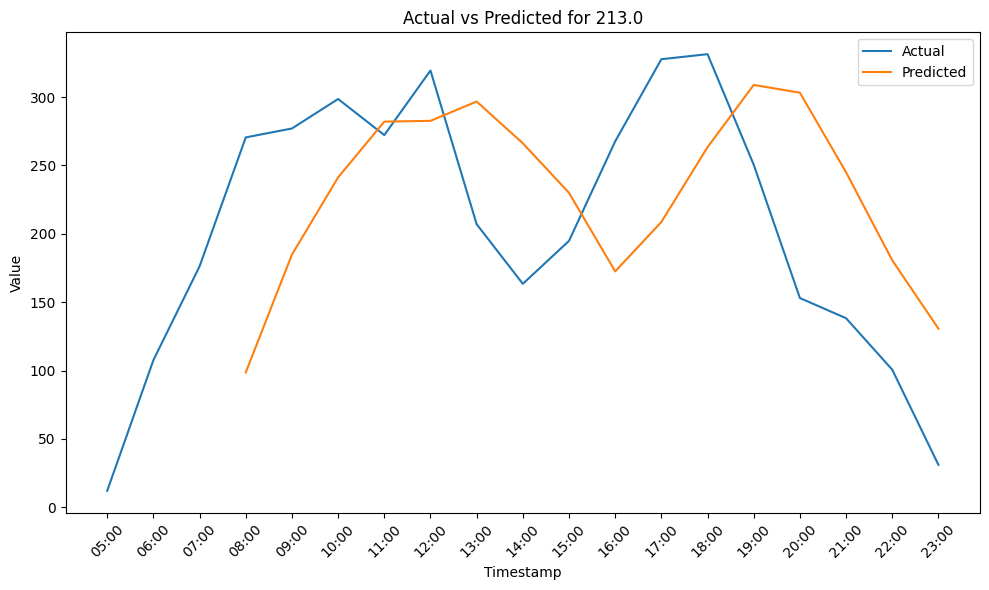

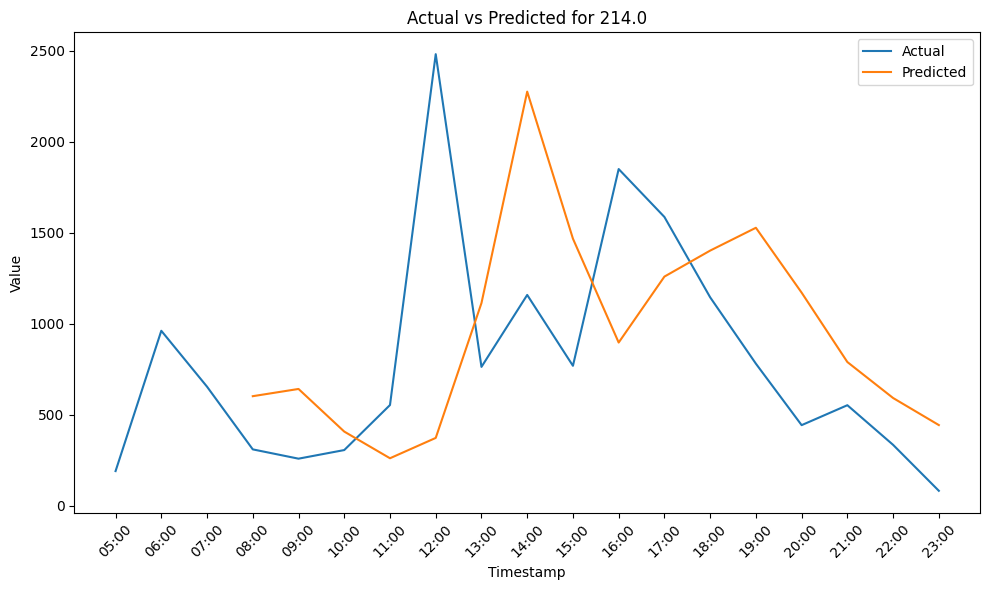

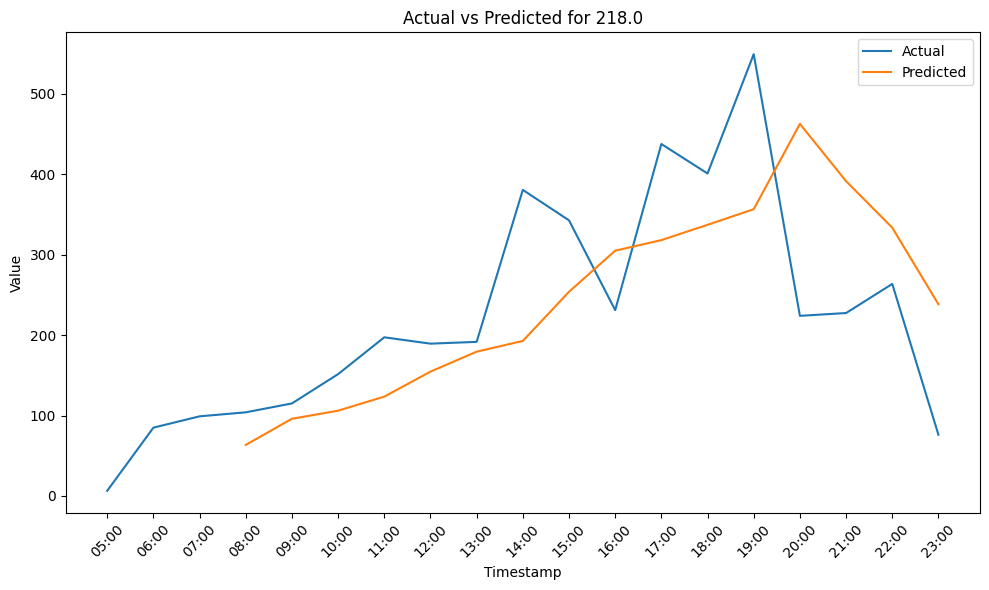

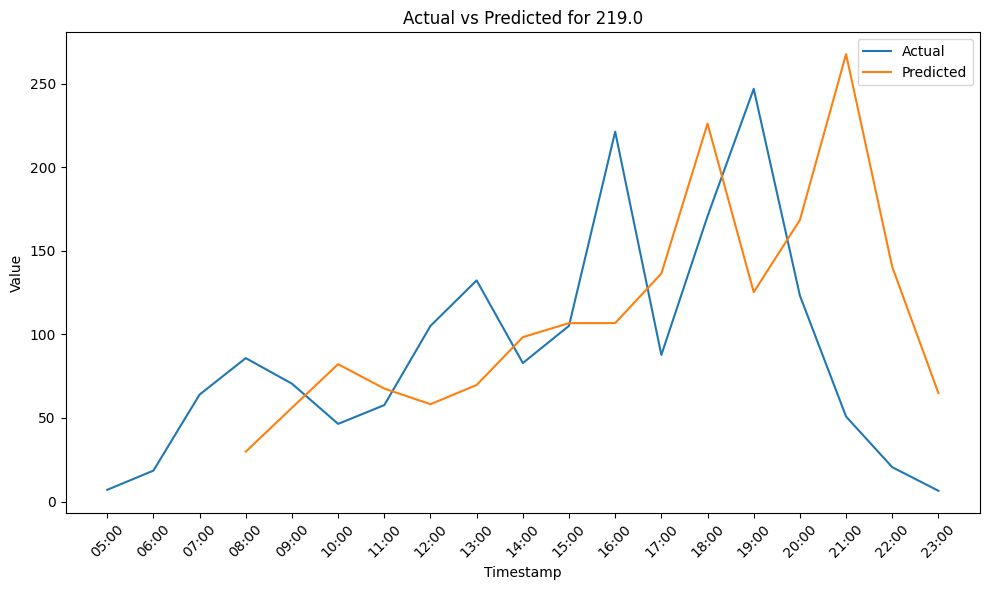

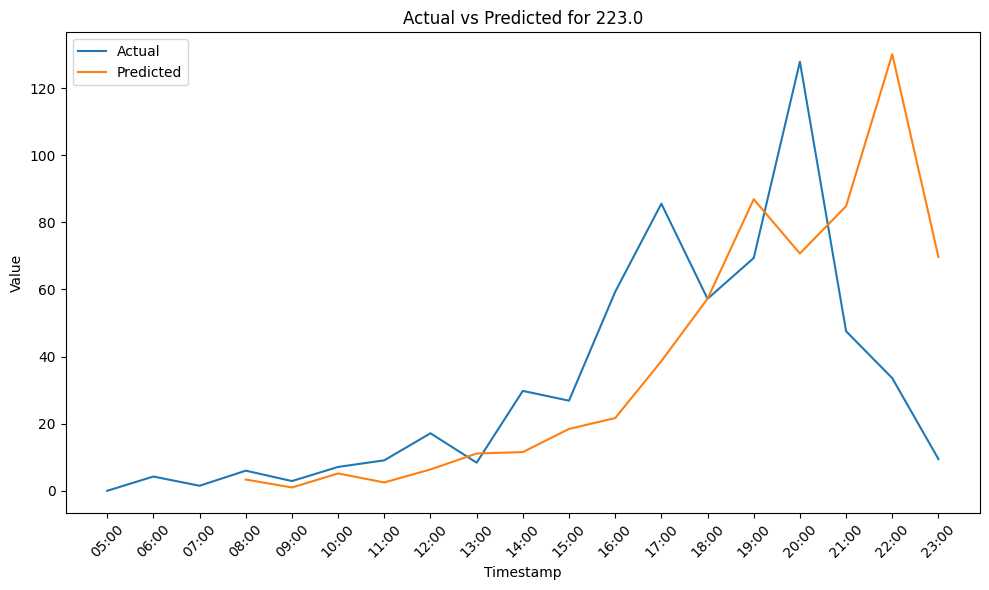

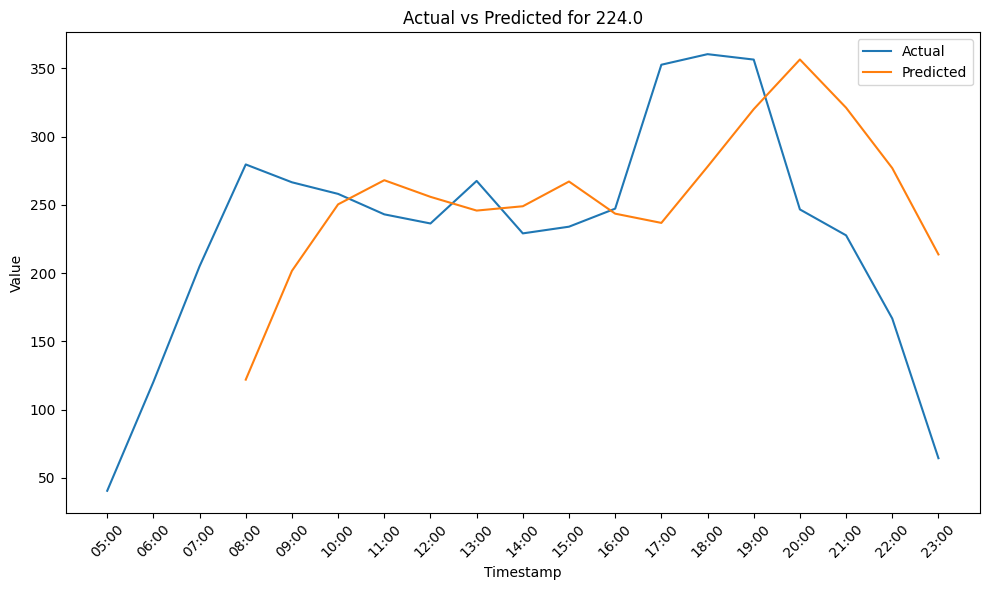

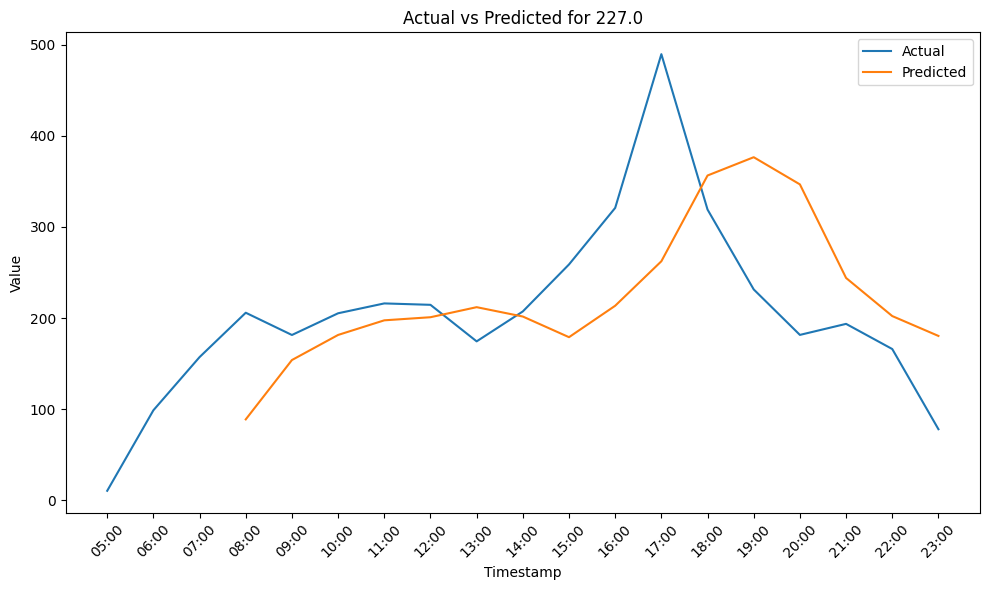

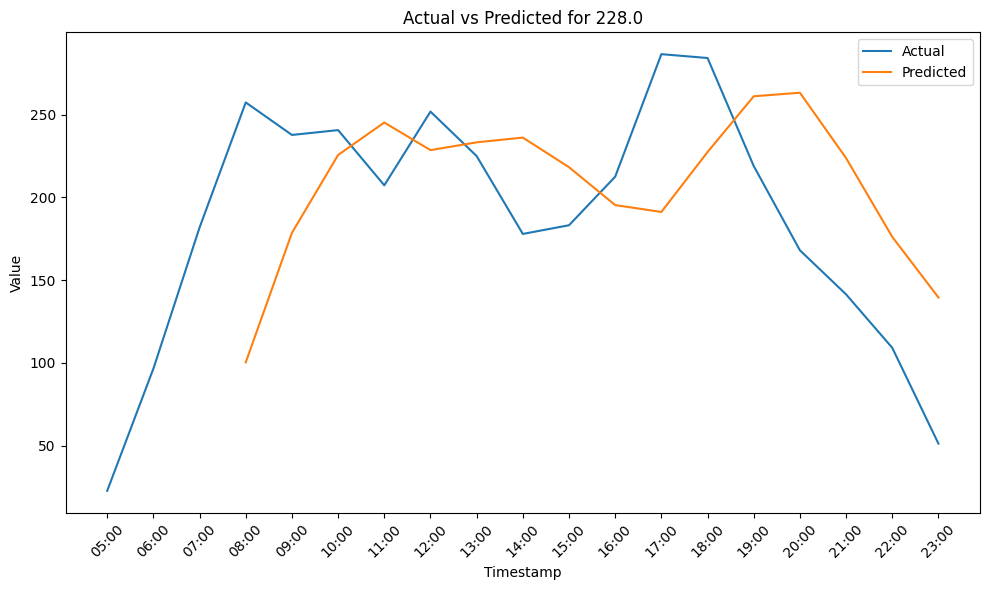

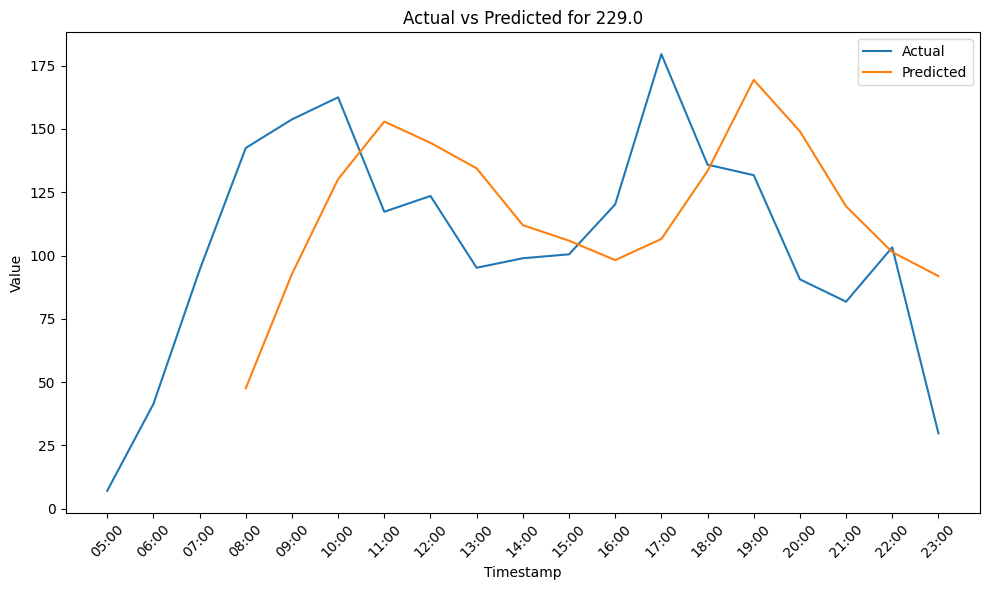

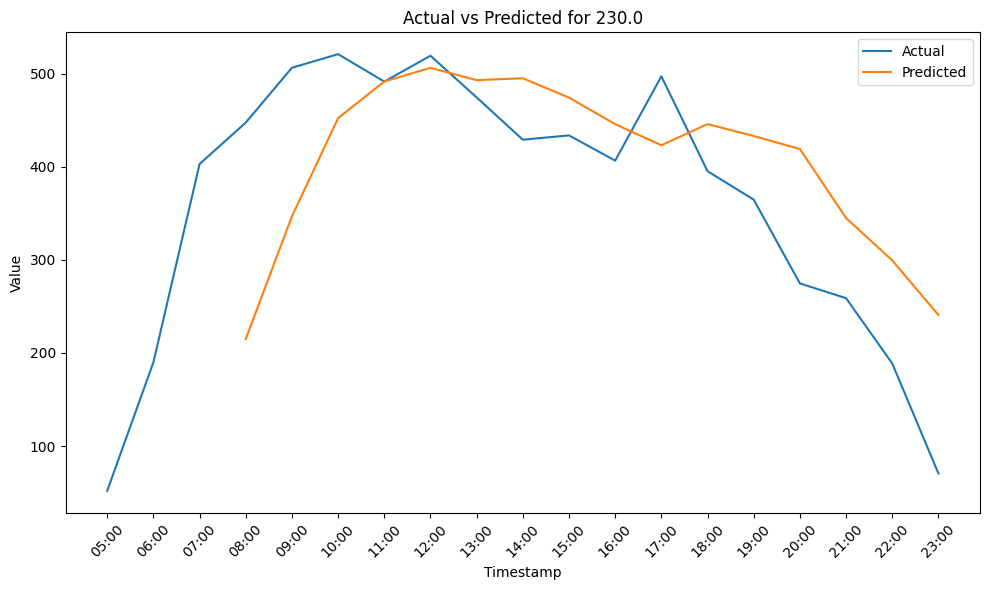

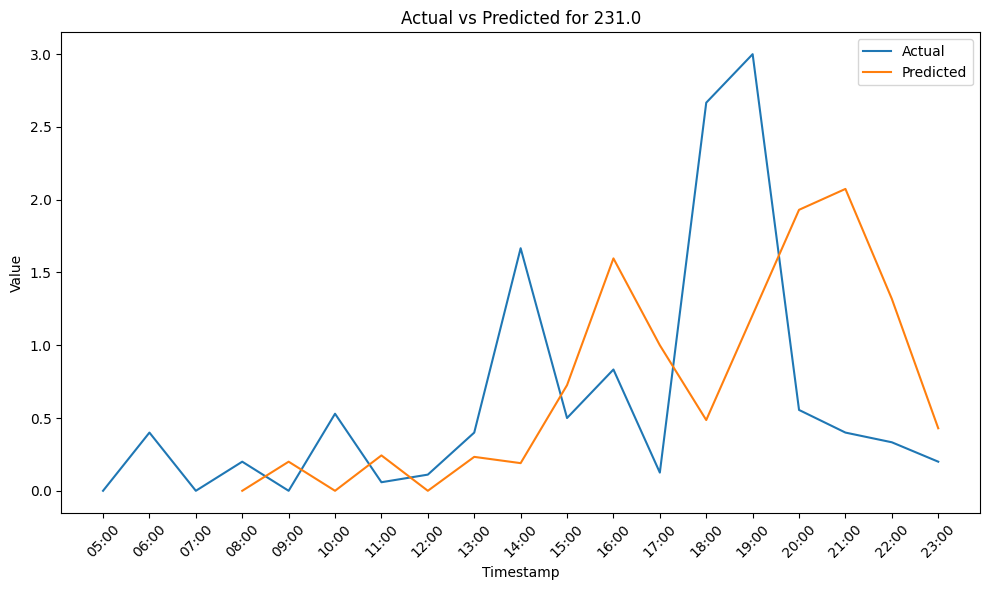

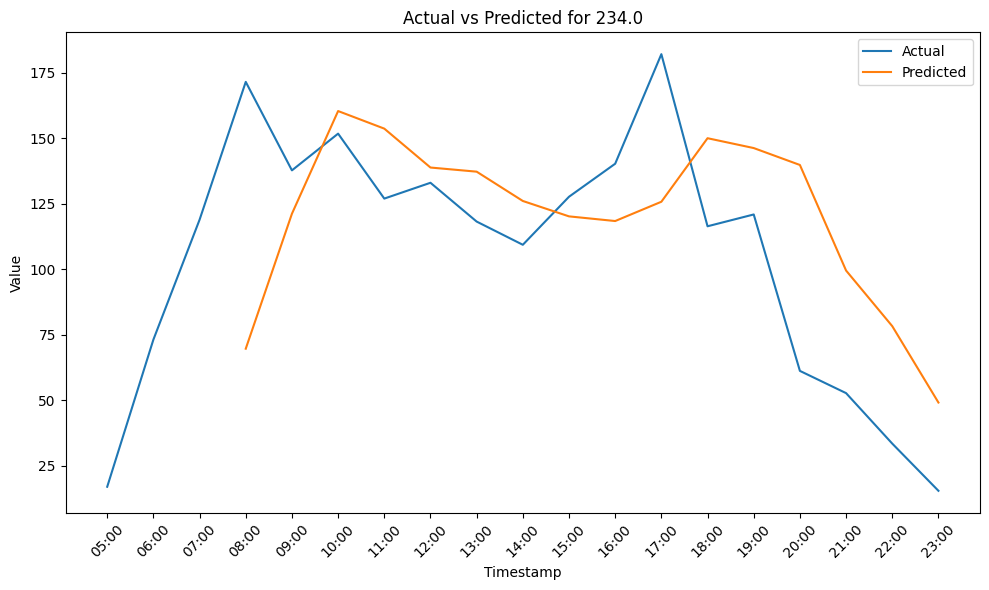

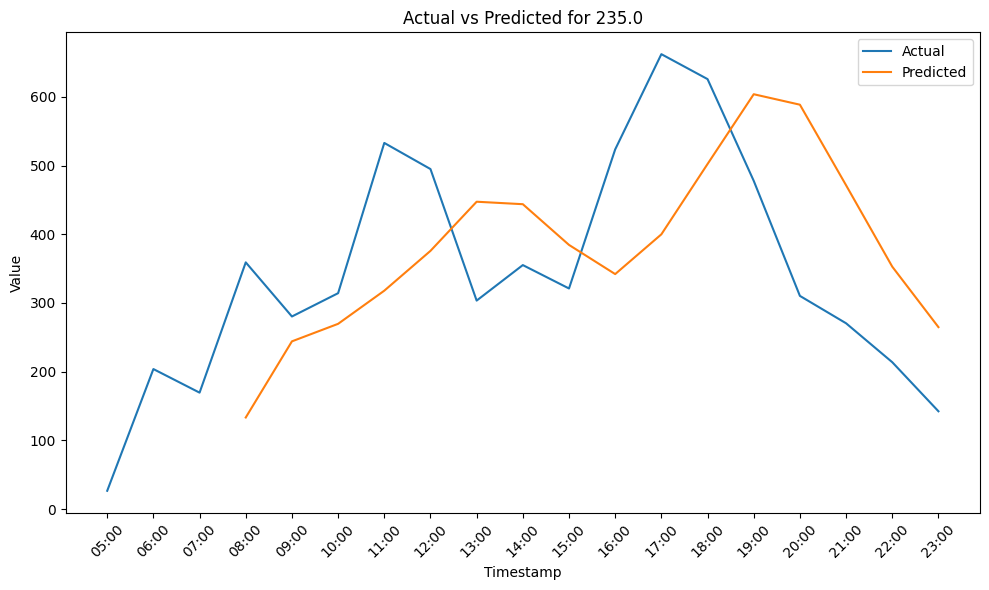

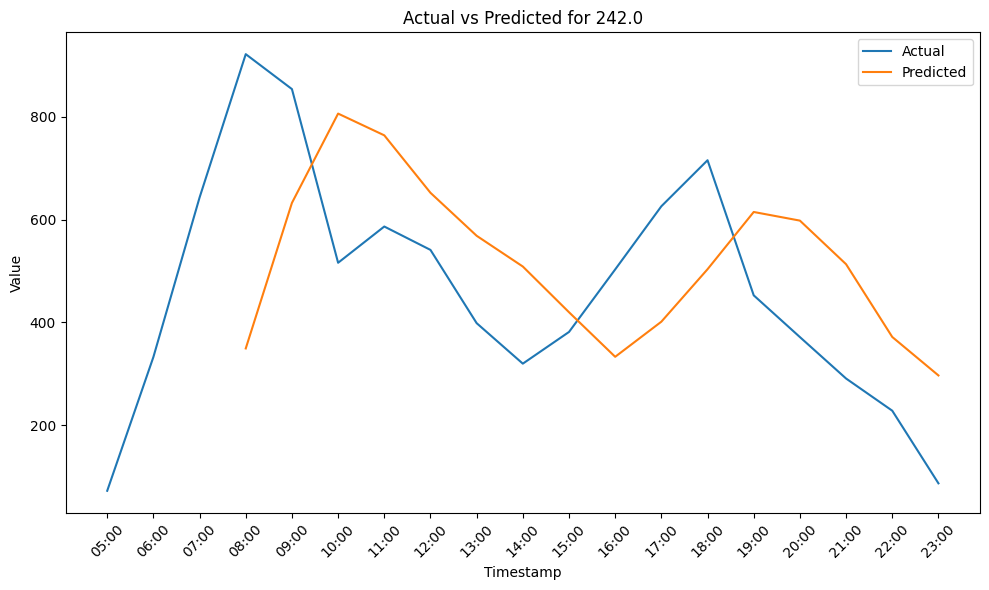

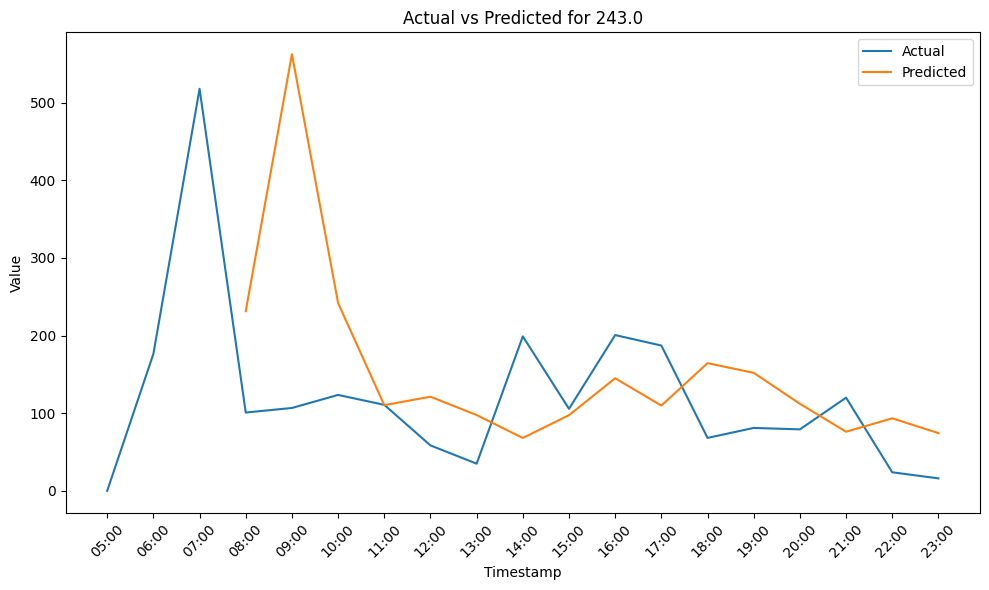

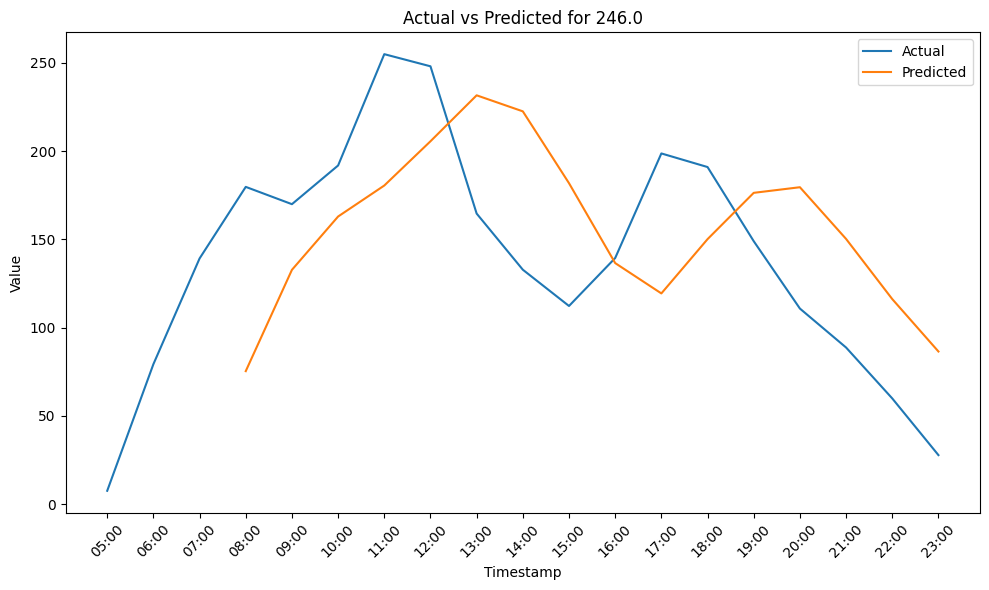

In [19]:
import matplotlib.pyplot as plt

# Iterate through each column in weekend_model
for column in weekend_model.columns:
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(weekend_model.index, weekend_model[column], label='Actual')
    plt.plot(weekend_predictions_df.index, weekend_predictions_df[column], label='Predicted')
    plt.title(f"Actual vs Predicted for {column}")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()